# Stock Market Prediction - Cluster 1

In [162]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [ ]:
data_cluster_1={}
data_cluster_2={}
data_cluster_3={}

tickers_clustered=pd.read_csv('tickers_clusters.csv')

for i in range (len(tickers_clustered)):

    ticker=tickers_clustered['Ticker'][i]
    cluster=tickers_clustered['Cluster'][i]

    # Download historical data for SPY
    spy_data = yf.download(ticker, start='2010-01-01', end='2023-12-31')

    # Reset index to make Date a column
    spy_data.reset_index(inplace=True)

    # Select relevant features
    features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Date']
    spy_data = spy_data[features]

    # Ensure the Date column is in datetime format
    spy_data['Date'] = pd.to_datetime(spy_data['Date'])

    # Create new features
    spy_data['Day_of_Week'] = spy_data['Date'].dt.dayofweek  # Monday=0, Sunday=6
    spy_data['Month'] = spy_data['Date'].dt.month  # January=1, December=12

    spy_data.drop(columns='Date', inplace=True)

    spy_data['EMA12'] = spy_data['Close'].ewm(span=12, adjust=False).mean()
    spy_data['EMA26'] = spy_data['Close'].ewm(span=26, adjust=False).mean()
    spy_data['MACD'] = spy_data['EMA12'] - spy_data['EMA26']  # MACD line
    spy_data['Signal_Line'] = spy_data['MACD'].ewm(span=9, adjust=False).mean()  # Signal line
    spy_data['MACD_Histogram'] = spy_data['MACD'] - spy_data['Signal_Line']  # MACD Histogram

    # CCI (Commodity Channel Index)
    typical_price = (spy_data['High'] + spy_data['Low'] + spy_data['Close']) / 3
    mean_deviation = lambda x: np.mean(np.abs(x - x.mean()))
    spy_data['CCI'] = (typical_price - typical_price.rolling(20).mean()) / (0.015 * typical_price.rolling(20).apply(mean_deviation))

    # ATR (Average True Range)
    high_low = spy_data['High'] - spy_data['Low']
    high_close = np.abs(spy_data['High'] - spy_data['Close'].shift())
    low_close = np.abs(spy_data['Low'] - spy_data['Close'].shift())
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    spy_data['ATR'] = true_range.rolling(window=14).mean()

    # Bollinger Bands (BOLL)
    spy_data['20_MA'] = spy_data['Close'].rolling(window=20).mean()
    spy_data['20_STD'] = spy_data['Close'].rolling(window=20).std()
    spy_data['Upper_Band'] = spy_data['20_MA'] + (2 * spy_data['20_STD'])
    spy_data['Lower_Band'] = spy_data['20_MA'] - (2 * spy_data['20_STD'])

    # EMA20 (20-day Exponential Moving Average)
    spy_data['EMA20'] = spy_data['Close'].ewm(span=20, adjust=False).mean()

    # MA5 and MA10 (5-day and 10-day Simple Moving Averages)
    spy_data['MA5'] = spy_data['Close'].rolling(window=5).mean()
    spy_data['MA10'] = spy_data['Close'].rolling(window=10).mean()

    # MTM6 and MTM12 (6-month and 12-month Momentum)
    spy_data['MTM6'] = spy_data['Close'].pct_change(periods=126)  # Approx. 6 months
    spy_data['MTM12'] = spy_data['Close'].pct_change(periods=252)  # Approx. 12 months

    # ROC (Rate of Change)
    spy_data['ROC'] = spy_data['Close'].pct_change(periods=10) * 100  # 10-day rate of change

    # SMI (Stochastic Momentum Index)
    low_min = spy_data['Low'].rolling(window=14).min()
    high_max = spy_data['High'].rolling(window=14).max()
    spy_data['SMI'] = 100 * ((spy_data['Close'] - low_min) / (high_max - low_min))

    # WVAD (Williams's Variable Accumulation/Distribution)
    spy_data['WVAD'] = ((spy_data['Close'] - spy_data['Low']) - (spy_data['High'] - spy_data['Close'])) / (spy_data['High'] - spy_data['Low']) * spy_data['Volume']

    # Williams %R
    spy_data['Daily_Return'] = spy_data['Close'].pct_change()

    # Add 5-day cumulative return
    #spy_data['5_Day_Cumulative_Return'] = spy_data['Close'].pct_change(periods=4)

    for lag in range(1, 6):  # Add 5 lagged returns
        spy_data[f'Return_Lag_{lag}'] = spy_data['Daily_Return'].shift(lag)

    spy_data['Rolling_STD'] = spy_data['Close'].rolling(window=10).std()

    # Drop NaN values
    spy_data.dropna(inplace=True)

    print(spy_data.head())

    # Convert to NumPy array
    data = spy_data.values
    print("Dataset shape:", data.shape)  # (num_days, num_features)
    print(data)
    if cluster==1:
        data_cluster_1[ticker]=data
    elif cluster==2:
        data_cluster_2[ticker]=data
    else:
        data_cluster_3[ticker]=data

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        MMM        MMM        MMM        MMM      MMM                     
252     72.533447  73.018394  72.525085  72.566887  3148829           0     1   
253     72.742477  72.976585  72.140465  72.466553  3162344           1     1   
254     72.148827  73.494980  72.006691  72.466553  4881235           2     1   
255     72.625420  72.901337  71.596992  72.023415  4129310           3     1   
256     72.366219  73.001671  71.864548  72.098663  4013178           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     72.297521  72.062335  0.235186  ...  0.486273  63.214136   
253     72.323526  72.092277  0.231249  ... -0.767121  56.928824   
254     72.345530  72.120001  0.225529  ...  0.161795  55.272780   
255     72.295974  72.112847  0.183127  ... -0.668816  22.467068   
256     72.265618  72.11

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price     Open    High     Low   Close   Volume Day_of_Week Month     EMA12  \
Ticker     AOS     AOS     AOS     AOS      AOS                               
252     9.6025  9.6625  9.5075  9.5350  1008400           0     1  9.747202   
253     9.5325  9.6350  9.3950  9.5050  1506800           1     1  9.709940   
254     9.4575  9.7375  9.4575  9.7225  1780800           2     1  9.711873   
255     9.7425  9.8500  9.7025  9.7275  1474800           3     1  9.714277   
256     9.7350  9.9500  9.7350  9.8675  1966000           4     1  9.737850   

Price      EMA26      MACD  ...       ROC        SMI          WVAD  \
Ticker                      ...                                      
252     9.830048 -0.082846  ... -1.675694   2.528748 -6.505802e+05   
253     9.805971 -0.096030  ... -3.133757   9.999974 -1.255697e+05   
254     9.799788 -0.087915  ... -1.668773  36.592131  1.589995e+06   
255     9.794433 -0.080156  ... -1.218582  52.988004 -9.748756e+05   
256     9.799845 -0.061996

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        ABT        ABT        ABT        ABT       ABT               
252     23.169542  23.169542  22.920046  22.944036  19050229           0   
253     23.049591  23.183935  22.934441  23.159946  18826386           1   
254     23.135956  23.423836  23.063986  23.159946  28342643           2   
255     23.270300  23.327875  22.924845  23.111965  32471030           3   
256     23.097572  23.246309  23.044794  23.207926  21604419           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  22.896844  22.980574 -0.083730  ... -1.198347  38.311839   
253        1  22.937322  22.993861 -0.056539  ...  0.000000  67.532628   
254        1  22.971572  23.006164 -0.034592  ...  0.562505  65.408906   
255        1  22.993171  23.014001 -0.020830  ...  0.689794  59.119434   
256        1  23.026210

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        ACN        ACN        ACN        ACN      ACN                     
252     48.660000  49.369999  48.549999  48.590000  2508700           0     1   
253     48.750000  48.869999  48.110001  48.270000  3169400           1     1   
254     48.139999  48.529999  47.680000  48.279999  3041600           2     1   
255     48.180000  48.570000  47.880001  48.459999  3859000           3     1   
256     48.369999  48.700001  48.040001  48.540001  2914600           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     48.038557  47.022477  1.016080  ... -3.437996  47.697974   
253     48.074163  47.114886  0.959277  ... -0.862596  41.804794   
254     48.105830  47.201191  0.904640  ... -0.923457  41.988925   
255     48.160318  47.294436  0.865882  ... -0.370066  24.234701   
256     48.218731  47.38

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       ADBE       ADBE       ADBE       ADBE     ADBE                     
252     30.830000  31.480000  30.790001  31.290001  6245500           0     1   
253     31.280001  31.650000  31.180000  31.510000  8038100           1     1   
254     31.480000  32.240002  31.420000  32.220001  7143500           2     1   
255     32.130001  32.290001  31.879999  32.270000  6230900           3     1   
256     32.180000  32.220001  31.500000  32.040001  6828500           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     30.398674  29.768094  0.630580  ...  8.683570  95.214140   
253     30.569647  29.897124  0.672523  ...  7.984921  96.618372   
254     30.823548  30.069189  0.754359  ...  4.170711  99.577157   
255     31.046079  30.232212  0.813867  ...  5.285484  99.488480   
256     31.198990  30.36

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price   Open  High   Low Close    Volume Day_of_Week Month     EMA12  \
Ticker   AMD   AMD   AMD   AMD       AMD                               
252     8.44  8.55  8.39  8.47  21152900           0     1  8.142089   
253     8.56  8.84  8.54  8.77  26875300           1     1  8.238691   
254     8.74  8.95  8.72  8.91  19457400           2     1  8.341969   
255     8.92  8.94  8.67  8.69  21198200           3     1  8.395512   
256     8.73  8.86  8.63  8.83  14062400           4     1  8.462357   

Price      EMA26      MACD  ...       ROC        SMI          WVAD  \
Ticker                      ...                                      
252     7.985739  0.156350  ...  4.567900  88.405809  0.000000e+00   
253     8.043832  0.194859  ...  6.432047  92.857174  1.433356e+07   
254     8.107993  0.233976  ...  9.459453  96.330278  1.268960e+07   
255     8.151104  0.244408  ...  7.151664  76.146761 -1.805780e+07   
256     8.201393  0.260964  ...  9.825870  88.235305  1.039397e+07   

Pric

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price    Open   High    Low  Close    Volume Day_of_Week Month      EMA12  \
Ticker    AES    AES    AES    AES       AES                                
252     12.34  12.68  12.23  12.54  10313500           0     1  12.059825   
253     12.52  12.60  12.39  12.60   5636100           1     1  12.142929   
254     12.51  12.85  12.46  12.77   9064600           2     1  12.239401   
255     12.74  13.00  12.63  12.99  13255400           3     1  12.354878   
256     12.99  13.17  12.81  12.99  10993300           4     1  12.452589   

Price       EMA26      MACD  ...       ROC        SMI          WVAD  \
Ticker                       ...                                      
252     11.814631  0.245194  ...  9.615388  91.194948  3.896206e+06   
253     11.872807  0.270122  ...  7.142858  94.968559  5.636100e+06   
254     11.939265  0.300136  ...  5.363041  95.454550  5.345797e+06   
255     12.017098  0.337780  ...  5.097088  99.418591  1.253888e+07   
256     12.089164  0.363425  ...  

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        AFL        AFL        AFL        AFL      AFL                     
252     28.490000  28.920000  28.440001  28.770000  5921000           0     1   
253     28.770000  28.790001  28.049999  28.245001  7720600           1     1   
254     28.139999  28.440001  28.055000  28.190001  6973200           2     1   
255     28.254999  28.370001  27.900000  28.035000  5649000           3     1   
256     28.145000  28.270000  27.760000  27.924999  4870000           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     28.231812  27.912384  0.319428  ...  3.563714  90.566063   
253     28.233841  27.937023  0.296818  ...  0.444523  57.547222   
254     28.227096  27.955762  0.271335  ... -0.388688  54.088084   
255     28.197543  27.961631  0.235912  ... -2.026909  40.404049   
256     28.155613  27.95

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker          A          A          A          A        A                     
252     29.728184  30.143063  29.620888  29.957083  4994075           0     1   
253     30.035765  30.114449  29.456366  29.678112  5017282           1     1   
254     29.513592  29.849785  29.327612  29.613733  4519035           2     1   
255     29.592276  29.928469  29.477825  29.670959  4699097           3     1   
256     29.699572  29.899857  29.356222  29.771103  3810948           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     29.276486  28.270212  1.006274  ...  3.305381  92.934787   
253     29.338274  28.374501  0.963774  ...  2.116667  82.336932   
254     29.380653  28.466296  0.914357  ...  1.396029  79.781364   
255     29.425315  28.555530  0.869785  ...  1.022897  75.373157   
256     29.478513  28.64

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        APD        APD        APD        APD      APD                     
252     84.680855  84.838112  83.543015  83.746529  1188127           0     1   
253     83.718781  83.857536  82.284920  82.506935  1185533           1     1   
254     82.368179  82.682701  81.961143  82.146164  1312658           2     1   
255     82.044403  82.173912  81.128586  81.720627  1683982           3     1   
256     81.951897  83.052727  81.369102  81.868637  1168669           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     83.532694  82.377308  1.155385  ...  1.343326  73.423386   
253     83.374885  82.386910  0.987974  ... -0.822867  43.243188   
254     83.185851  82.369077  0.816774  ... -1.910962  27.791626   
255     82.960432  82.321044  0.639388  ... -2.462184  15.960018   
256     82.792463  82.28

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       AKAM       AKAM       AKAM       AKAM     AKAM                     
252     47.610001  49.150002  47.580002  48.259998  3595600           0     1   
253     48.450001  48.730000  46.799999  47.139999  4083800           1     1   
254     47.070000  49.340000  46.689999  48.849998  6109200           2     1   
255     48.959999  49.330002  48.299999  48.450001  2396600           3     1   
256     48.560001  48.919998  47.810001  48.689999  2754100           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     48.614777  49.470289 -0.855512  ... -5.130727  33.838363   
253     48.387888  49.297675 -0.909787  ... -4.128531   8.353813   
254     48.458982  49.264514 -0.805532  ... -3.056164  51.674634   
255     48.457601  49.204180 -0.746579  ... -0.696864  42.105311   
256     48.493354  49.16

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker        ALB        ALB        ALB        ALB     ALB                     
252     56.119999  57.119999  55.730000  55.860001  663800           0     1   
253     56.080002  56.180000  54.730000  55.340000  715400           1     1   
254     55.009998  55.330002  54.680000  55.160000  503800           2     1   
255     55.380001  55.549999  54.709999  54.810001  651800           3     1   
256     54.959999  55.130001  54.330002  54.680000  486900           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     55.876130  55.164022  0.712108  ... -0.781525  50.501715   
253     55.793648  55.177057  0.616591  ... -0.788811  33.110405   
254     55.696164  55.175794  0.520370  ... -2.767495  27.090332   
255     55.559831  55.148698  0.411133  ... -2.403843   4.887258   
256     55.424473  55.113980  0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker        ARE        ARE        ARE        ARE     ARE                     
252     73.800003  74.839996  73.660004  74.510002  521200           0     1   
253     74.589996  75.330002  73.239998  73.330002  504000           1     1   
254     73.120003  74.160004  73.050003  73.889999  430000           2     1   
255     73.989998  74.120003  72.989998  73.070000  379500           3     1   
256     73.080002  75.570000  73.080002  75.510002  884600           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     72.308601  71.247217  1.061385  ...  7.332187  94.642948   
253     72.465740  71.401497  1.064243  ...  4.147135  69.924819   
254     72.684857  71.585831  1.099026  ...  4.526803  78.345833   
255     72.744110  71.695769  1.048340  ...  1.528412  66.015013   
256     73.169631  71.978305  1

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       ALGN       ALGN       ALGN       ALGN     ALGN                     
252     19.750000  20.270000  19.620001  19.870001   444700           0     1   
253     20.000000  20.120001  19.230000  19.500000   476000           1     1   
254     19.450001  20.100000  19.340000  19.830000   656200           2     1   
255     19.830000  20.000000  19.440001  19.590000   531500           3     1   
256     19.540001  20.139999  19.299999  20.000000  1317000           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     19.737819  19.259844  0.477974  ... -1.193435  62.318894   
253     19.701231  19.277634  0.423597  ... -2.840058  42.500019   
254     19.721042  19.318550  0.402492  ... -2.218939  59.000015   
255     19.700881  19.338657  0.362224  ... -3.829164  26.896531   
256     19.746900  19.38

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        LNT        LNT        LNT        LNT      LNT                     
252     18.530001  18.615000  18.465000  18.575001  1129200           0     1   
253     18.674999  18.674999  18.475000  18.650000  1420400           1     1   
254     18.635000  18.750000  18.559999  18.625000   846800           2     1   
255     18.705000  18.709999  18.575001  18.625000   970600           3     1   
256     18.690001  18.780001  18.600000  18.674999  1151800           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     18.453137  18.406537  0.046600  ...  0.814120  83.654037   
253     18.483423  18.424571  0.058852  ...  1.829097  95.327173   
254     18.505204  18.439417  0.065787  ...  1.332975  79.508217   
255     18.523634  18.453164  0.070470  ...  0.026848  75.728127   
256     18.546921  18.46

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        ALL        ALL        ALL        ALL      ALL                     
252     32.220001  32.500000  32.029999  32.230000  3824800           0     1   
253     32.240002  32.240002  31.650000  31.910000  3636800           1     1   
254     31.730000  32.080002  31.700001  31.860001  4190500           2     1   
255     31.840000  31.900000  31.389999  31.500000  3956400           3     1   
256     31.590000  31.650000  31.120001  31.290001  3613000           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     31.727525  31.314516  0.413009  ...  2.938359  84.916183   
253     31.755598  31.358626  0.396972  ...  1.818761  67.039114   
254     31.771660  31.395765  0.375895  ... -0.031378  64.245862   
255     31.729866  31.403486  0.326380  ... -1.470126  35.897414   
256     31.662195  31.39

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close     Volume Day_of_Week  \
Ticker      GOOGL      GOOGL      GOOGL      GOOGL      GOOGL               
252     14.926927  15.154905  14.926927  15.123874   94513392           0   
253     15.155656  15.169670  15.018018  15.068068   72907020           1   
254     15.016767  15.273524  15.016266  15.241992  101190708           2   
255     15.282282  15.476226  15.266517  15.352853   82229688           3   
256     15.413163  15.471722  15.268519  15.426426   83963952           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  14.973804  14.890803  0.083001  ...  2.293496  86.290691   
253        1  14.988306  14.903934  0.084373  ...  1.186436  74.754156   
254        1  15.027335  14.928975  0.098360  ...  0.994910  94.439418   
255        1  15.077414  14.960373  0.117041  ...  1.322898  83.972734   
256        1  15

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close     Volume Day_of_Week  \
Ticker       GOOG       GOOG       GOOG       GOOG       GOOG               
252     14.856315  15.083214  14.856315  15.052330   94962614           0   
253     15.083962  15.097909  14.946975  14.996788   73253547           1   
254     14.945730  15.201272  14.945232  15.169890  101671667           2   
255     15.209989  15.403016  15.194298  15.280226   82620526           3   
256     15.340251  15.398533  15.196291  15.353451   84363033           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  14.902970  14.820362  0.082609  ...  2.293502  86.290714   
253        1  14.917404  14.833430  0.083973  ...  1.186438  74.754226   
254        1  14.956248  14.858353  0.097895  ...  0.994915  94.439685   
255        1  15.006091  14.889603  0.116488  ...  1.322894  83.972639   
256        1  15

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open   High        Low      Close    Volume Day_of_Week Month  \
Ticker         MO     MO         MO         MO        MO                     
252     24.709999  24.77  24.440001  24.500000  10546500           0     1   
253     24.469999  24.49  24.129999  24.389999  12607100           1     1   
254     24.430000  24.51  24.290001  24.480000  12798100           2     1   
255     24.559999  24.67  24.459999  24.580000  10559900           3     1   
256     24.629999  24.68  24.370001  24.389999  11876300           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     24.719230  24.713615  0.005615  ... -1.960783   6.741518   
253     24.668579  24.689644 -0.021065  ... -3.098930  21.666672   
254     24.639567  24.674115 -0.034548  ... -3.049507  29.166680   
255     24.630403  24.667143 -0.036740  ... -2.692004  37.500040   
256     24.593418  24.646614 -0.053196  ... -

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price     Open    High     Low   Close     Volume Day_of_Week Month     EMA12  \
Ticker    AMZN    AMZN    AMZN    AMZN       AMZN                               
252     9.0685  9.3000  9.0605  9.2110  106628000           0     1  9.067682   
253     9.3075  9.3850  9.1890  9.2505  100636000           1     1  9.095808   
254     9.2050  9.3725  9.2035  9.3710   68376000           2     1  9.138145   
255     9.3250  9.3705  9.2625  9.2930   63594000           3     1  9.161969   
256     9.3940  9.4225  9.1870  9.2745  104434000           4     1  9.179281   

Price      EMA26      MACD  ...       ROC        SMI          WVAD  \
Ticker                      ...                                      
252     8.913588  0.154094  ...  3.739168  86.212281  2.738071e+07   
253     8.938545  0.157263  ...  0.938398  80.935452 -3.748222e+07   
254     8.970578  0.167567  ...  1.445197  97.788321  6.716212e+07   
255     8.994461  0.167507  ...  0.595370  82.771547 -2.767462e+07   
256     9.01

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        AEE        AEE        AEE        AEE      AEE                     
252     28.330000  28.340000  28.120001  28.250000  1160000           0     1   
253     28.320000  28.490000  28.070000  28.459999  1859300           1     1   
254     28.379999  28.530001  28.309999  28.400000  2065600           2     1   
255     28.410000  28.430000  28.139999  28.290001  1327800           3     1   
256     28.290001  28.379999  28.070000  28.290001  1891900           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     28.305854  28.485263 -0.179409  ... -0.528168  48.000031   
253     28.329568  28.483391 -0.153823  ...  0.779034  68.644005   
254     28.340404  28.477214 -0.136810  ...  0.959831  84.269540   
255     28.332650  28.463346 -0.130697  ... -0.035330  59.677474   
256     28.326088  28.45

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        AEP        AEP        AEP        AEP      AEP                     
252     36.270000  36.299999  36.000000  36.250000  1882000           0     1   
253     36.419998  36.689999  36.049999  36.509998  3294500           1     1   
254     36.250000  36.349998  35.910000  35.959999  4131600           2     1   
255     36.049999  36.189999  35.639999  36.139999  3570500           3     1   
256     36.230000  36.279999  35.709999  36.000000  2727900           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     36.003636  35.995611  0.008025  ...  0.722418  81.481324   
253     36.081538  36.033714  0.047824  ...  1.529475  83.636313   
254     36.062840  36.028254  0.034586  ...  0.446927  33.636313   
255     36.074710  36.036531  0.038179  ...  0.500557  50.000000   
256     36.063217  36.03

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        AXP        AXP        AXP        AXP       AXP               
252     43.299999  43.619999  43.110001  43.400002   7633300           0   
253     44.410000  44.410000  43.200001  43.950001  14066300           1   
254     44.090000  45.160000  43.910000  45.040001  10655300           2   
255     45.380001  45.599998  44.450001  44.730000   6347100           3   
256     44.930000  44.959999  44.000000  44.360001   6387800           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  43.317092  43.495721 -0.178628  ... -1.386041  38.878879   
253        1  43.414463  43.529371 -0.114908  ...  3.411767  48.824618   
254        1  43.664546  43.641270  0.023276  ...  4.186910  73.449632   
255        1  43.828462  43.721916  0.106545  ...  4.484929  80.000018   
256        1  43.910237

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        AIG        AIG        AIG        AIG       AIG               
252     58.340000  58.470001  57.000000  58.049999   5408500           0   
253     57.990002  57.990002  56.080002  56.779999   5437200           1   
254     56.459999  60.970001  56.240002  60.950001  15085700           2   
255     61.060001  62.459999  60.049999  60.450001  11474200           3   
256     61.869999  62.869999  60.740002  61.180000  12774600           4   

Price  Month      EMA12      EMA26      MACD  ...        ROC        SMI  \
Ticker                                        ...                         
252        1  55.607113  51.819514  3.787599  ...  10.445201  72.645057   
253        1  55.787557  52.186958  3.600600  ...   6.289780  57.055201   
254        1  56.581779  52.836072  3.745707  ...  10.456688  93.047623   
255        1  57.176890  53.400067  3.776824  ...   8.411052  81.055625   
256        1  57.

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        AMT        AMT        AMT        AMT      AMT                     
252     51.910000  52.150002  51.459999  51.630001  2413800           0     1   
253     51.630001  52.189999  51.349998  51.470001  2932100           1     1   
254     51.220001  51.400002  50.740002  50.759998  3414100           2     1   
255     50.790001  51.180000  50.480000  50.619999  2880000           3     1   
256     50.959999  51.090000  50.419998  50.500000  3571200           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     51.098054  51.038873  0.059180  ...  4.071761  84.337334   
253     51.155276  51.070809  0.084468  ...  0.822727  78.571485   
254     51.094464  51.047786  0.046679  ...  0.078859  57.440427   
255     51.021470  51.016098  0.005372  ... -0.334715  41.417929   
256     50.941244  50.97

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High    Low      Close   Volume Day_of_Week Month  \
Ticker        AWK        AWK    AWK        AWK      AWK                     
252     25.490000  25.570000  25.27  25.540001   722900           0     1   
253     25.639999  25.719999  25.48  25.670000  1095100           1     1   
254     25.570000  25.740000  25.43  25.530001   755100           2     1   
255     25.670000  25.670000  25.17  25.230000   862900           3     1   
256     25.320000  25.670000  25.24  25.670000   821900           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     25.351760  25.098899  0.252861  ...  1.228701  73.077015   
253     25.400720  25.141202  0.259517  ...  0.587773  85.294162   
254     25.420609  25.170002  0.250607  ...  1.148974  71.287233   
255     25.391285  25.174447  0.216838  ...  0.119043  41.584157   
256     25.434164  25.211154  0.223010  ...  1.06299

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        AMP        AMP        AMP        AMP      AMP                     
252     58.220001  59.560001  58.209999  59.340000  2364900           0     1   
253     59.410000  59.560001  58.529999  58.939999  2306300           1     1   
254     58.740002  59.959999  58.580002  59.889999  1867200           2     1   
255     59.820000  60.320000  59.619999  60.080002  1474300           3     1   
256     60.299999  60.639999  59.410000  60.259998  1831700           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     57.342711  55.980451  1.362260  ...  7.499999  95.482524   
253     57.588448  56.199677  1.388771  ...  7.358829  87.268945   
254     57.942533  56.473034  1.469499  ...  3.957644  98.671733   
255     58.271374  56.740217  1.531157  ...  3.657700  95.737161   
256     58.577316  57.00

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker        AME        AME        AME        AME     AME                     
252     26.273333  26.666668  26.273333  26.440001  603300           0     1   
253     26.446667  26.506666  25.786667  26.053333  765600           1     1   
254     25.906668  26.379999  25.906668  26.206667  806850           2     1   
255     26.146667  26.340000  26.033333  26.226667  570000           3     1   
256     26.293333  26.373333  25.866667  26.206667  824700           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     26.340254  26.120294  0.219961  ...  0.455930  48.421089   
253     26.296113  26.115334  0.180779  ... -1.046594  20.408163   
254     26.282352  26.122099  0.160253  ... -1.478697  35.393270   
255     26.273785  26.129845  0.143940  ...  0.101781  37.078702   
256     26.263459  26.135535  0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       AMGN       AMGN       AMGN       AMGN     AMGN                     
252     55.200001  56.279999  55.180000  55.549999  5453300           0     1   
253     55.770000  57.240002  55.689999  56.750000  8429500           1     1   
254     56.459999  57.160000  56.400002  56.730000  4552000           2     1   
255     56.680000  57.180000  56.070000  56.549999  3561400           3     1   
256     56.500000  57.189999  56.459999  56.980000  4680800           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     55.791895  55.530175  0.261720  ... -3.256703  24.299034   
253     55.939296  55.620532  0.318764  ... -1.561147  61.682246   
254     56.060943  55.702715  0.358228  ... -1.150026  61.059179   
255     56.136182  55.765477  0.370705  ... -0.702373  55.451691   
256     56.266000  55.85

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price      Open    High      Low    Close   Volume Day_of_Week Month  \
Ticker      APH     APH      APH      APH      APH                     
252     6.65500  6.7350  6.65125  6.67625  4899200           0     1   
253     6.67750  6.7000  6.53125  6.54375  7064800           1     1   
254     6.52875  6.5500  6.46125  6.49125  9789600           2     1   
255     6.45500  6.5450  6.43250  6.46000  7164800           3     1   
256     6.46625  6.5175  6.45750  6.48000  6172800           4     1   

Price      EMA12     EMA26      MACD  ...       ROC        SMI          WVAD  \
Ticker                                ...                                      
252     6.615208  6.563930  0.051279  ...  0.489178  75.263114 -1.974302e+06   
253     6.604215  6.562435  0.041780  ... -0.645284  19.473612 -6.018178e+06   
254     6.586836  6.557162  0.029673  ... -1.573158  10.958969 -3.171260e+06   
255     6.567322  6.549965  0.017358  ... -2.490565   9.090952 -3.661995e+06   
256     6.55388

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        ADI        ADI        ADI        ADI      ADI                     
252     37.680000  38.430000  37.130001  37.950001  3606200           0     1   
253     38.200001  38.200001  37.419998  37.520000  2907600           1     1   
254     37.430000  37.599998  36.900002  37.599998  3651300           2     1   
255     37.750000  38.130001  37.560001  37.810001  2987200           3     1   
256     37.939999  38.099998  37.500000  37.590000  3963300           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     37.687262  37.136684  0.550578  ...  1.226991  67.346997   
253     37.661529  37.165078  0.496451  ...  0.000000  38.095300   
254     37.652063  37.197294  0.454769  ... -1.000529  45.751471   
255     37.676361  37.242680  0.433681  ...  0.612026  59.477162   
256     37.663075  37.26

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker       ANSS       ANSS       ANSS       ANSS    ANSS                     
252     52.549999  53.459999  52.480000  52.570000  383900           0     1   
253     52.570000  53.009998  51.950001  52.340000  408200           1     1   
254     52.360001  53.389999  52.049999  53.200001  340300           2     1   
255     53.340000  53.820000  53.049999  53.270000  424600           3     1   
256     53.250000  53.250000  51.810001  52.450001  464500           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     52.452338  51.521960  0.930378  ... -1.016759  52.232111   
253     52.435056  51.582556  0.852500  ... -1.208002  41.964264   
254     52.552739  51.702366  0.850373  ...  0.491126  80.357185   
255     52.663087  51.818487  0.844600  ...  0.037560  74.654392   
256     52.630305  51.865266  0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        AON        AON        AON        AON      AON                     
252     46.259998  46.330002  45.450001  45.520000  4151100           0     1   
253     45.540001  45.799999  44.840000  44.990002  5230900           1     1   
254     44.939999  45.139999  44.779999  45.000000  4418000           2     1   
255     45.000000  45.090000  44.419998  44.779999  3003000           3     1   
256     44.910000  44.959999  44.090000  44.340000  2520400           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     45.419073  44.336213  1.082860  ...  0.931268  65.236020   
253     45.353062  44.384641  0.968420  ... -0.750055  37.089226   
254     45.298745  44.430224  0.868521  ... -1.596325  37.264146   
255     45.218938  44.456133  0.762805  ... -2.546250  18.848163   
256     45.083716  44.44

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price         Open        High         Low       Close   Volume Day_of_Week  \
Ticker         APA         APA         APA         APA      APA               
252     120.589996  121.629997  120.010002  121.029999  1893100           0   
253     121.779999  122.250000  119.459999  121.860001  2816000           1   
254     121.500000  125.000000  120.370003  124.910004  3059700           2   
255     125.160004  125.589996  121.910004  122.379997  2178000           3   
256     122.800003  124.029999  122.169998  123.169998  2035300           4   

Price  Month       EMA12       EMA26      MACD  ...       ROC        SMI  \
Ticker                                          ...                        
252        1  118.467479  115.835160  2.632319  ...  3.933020  90.740758   
253        1  118.989405  116.281444  2.707961  ...  4.091570  94.507050   
254        1  119.900266  116.920597  2.979670  ...  5.712593  99.041572   
255        1  120.281763  117.324997  2.956767  ...  3.518860  67.

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close     Volume Day_of_Week  \
Ticker       AAPL       AAPL       AAPL       AAPL       AAPL               
252     11.630000  11.795000  11.601429  11.770357  445138400           0   
253     11.872857  11.875000  11.719643  11.831786  309080800           1   
254     11.769643  11.940714  11.767857  11.928571  255519600           2   
255     11.954286  11.973214  11.889286  11.918929  300428800           3   
256     11.928214  12.012500  11.853571  12.004286  311931200           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  11.571796  11.453548  0.118249  ...  2.794670  94.264316   
253        1  11.611795  11.481566  0.130229  ...  2.818044  91.520755   
254        1  11.660530  11.514677  0.145853  ...  3.022821  97.889459   
255        1  11.700283  11.544622  0.155662  ...  2.635633  91.069434   
256        1  11

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price    Open   High    Low  Close    Volume Day_of_Week Month      EMA12  \
Ticker   AMAT   AMAT   AMAT   AMAT      AMAT                                
252     14.13  14.29  14.01  14.06  10943700           0     1  13.885252   
253     14.06  14.10  13.91  13.97  16518700           1     1  13.898290   
254     13.82  13.93  13.72  13.76  24401300           2     1  13.877015   
255     13.82  14.10  13.80  13.89  18942300           3     1  13.879013   
256     13.93  14.03  13.79  13.96  10838300           4     1  13.891472   

Price       EMA26      MACD  ...       ROC        SMI          WVAD  \
Ticker                       ...                                      
252     13.518316  0.366936  ...  3.306398  79.824608 -7.035217e+06   
253     13.551774  0.346516  ...  2.720587  71.929860 -6.085793e+06   
254     13.567198  0.309817  ... -1.078358  52.252262 -1.510558e+07   
255     13.591110  0.287903  ... -0.785712  52.941242 -7.576908e+06   
256     13.618435  0.273037  ... -

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price       Open      High       Low     Close   Volume Day_of_Week Month  \
Ticker      ACGL      ACGL      ACGL      ACGL     ACGL                     
252     9.855556  9.855556  9.778889  9.832222  4016700           0     1   
253     9.860000  9.864444  9.736667  9.771111  4072500           1     1   
254     9.736667  9.821111  9.707778  9.785556  3035700           2     1   
255     9.642222  9.777778  9.554444  9.653333  3659400           3     1   
256     9.652222  9.688889  9.577778  9.580000  4126500           4     1   

Price      EMA12     EMA26      MACD  ...       ROC        SMI          WVAD  \
Ticker                                ...                                      
252     9.846953  9.873970 -0.027017  ... -0.191749  64.975899  1.571735e+06   
253     9.835285  9.866351 -0.031066  ... -0.362578  51.690802 -1.876917e+06   
254     9.827634  9.860366 -0.032732  ... -0.384563  64.488796  1.130973e+06   
255     9.800818  9.845030 -0.044212  ... -2.228227  30.6817

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        ADM        ADM        ADM        ADM       ADM               
252     30.389999  30.549999  30.129999  30.400000   5111900           0   
253     30.440001  30.870001  30.290001  30.379999   8274900           1   
254     30.500000  30.889999  30.350000  30.520000   5516700           2   
255     31.070000  31.879999  31.049999  31.690001  12048900           3   
256     31.950001  32.029999  31.360001  31.950001   8929400           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  30.127767  30.231017 -0.103251  ...  1.232098  66.666611   
253        1  30.166572  30.242053 -0.075481  ...  0.429749  60.162512   
254        1  30.220945  30.262642 -0.041696  ...  1.227200  70.400085   
255        1  30.446954  30.368372  0.078582  ...  3.595948  91.517918   
256        1  30.678192

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker        AJG        AJG        AJG        AJG     AJG                     
252     29.290001  29.510000  29.240000  29.450001  408600           0     1   
253     29.500000  29.500000  29.080000  29.100000  305000           1     1   
254     28.959999  29.309999  28.930000  29.120001  300100           2     1   
255     29.049999  29.290001  28.969999  29.020000  312400           3     1   
256     29.059999  29.190001  28.670000  28.840000  303700           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     29.303334  29.085757  0.217578  ... -0.067861  60.674302   
253     29.272052  29.086812  0.185241  ... -1.355931  21.839121   
254     29.248660  29.089270  0.159390  ... -1.355012  24.138022   
255     29.213481  29.084139  0.129342  ... -1.593758  12.941242   
256     29.156023  29.066055  0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        AIZ        AIZ        AIZ        AIZ      AIZ                     
252     38.830002  38.849998  38.480000  38.639999  1124300           0     1   
253     38.660000  38.840000  38.130001  38.279999  1083900           1     1   
254     38.150002  38.520000  38.119999  38.430000  1183700           2     1   
255     38.520000  38.820000  38.500000  38.590000   825100           3     1   
256     38.700001  38.939999  37.900002  38.150002  1090300           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     38.156535  37.835681  0.320854  ...  3.870964  87.244892   
253     38.175529  37.868593  0.306936  ...  2.820304  69.587599   
254     38.214679  37.910179  0.304500  ...  0.813225  77.319642   
255     38.272420  37.960536  0.311884  ...  0.233767  85.567063   
256     38.253587  37.97

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker          T          T          T          T         T               
252     22.416918  22.454683  22.288521  22.409367  27251760           0   
253     22.507553  22.590633  22.394260  22.567976  27522253           1   
254     22.530210  22.734138  22.333838  22.643505  37266893           2   
255     22.333838  22.364048  21.676737  22.016617  53978818           3   
256     21.978851  21.986404  21.646526  21.790030  62936472           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  22.095253  21.914019  0.181234  ...  1.574808  93.478338   
253        1  22.167979  21.962460  0.205519  ...  2.574666  97.029856   
254        1  22.241137  22.012908  0.228229  ...  3.130375  90.000105   
255        1  22.206595  22.013182  0.193413  ...  0.068660  32.142941   
256        1  22.142508

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker        ATO        ATO        ATO        ATO     ATO                     
252     31.440001  31.629999  31.370001  31.520000  220200           0     1   
253     31.549999  31.590000  31.309999  31.510000  324300           1     1   
254     31.420000  31.709999  31.370001  31.620001  339000           2     1   
255     31.639999  31.799999  31.600000  31.709999  346500           3     1   
256     31.760000  32.000000  31.570000  31.740000  381400           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     31.316731  31.083412  0.233319  ...  0.574347  81.356097   
253     31.346465  31.115011  0.231454  ...  1.090793  79.661137   
254     31.388547  31.152418  0.236129  ...  1.281235  86.363899   
255     31.438001  31.193720  0.244281  ...  1.148321  87.671204   
256     31.484463  31.234185  0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       ADSK       ADSK       ADSK       ADSK     ADSK                     
252     38.630001  39.849998  38.630001  39.270000  2969500           0     1   
253     39.279999  39.320000  38.040001  38.529999  2690200           1     1   
254     39.360001  41.330002  39.360001  41.240002  6283800           2     1   
255     41.160000  41.389999  40.910000  41.259998  2867800           3     1   
256     41.410000  41.450001  40.349998  40.759998  3329000           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     38.861742  38.147749  0.713993  ...  0.357780  74.449389   
253     38.810705  38.176063  0.634641  ... -2.183297  41.850148   
254     39.184443  38.403022  0.781421  ...  4.010089  97.599996   
255     39.503759  38.614650  0.889109  ...  4.139322  96.253573   
256     39.697026  38.77

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        ADP        ADP        ADP        ADP      ADP                     
252     41.044777  41.650570  41.027218  41.308167  3674642           0     1   
253     41.229149  41.387180  41.071114  41.158913  3259818           1     1   
254     41.150131  41.817383  41.097454  41.817383  4345627           2     1   
255     41.738365  42.151009  41.659351  42.142231  3760522           3     1   
256     41.922737  42.317822  41.808605  42.238808  3759611           4     1   

Price       EMA12      EMA26      MACD  ...       ROC         SMI  \
Ticker                                  ...                         
252     40.909109  40.660374  0.248735  ...  0.405463   72.727411   
253     40.947540  40.697303  0.250238  ...  0.235195   60.839273   
254     41.081362  40.780271  0.301091  ...  1.664886  100.000000   
255     41.244573  40.881157  0.363416  ...  2.323603   99.500114   
256     41.397532 

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price         Open        High         Low       Close   Volume Day_of_Week  \
Ticker         AZO         AZO         AZO         AZO      AZO               
252     273.489990  273.989990  266.609985  268.399994   618100           0   
253     269.149994  269.149994  257.070007  258.359985  1115900           1   
254     256.910004  258.890015  254.839996  255.199997   825000           2   
255     254.039993  254.940002  246.619995  249.550003  1103100           3   
256     250.759995  253.169998  249.410004  250.669998   817700           4   

Price  Month       EMA12       EMA26      MACD  ...       ROC        SMI  \
Ticker                                          ...                        
252        1  270.535771  265.790519  4.745252  ... -0.588909  46.554111   
253        1  268.662573  265.240109  3.422464  ... -5.282841   6.814467   
254        1  266.591407  264.496397  2.095011  ... -6.241965   1.701326   
255        1  263.969653  263.389256  0.580396  ... -8.273908   9.

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price         Open        High         Low       Close  Volume Day_of_Week  \
Ticker         AVB         AVB         AVB         AVB     AVB               
252     113.269997  114.360001  113.080002  113.809998  761100           0   
253     114.089996  114.589996  111.010002  111.680000  802200           1   
254     111.330002  112.290001  111.040001  111.989998  537900           2   
255     111.989998  112.220001  110.260002  110.709999  527600           3   
256     111.019997  111.519997  109.010002  109.510002  515100           4   

Price  Month       EMA12       EMA26      MACD  ...       ROC        SMI  \
Ticker                                          ...                        
252        1  112.161121  111.409730  0.751390  ...  4.460763  92.187458   
253        1  112.087102  111.429750  0.657352  ...  1.205258  59.972526   
254        1  112.072163  111.471250  0.600913  ...  0.710432  64.236593   
255        1  111.862599  111.414861  0.447738  ... -0.306172  44.886350 

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        AVY        AVY        AVY        AVY      AVY                     
252     42.639999  42.639999  41.650002  41.830002  1293200           0     1   
253     42.029999  42.029999  41.480000  41.889999  1562800           1     1   
254     41.619999  42.340000  41.389999  41.610001   919400           2     1   
255     41.709999  41.770000  40.820000  41.119999  1119400           3     1   
256     41.259998  41.580002  40.529999  40.980000   866400           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     42.032083  41.125794  0.906289  ... -1.111105  35.570604   
253     42.010224  41.182402  0.827822  ... -0.593261  31.297665   
254     41.948651  41.214076  0.734575  ... -1.421461  15.714356   
255     41.821166  41.207107  0.614059  ... -3.178720  15.228378   
256     41.691756  41.19

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price   Open  High   Low Close  Volume Day_of_Week Month     EMA12     EMA26  \
Ticker  AXON  AXON  AXON  AXON    AXON                                         
252     4.75  5.02  4.75  5.00  807900           0     1  4.763414  4.606747   
253     4.98  5.09  4.77  4.77  901900           1     1  4.764427  4.618840   
254     4.77  4.88  4.69  4.88  497400           2     1  4.782208  4.638185   
255     4.92  4.98  4.74  4.77  572300           3     1  4.780330  4.647949   
256     4.79  4.88  4.72  4.79  591900           4     1  4.781817  4.658472   

Price       MACD  ...       ROC        SMI           WVAD Daily_Return  \
Ticker            ...                                                    
252     0.156667  ...  2.459014  83.870980  688211.216800     0.063830   
253     0.145587  ... -2.053386  46.774196 -901900.000000    -0.046000   
254     0.144023  ...  0.000000  62.068997  497400.000000     0.023061   
255     0.132380  ... -0.625004  37.735832 -429224.147207    -0.02254

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        BKR        BKR        BKR        BKR      BKR                     
252     57.689999  58.360001  57.250000  57.290001  2861700           0     1   
253     57.349998  57.880001  55.200001  55.910000  5518100           1     1   
254     55.570000  56.509998  55.000000  55.990002  5099700           2     1   
255     56.110001  56.130001  54.330002  54.830002  4907300           3     1   
256     55.939999  57.880001  55.939999  56.599998  7562700           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     56.329333  54.785753  1.543580  ...  1.848891  75.626427   
253     56.264820  54.869031  1.395789  ...  0.000000  44.191319   
254     56.222540  54.952066  1.270475  ... -1.287023  46.013684   
255     56.008304  54.943024  1.065280  ... -3.400276  12.406952   
256     56.099334  55.06

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low    Close   Volume Day_of_Week Month  \
Ticker       BALL       BALL       BALL     BALL     BALL                     
252     17.187500  17.407499  17.187500  17.2225  3202400           0     1   
253     17.277500  17.422501  17.182501  17.4125  2920000           1     1   
254     17.330000  17.670000  17.252501  17.5425  3564400           2     1   
255     17.567499  17.670000  17.420000  17.6625  3228000           3     1   
256     17.715000  17.762501  17.482500  17.5200  2894400           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     17.197626  17.004845  0.192782  ...  0.569342  63.513518   
253     17.230684  17.035041  0.195643  ...  1.827485  97.747947   
254     17.278656  17.072631  0.206025  ...  1.270021  84.062418   
255     17.337709  17.116325  0.221384  ...  1.435750  99.062537   
256     17.365753  17.146227  0.219527

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price    Open   High    Low  Close     Volume Day_of_Week Month      EMA12  \
Ticker    BAC    BAC    BAC    BAC        BAC                                
252     13.85  14.23  13.80  14.19  354322300           0     1  13.196080   
253     14.23  14.25  14.02  14.24  218978200           1     1  13.356683   
254     14.19  14.60  14.15  14.50  246151200           2     1  13.532578   
255     14.54  14.69  14.34  14.44  241658500           3     1  13.672182   
256     14.54  14.68  13.98  14.25  392328700           4     1  13.761077   

Price       EMA26      MACD  ...        ROC        SMI          WVAD  \
Ticker                       ...                                       
252     12.748029  0.448051  ...  12.887828  97.948720  2.884018e+08   
253     12.858545  0.498138  ...  12.836766  99.492374  1.999361e+08   
254     12.980135  0.552444  ...  11.710328  95.495479  1.367504e+08   
255     13.088273  0.583909  ...   7.922268  88.839285 -1.035685e+08   
256     13.174327  0.

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        BAX        BAX        BAX        BAX      BAX                     
252     27.615425  27.648018  27.316675  27.457903  8143111           0     1   
253     27.577404  27.620857  27.126562  27.208038  7852786           1     1   
254     27.099401  27.571972  26.958176  27.533949  5650397           2     1   
255     27.398153  27.544813  27.213470  27.294949  4979169           3     1   
256     27.381859  27.403585  26.626833  26.838675  7689489           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     27.565842  27.491023  0.074819  ... -1.404332  23.245635   
253     27.510795  27.470061  0.040734  ... -1.358801   6.355836   
254     27.514357  27.474793  0.039564  ...  1.096933  39.700332   
255     27.480602  27.461472  0.019130  ... -0.770143  28.571382   
256     27.381844  27.41

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        BDX        BDX        BDX        BDX      BDX                     
252     83.092682  83.599998  82.565857  82.663414  1618988           0     1   
253     82.682930  82.790245  81.053658  81.317070  1693915           1     1   
254     81.063416  81.590240  80.712196  81.336586  1074610           2     1   
255     81.317070  81.541466  80.965851  81.219513   976005           3     1   
256     81.307320  81.804878  80.653656  81.199997   997633           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     82.195251  80.710189  1.485062  ... -0.563314  73.698644   
253     82.060146  80.755143  1.305003  ... -0.596307  23.529382   
254     81.948829  80.798213  1.150616  ... -0.524997  24.183103   
255     81.836627  80.829420  1.007206  ... -1.339181  17.567568   
256     81.738684  80.85

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        BBY        BBY        BBY        BBY       BBY               
252     34.099998  34.900002  34.000000  34.470001  10427000           0   
253     35.049999  35.580002  34.759998  35.049999  11074200           1   
254     35.049999  36.330002  34.639999  35.700001  18620800           2   
255     35.619999  35.770000  35.169998  35.250000   9125800           3   
256     35.700001  35.770000  34.889999  35.369999   8874000           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  35.034667  37.120608 -2.085940  ...  0.583603  38.909080   
253        1  35.037026  36.967229 -1.930203  ...  3.179270  75.687958   
254        1  35.139022  36.873360 -1.734338  ...  6.694566  78.498259   
255        1  35.156096  36.753112 -1.597016  ...  5.161096  63.139873   
256        1  35.189004

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker       TECH       TECH       TECH       TECH    TECH                     
252     16.549999  16.820000  16.549999  16.622499  364000           0     1   
253     16.684999  16.790001  16.382500  16.600000  322000           1     1   
254     16.552500  16.937500  16.490000  16.825001  422000           2     1   
255     16.797501  16.850000  16.577499  16.587500  365600           3     1   
256     16.537500  16.670000  16.452499  16.545000  276800           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     16.571826  16.222492  0.349334  ...  0.681401  65.096270   
253     16.576161  16.250456  0.325705  ... -0.464694  54.973786   
254     16.614444  16.293015  0.321429  ...  0.387831  73.462827   
255     16.610299  16.314829  0.295470  ... -1.279572  33.955072   
256     16.600253  16.331878  0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       BIIB       BIIB       BIIB       BIIB     BIIB                     
252     67.680000  68.139999  66.970001  67.199997  1791900           0     1   
253     67.000000  67.010002  65.800003  66.400002  1964800           1     1   
254     66.150002  67.040001  65.959999  66.680000  2452300           2     1   
255     66.639999  67.709999  66.629997  67.260002  1559000           3     1   
256     67.550003  67.589996  66.959999  67.379997  1097300           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     66.999749  66.383316  0.616433  ... -1.379516  57.703850   
253     66.907480  66.384552  0.522928  ... -2.324216  33.534786   
254     66.872483  66.406437  0.466046  ... -2.257404  31.428525   
255     66.932101  66.469664  0.462437  ... -0.649919  52.142910   
256     67.001008  66.53

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price         Open        High         Low       Close   Volume Day_of_Week  \
Ticker         BLK         BLK         BLK         BLK      BLK               
252     191.520004  195.000000  189.529999  190.190002  1085200           0   
253     191.259995  191.500000  188.710007  190.039993   794400           1   
254     190.029999  192.839996  189.250000  192.000000   925300           2   
255     192.679993  192.789993  188.360001  189.929993   727300           3   
256     191.520004  191.520004  185.460007  188.360001   886200           4   

Price  Month       EMA12       EMA26      MACD  ...       ROC        SMI  \
Ticker                                          ...                        
252        1  187.819373  182.902797  4.916576  ...  1.597225  71.317851   
253        1  188.161007  183.431479  4.729528  ...  0.816973  70.423343   
254        1  188.751621  184.066184  4.685437  ... -0.264918  82.110917   
255        1  188.932909  184.500540  4.432369  ... -0.539387  63.

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price    Open   High    Low  Close   Volume Day_of_Week Month      EMA12  \
Ticker     BX     BX     BX     BX       BX                                
252     14.24  14.94  14.23  14.79  6134600           0     1  14.201513   
253     14.93  15.04  14.63  14.97  4152700           1     1  14.319742   
254     14.81  15.04  14.58  14.96  3062500           2     1  14.418243   
255     15.04  15.22  14.80  14.98  2793600           3     1  14.504667   
256     15.03  15.24  14.79  14.91  2924700           4     1  14.567026   

Price       EMA26      MACD  ...        ROC        SMI          WVAD  \
Ticker                       ...                                       
252     13.949997  0.251516  ...   9.881129  90.683252  3.542522e+06   
253     14.025553  0.294189  ...  10.398229  95.906451  2.734711e+06   
254     14.094771  0.323472  ...   6.250001  95.321642  1.997284e+06   
255     14.160344  0.344323  ...   4.755240  87.301551 -3.990948e+05   
256     14.215874  0.351152  ...   

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker         BK         BK         BK         BK        BK               
252     30.469999  31.020000  30.379999  30.809999   7238200           0   
253     30.799999  30.940001  30.410000  30.629999   6537400           1   
254     30.709999  31.870001  30.570000  31.690001  10791100           2   
255     31.549999  31.770000  31.209999  31.440001   8410400           3   
256     31.530001  31.639999  30.559999  30.760000   8927000           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  30.026663  29.278181  0.748481  ...  4.831576  89.340058   
253        1  30.119484  29.378316  0.741168  ...  3.971487  80.101985   
254        1  30.361102  29.549552  0.811550  ...  6.377978  93.594298   
255        1  30.527086  29.689585  0.837501  ...  3.014417  83.587780   
256        1  30.562919

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker         BA         BA         BA         BA       BA                     
252     66.150002  66.680000  66.000000  66.400002  8072900           0     1   
253     66.790001  67.610001  66.510002  66.940002  7979900           1     1   
254     66.550003  67.550003  66.489998  67.480003  5890000           2     1   
255     67.459999  69.349998  67.459999  68.800003  7507200           3     1   
256     69.160004  70.099998  68.800003  69.379997  6797000           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     65.083450  65.165030 -0.081580  ...  2.106724  92.746147   
253     65.369074  65.296509  0.072564  ...  5.800540  86.012567   
254     65.693832  65.458250  0.235582  ...  5.125410  97.286070   
255     66.171704  65.705787  0.465917  ...  6.485068  91.577404   
256     66.665288  65.97

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price         Open        High         Low       Close   Volume Day_of_Week  \
Ticker        BKNG        BKNG        BKNG        BKNG     BKNG               
252     402.250000  415.989990  402.250000  415.989990  1323200           0   
253     415.739990  417.619995  408.299988  409.380005  1088300           1   
254     410.640015  434.950012  410.640015  433.600006  2406400           2   
255     433.959991  441.540009  430.089996  437.320007  1634500           3   
256     439.200012  441.890015  434.450012  440.589996  1098800           4   

Price  Month       EMA12       EMA26      MACD  ...       ROC        SMI  \
Ticker                                          ...                        
252        1  407.467678  405.503596  1.964083  ...  3.831364  82.582273   
253        1  407.761883  405.790737  1.971146  ...  0.999190  58.941402   
254        1  411.736978  407.850683  3.886296  ...  6.535628  96.789523   
255        1  415.672829  410.033596  5.639233  ...  5.082056  91.

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        BWA        BWA        BWA        BWA      BWA                     
252     32.266724  32.676056  32.156689  32.288731  3000403           0     1   
253     32.601231  32.689262  31.408451  31.914614  4512874           1     1   
254     31.980635  32.394367  31.786972  32.209507  4586486           2     1   
255     32.213909  32.376762  31.813379  31.901407  3050387           3     1   
256     31.465670  31.690142  30.440142  30.796656  7938368           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     31.494761  30.192267  1.302493  ...  3.251226  87.726594   
253     31.559353  30.319849  1.239505  ...  0.848401  75.280886   
254     31.659377  30.459823  1.199554  ...  0.854462  82.780351   
255     31.696612  30.566607  1.130005  ...  0.276701  56.447571   
256     31.558158  30.58

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price   Open  High   Low Close    Volume Day_of_Week Month     EMA12  \
Ticker   BSX   BSX   BSX   BSX       BSX                               
252     7.57  7.67  7.52  7.60  21212500           0     1  7.568322   
253     7.55  7.61  7.38  7.48  28341700           1     1  7.554734   
254     7.49  7.55  7.32  7.53  26061000           2     1  7.550929   
255     7.50  7.57  7.37  7.41  12955100           3     1  7.529247   
256     7.43  7.46  7.22  7.28  22286000           4     1  7.490902   

Price      EMA26      MACD  ...       ROC        SMI          WVAD  \
Ticker                      ...                                      
252     7.297926  0.270396  ... -0.653597  67.676758  1.414131e+06   
253     7.311413  0.243321  ... -4.347828  55.555561 -3.696769e+06   
254     7.327605  0.223324  ... -4.076429  59.793839  2.152866e+07   
255     7.333708  0.195539  ... -3.891053  22.727220 -7.773072e+06   
256     7.329730  0.161172  ... -5.454540   8.571485 -1.114293e+07   

Pric

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        BMY        BMY        BMY        BMY       BMY               
252     26.650000  26.719999  26.559999  26.580000  12585200           0   
253     26.670000  26.680000  26.450001  26.500000  14221300           1   
254     26.219999  26.270000  25.879999  26.059999  14248200           2   
255     26.010000  26.150000  25.780001  25.840000  12172800           3   
256     25.910000  25.959999  25.709999  25.799999  11285500           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  26.446613  26.348366  0.098247  ...  0.339751  54.545560   
253        1  26.454826  26.359598  0.095228  ... -0.037722  42.424356   
254        1  26.394083  26.337406  0.056678  ... -1.138092  19.565249   
255        1  26.308840  26.300561  0.008279  ... -1.898254   6.315741   
256        1  26.230557

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price    Open   High    Low  Close    Volume Day_of_Week Month     EMA12  \
Ticker   AVGO   AVGO   AVGO   AVGO      AVGO                               
252     2.870  2.870  2.768  2.780  14436000           0     1  2.801911   
253     2.780  2.830  2.697  2.800  16262000           1     1  2.801617   
254     2.785  2.817  2.775  2.799   9537000           2     1  2.801214   
255     2.804  2.853  2.777  2.852   9598000           3     1  2.809028   
256     2.847  2.851  2.778  2.828   8774000           4     1  2.811946   

Price      EMA26      MACD  ...       ROC        SMI          WVAD  \
Ticker                      ...                                      
252     2.728259  0.073652  ... -1.313452  62.376207 -1.103927e+07   
253     2.733573  0.068044  ...  0.683209  68.976862  8.925761e+06   
254     2.738420  0.062795  ...  0.394545  62.301590  1.362444e+06   
255     2.746833  0.062194  ...  1.350395  78.680178  9.345439e+06   
256     2.752846  0.059101  ...  0.533242  66.4

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker         BR         BR         BR         BR       BR                     
252     22.040001  22.530001  22.000000  22.280001  1043000           0     1   
253     22.299999  22.309999  21.950001  22.080000   951600           1     1   
254     22.080000  22.170000  22.080000  22.110001   810900           2     1   
255     22.110001  22.420000  22.070000  22.350000   611500           3     1   
256     22.389999  22.590000  22.139999  22.230000   588800           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     21.884838  21.829020  0.055818  ...  1.735165  76.351447   
253     21.914863  21.847611  0.067252  ...  2.745464  67.391274   
254     21.944884  21.867047  0.077837  ...  3.559720  69.565235   
255     22.007210  21.902821  0.104388  ...  4.439256  86.956510   
256     22.041485  21.92

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)
[*********************100%***********************]  1 of 1 completed

Price     Open    High     Low   Close   Volume Day_of_Week Month      EMA12  \
Ticker     BRO     BRO     BRO     BRO      BRO                                
252     12.065  12.300  12.050  12.280  1613600           0     1  12.039088   
253     12.295  12.295  11.905  11.935  1818400           1     1  12.023075   
254     11.950  12.100  11.780  12.065  1433600           2     1  12.029525   
255     12.090  12.200  12.020  12.140  1613200           3     1  12.046521   
256     12.180  12.195  11.975  12.070  1101000           4     1  12.050133   

Price       EMA26      MACD  ...       ROC        SMI          WVAD  \
Ticker                       ...                                      
252     11.862799  0.176290  ...  2.546967  95.061612  1.355418e+06   
253     11.868147  0.154928  ... -0.250729   9.876540 -1.538640e+06   
254     11.882729  0.146796  ...  0.124476  54.807615  1.119993e+06   
255     11.901786  0.144735  ...  0.330578  69.230826  5.377390e+05   
256     11.91


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price   Open  High   Low Close  Volume Day_of_Week Month     EMA12     EMA26  \
Ticker  BLDR  BLDR  BLDR  BLDR    BLDR                                         
252     2.00  2.03  1.95  2.03  115500           0     1  1.865796  1.850552   
253     2.05  2.05  1.95  1.98  160000           1     1  1.883366  1.860141   
254     1.97  1.98  1.93  1.98  129100           2     1  1.898233  1.869019   
255     2.01  2.01  1.90  1.96  108000           3     1  1.907735  1.875759   
256     1.98  1.98  1.93  1.96  401600           4     1  1.915776  1.881999   

Price       MACD  ...        ROC         SMI          WVAD Daily_Return  \
Ticker            ...                                                     
252     0.015244  ...  18.713446  100.000000  115500.00000     0.030457   
253     0.023225  ...  15.116278   82.051299  -64000.00000    -0.024631   
254     0.029213  ...   8.791207   82.051299  129100.00000     0.000000   
255     0.031977  ...   7.692307   76.923098    9818.28822    -0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker         BG         BG         BG         BG       BG                     
252     65.949997  66.000000  64.949997  65.389999  1024900           0     1   
253     65.790001  65.959999  65.029999  65.430000  1379600           1     1   
254     65.830002  67.010002  65.570000  66.849998  2169200           2     1   
255     66.930000  67.379997  66.589996  67.379997  1630600           3     1   
256     67.160004  67.629997  66.279999  66.889999   870700           4     1   

Price       EMA12      EMA26      MACD  ...       ROC         SMI  \
Ticker                                  ...                         
252     64.155399  63.220183  0.935216  ...  5.399740   86.853433   
253     64.351491  63.383873  0.967618  ...  5.498226   87.715522   
254     64.735877  63.640623  1.095254  ...  7.406807   97.168078   
255     65.142665  63.917614  1.225051  ...  5.694113  100.000000   
256     65.411485 

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        BXP        BXP        BXP        BXP      BXP                     
252     86.860001  89.320000  86.839996  89.180000  1505500           0     1   
253     89.470001  89.580002  86.199997  86.500000  1907300           1     1   
254     86.180000  87.419998  85.940002  87.080002  1074800           2     1   
255     87.099998  87.360001  85.639999  85.870003  1562400           3     1   
256     86.110001  86.730003  84.209999  84.930000  1702500           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     86.085539  85.429846  0.655693  ...  7.290661  98.294770   
253     86.149303  85.509117  0.640186  ...  2.743791  63.636347   
254     86.292487  85.625479  0.667008  ...  2.761393  70.484066   
255     86.227489  85.643592  0.583898  ...  0.362325  52.435928   
256     86.027876  85.59

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       CHRW       CHRW       CHRW       CHRW     CHRW                     
252     80.910004  82.050003  80.910004  81.510002  1718400           0     1   
253     80.320000  80.870003  80.050003  80.449997  1758900           1     1   
254     79.209999  80.489998  79.160004  79.879997  1984100           2     1   
255     79.790001  80.260002  79.190002  79.639999  1618600           3     1   
256     79.910004  80.349998  79.160004  79.559998  1782400           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     79.745376  78.066413  1.678963  ...  3.177218  86.600495   
253     79.853780  78.242975  1.610805  ...  1.835439  59.390733   
254     79.857813  78.364236  1.493577  ... -0.187432  44.923745   
255     79.824303  78.458737  1.365566  ... -0.337885  38.832432   
256     79.783641  78.54

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price   Open  High   Low Close   Volume Day_of_Week Month     EMA12     EMA26  \
Ticker  CDNS  CDNS  CDNS  CDNS     CDNS                                         
252     8.31  8.39  8.27  8.35  1811800           0     1  8.295433  8.266202   
253     8.36  8.43  8.20  8.32  2143700           1     1  8.299212  8.270187   
254     8.31  8.43  8.23  8.32  2500400           2     1  8.302410  8.273876   
255     8.35  8.51  8.23  8.44  2389800           3     1  8.323578  8.286182   
256     8.45  8.55  8.27  8.42  2049500           4     1  8.338412  8.296094   

Price       MACD  ...       ROC        SMI          WVAD Daily_Return  \
Ticker            ...                                                   
252     0.029231  ...  0.845418  48.571530  6.039333e+05     0.010896   
253     0.029025  ...  0.240958  39.999891  9.319739e+04    -0.003593   
254     0.028534  ... -0.715995  39.999891 -2.500448e+05     0.000000   
255     0.037396  ...  0.237524  74.285629  1.194892e+06     0.0144

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        CPT        CPT        CPT        CPT      CPT                     
252     54.360001  54.830002  54.180000  54.619999   678700           0     1   
253     54.810001  54.930000  53.529999  53.700001   536000           1     1   
254     53.540001  54.130001  53.459999  54.009998   605600           2     1   
255     53.799999  54.169998  53.270000  53.910000  1060000           3     1   
256     53.840000  54.430000  53.320000  53.919998   912800           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     53.368207  52.578249  0.789958  ...  7.014103  95.343619   
253     53.419253  52.661342  0.757911  ...  3.848389  73.318885   
254     53.510137  52.761242  0.748894  ...  3.845414  80.043344   
255     53.571654  52.846336  0.725318  ...  2.237816  75.061114   
256     53.625245  52.92

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        CPB        CPB        CPB        CPB      CPB                     
252     34.860001  34.860001  34.529999  34.689999  1904600           0     1   
253     34.669998  34.790001  34.389999  34.459999  2875500           1     1   
254     34.450001  34.689999  34.389999  34.570000  1588500           2     1   
255     34.529999  34.650002  34.400002  34.619999  1770500           3     1   
256     34.549999  34.689999  34.360001  34.480000  1936100           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     34.631712  34.661605 -0.029893  ... -1.977962  44.094280   
253     34.605294  34.646671 -0.041376  ... -0.891577  25.984086   
254     34.599864  34.640991 -0.041127  ... -0.803440  34.645549   
255     34.602962  34.639436 -0.036474  ...  0.844734  38.582495   
256     34.584045  34.62

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        COF        COF        COF        COF      COF                     
252     43.009998  44.099998  43.009998  43.689999  3847800           0     1   
253     43.770000  44.099998  43.209999  43.680000  3340000           1     1   
254     43.669998  45.520000  43.419998  45.520000  6710900           2     1   
255     45.689999  45.849998  45.169998  45.400002  5195400           3     1   
256     45.590000  45.680000  44.259998  45.410000  5620300           4     1   

Price       EMA12      EMA26      MACD  ...       ROC         SMI  \
Ticker                                  ...                         
252     42.282701  41.259523  1.023178  ...  7.903178   89.800990   
253     42.497670  41.438818  1.058853  ...  6.406824   89.552276   
254     42.962644  41.741128  1.221517  ...  7.918445  100.000000   
255     43.337622  42.012155  1.325467  ...  6.723085   92.201088   
256     43.656450 

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        CAH        CAH        CAH        CAH      CAH                     
252     38.639999  39.139999  38.639999  38.869999  2113200           0     1   
253     38.959999  39.060001  38.480000  38.580002  2888900           1     1   
254     38.549999  39.009998  38.279999  38.880001  2850500           2     1   
255     38.950001  39.410000  38.880001  39.349998  2225400           3     1   
256     39.400002  39.529999  38.750000  38.799999  4855800           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     38.411889  37.681242  0.730647  ...  0.413330  83.266867   
253     38.437752  37.747817  0.689936  ...  0.129777  71.713208   
254     38.505791  37.831682  0.674109  ...  0.465117  83.665359   
255     38.635669  37.944150  0.691519  ...  0.613648  95.833234   
256     38.660950  38.00

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        KMX        KMX        KMX        KMX      KMX                     
252     31.870001  32.540001  31.490000  32.400002  2280400           0     1   
253     32.549999  32.549999  31.320000  31.420000  1778700           1     1   
254     31.459999  32.290001  31.180000  32.270000  2455700           2     1   
255     32.209999  32.330002  31.559999  31.700001  1938200           3     1   
256     31.799999  31.840000  31.100000  31.530001  1915000           4     1   

Price       EMA12      EMA26      MACD  ...        ROC        SMI  \
Ticker                                  ...                         
252     32.809768  33.041591 -0.231824  ...  -8.758088  20.177421   
253     32.595957  32.921474 -0.325516  ... -12.479112   2.136760   
254     32.545810  32.873216 -0.327406  ...  -2.713288  22.614112   
255     32.415686  32.786311 -0.370626  ...  -1.857580  10.788392   
256     32.279426 

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        CCL        CCL        CCL        CCL      CCL                     
252     46.439999  47.060001  46.320000  46.810001  2633800           0     1   
253     47.849998  47.950001  46.820000  47.090000  4401600           1     1   
254     47.480000  47.959999  47.369999  47.549999  3530300           2     1   
255     48.119999  48.139999  47.020000  47.270000  2333700           3     1   
256     47.619999  47.830002  46.520000  47.139999  3242400           4     1   

Price       EMA12      EMA26      MACD  ...        ROC        SMI  \
Ticker                                  ...                         
252     45.450736  44.365690  1.085046  ...  10.115275  92.007802   
253     45.702931  44.567491  1.135440  ...   8.878613  85.324223   
254     45.987095  44.788418  1.198678  ...   5.245682  92.943201   
255     46.184465  44.972239  1.212227  ...   1.459541  85.102758   
256     46.331470 

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        CAT        CAT        CAT        CAT      CAT                     
252     94.379997  94.809998  94.110001  94.150002  5231500           0     1   
253     94.639999  94.639999  92.300003  93.709999  6119300           1     1   
254     93.269997  94.690002  92.989998  94.519997  4118100           2     1   
255     94.709999  94.709999  93.300003  93.540001  4106300           3     1   
256     93.860001  94.730003  92.800003  93.730003  4547800           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     93.329946  91.062980  2.266966  ...  1.684853  78.106554   
253     93.388416  91.259056  2.129360  ...  0.439438  55.303008   
254     93.562505  91.500607  2.061898  ... -0.116243  85.984741   
255     93.559043  91.651673  1.907370  ... -1.089139  48.863682   
256     93.585345  91.80

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       CBRE       CBRE       CBRE       CBRE     CBRE                     
252     20.680000  21.020000  20.650000  21.010000  3042600           0     1   
253     21.070000  21.139999  20.290001  20.430000  3851700           1     1   
254     20.299999  20.709999  20.290001  20.620001  2591500           2     1   
255     20.620001  21.270000  20.559999  20.740000  5175600           3     1   
256     20.820000  20.850000  20.340000  20.700001  3461000           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     20.703824  20.335989  0.367835  ...  2.487806  69.230752   
253     20.661697  20.342953  0.318744  ... -2.202006  34.911241   
254     20.655282  20.363475  0.291807  ... -3.237910  46.153872   
255     20.668316  20.391366  0.276950  ... -2.537598  36.290237   
256     20.673190  20.41

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker         CE         CE         CE         CE       CE                     
252     41.750000  42.930000  41.590000  42.279999  1807200           0     1   
253     42.430000  42.860001  41.330002  41.700001  1962500           1     1   
254     41.509998  42.240002  41.400002  41.709999  1466900           2     1   
255     41.990002  42.349998  41.480000  42.209999  1316500           3     1   
256     42.560001  42.700001  41.740002  42.299999  1446400           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     40.773618  39.752812  1.020806  ...  4.395059  81.741537   
253     40.916139  39.897049  1.019090  ...  2.785312  65.449464   
254     41.038271  40.031341  1.006930  ...  1.360869  59.333293   
255     41.218537  40.192723  1.025814  ...  3.481241  75.426582   
256     41.384916  40.34

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        COR        COR        COR        COR      COR                     
252     34.259998  34.880001  34.250000  34.320000  2607800           0     1   
253     34.430000  34.480000  33.910000  33.939999  2066300           1     1   
254     33.930000  34.490002  33.919998  34.459999  3705900           2     1   
255     34.400002  35.020000  34.340000  34.860001  3344200           3     1   
256     34.820000  35.000000  34.639999  34.930000  2971000           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     33.829571  33.100900  0.728672  ...  3.435803  82.978686   
253     33.846560  33.163055  0.683505  ...  1.677644  68.666605   
254     33.940935  33.259125  0.681810  ...  2.133958  85.905981   
255     34.082330  33.377709  0.704622  ...  2.108967  93.600006   
256     34.212741  33.49

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price     Open    High     Low   Close   Volume Day_of_Week Month     EMA12  \
Ticker     CNC     CNC     CNC     CNC      CNC                               
252     6.3900  6.6300  6.3750  6.6050   956800           0     1  6.414367   
253     6.6275  6.6375  6.5050  6.5600  1209600           1     1  6.436772   
254     6.5375  6.5575  6.4725  6.5250  1210000           2     1  6.450346   
255     6.6750  7.3575  6.6750  6.8825  5436000           3     1  6.516831   
256     6.9050  6.9800  6.8275  6.9350  1197200           4     1  6.581165   

Price      EMA26      MACD  ...       ROC        SMI          WVAD  \
Ticker                      ...                                      
252     6.243191  0.171176  ...  4.015750  96.212109  7.691915e+05   
253     6.266659  0.170113  ...  1.508702  86.222246 -2.054046e+05   
254     6.285795  0.164550  ...  0.115077  78.048828  2.847123e+05   
255     6.329996  0.186835  ...  5.559819  56.018524 -2.130593e+06   
256     6.374811  0.206354

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price    Open   High    Low  Close   Volume Day_of_Week Month      EMA12  \
Ticker    CNP    CNP    CNP    CNP      CNP                                
252     15.81  15.83  15.72  15.80  3048400           0     1  15.826682   
253     15.79  15.91  15.68  15.83  2851400           1     1  15.827192   
254     15.81  15.85  15.72  15.77  2444400           2     1  15.818394   
255     15.74  15.77  15.57  15.61  3605000           3     1  15.786333   
256     15.67  15.74  15.52  15.68  5801900           4     1  15.769974   

Price       EMA26      MACD  ...       ROC        SMI          WVAD  \
Ticker                       ...                                      
252     15.867488 -0.040806  ... -0.441082  21.276665  1.385646e+06   
253     15.864711 -0.037519  ... -0.502828  38.461501  8.678153e+05   
254     15.857695 -0.039302  ... -0.692693  24.324436 -5.640868e+05   
255     15.839348 -0.053015  ... -1.700255   8.333333 -2.163007e+06   
256     15.827544 -0.057570  ... -1.38364

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker         CF         CF         CF         CF        CF               
252     27.354000  28.040001  27.096001  27.246000  10336000           0   
253     27.284000  27.422001  26.563999  26.996000   8497500           1   
254     27.110001  27.672001  26.694000  27.400000   9502000           2   
255     27.540001  27.784000  27.142000  27.604000   9747000           3   
256     27.559999  27.917999  27.260000  27.493999   7028000           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  26.359632  25.549510  0.810122  ...  9.001440  83.347308   
253        1  26.457535  25.656657  0.800878  ...  6.627694  78.104021   
254        1  26.602529  25.785794  0.816736  ...  6.053565  85.253427   
255        1  26.756602  25.920476  0.836126  ...  7.133429  88.791756   
256        1  26.870048

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        CRL        CRL        CRL        CRL      CRL                     
252     35.630001  35.910000  35.349998  35.840000  1111800           0     1   
253     35.840000  36.250000  35.810001  36.200001  1192400           1     1   
254     36.040001  36.759998  35.980000  36.650002  1060200           2     1   
255     36.189999  36.599998  35.910000  36.340000  1405000           3     1   
256     36.419998  36.790001  36.279999  36.580002  1054900           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     35.451334  34.805377  0.645957  ...  2.050117  85.714330   
253     35.566514  34.908682  0.657831  ...  2.607715  97.267804   
254     35.733204  35.037669  0.695535  ...  4.178514  94.444605   
255     35.826557  35.134138  0.692419  ...  2.078656  78.787966   
256     35.942472  35.24

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker       SCHW       SCHW       SCHW       SCHW      SCHW               
252     17.230000  17.610001  17.160000  17.500000   9055600           0   
253     17.430000  17.500000  17.100000  17.219999   7171800           1   
254     17.139999  18.160000  17.120001  18.080000  17883300           2   
255     17.959999  18.100000  17.820000  17.969999  14668200           3   
256     18.030001  18.059999  17.750000  17.889999  11166500           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  17.101358  16.671040  0.430318  ...  4.104703  88.659745   
253        1  17.119610  16.711704  0.407907  ...  2.317287  58.510524   
254        1  17.267363  16.813059  0.454304  ...  6.666661  94.482767   
255        1  17.375461  16.898758  0.476702  ...  5.210769  86.896522   
256        1  17.454620

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        CVX        CVX        CVX        CVX      CVX                     
252     91.660004  92.379997  91.300003  91.940002  7802300           0     1   
253     92.279999  92.480003  91.220001  91.599998  8513900           1     1   
254     90.919998  92.070000  90.500000  91.440002  6659500           2     1   
255     91.760002  91.830002  90.269997  90.690002  6220800           3     1   
256     90.980003  91.300003  90.269997  91.190002  6346300           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     90.262112  88.390632  1.871479  ...  3.898751  90.088175   
253     90.467940  88.628363  1.839577  ...  3.153148  80.993435   
254     90.617488  88.836633  1.780856  ...  2.476744  77.537801   
255     90.628644  88.973919  1.654725  ...  0.856321  59.318175   
256     90.715007  89.13

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price     Open    High     Low   Close    Volume Day_of_Week Month     EMA12  \
Ticker     CMG     CMG     CMG     CMG       CMG                               
252     4.3052  4.4968  4.2832  4.4726  60850000           0     1  4.495637   
253     4.4522  4.5694  4.3392  4.4474  66240000           1     1  4.488216   
254     4.4294  4.4834  4.4006  4.4200  26530000           2     1  4.477721   
255     4.5442  4.5960  4.5086  4.5300  52375000           3     1  4.485764   
256     4.5596  4.5596  4.4000  4.4852  29660000           4     1  4.485677   

Price      EMA26      MACD  ...       ROC        SMI          WVAD  \
Ticker                      ...                                      
252     4.564377 -0.068740  ... -6.045707  39.719640  4.706192e+07   
253     4.555712 -0.067496  ... -5.815333  35.190546 -3.970854e+06   
254     4.545659 -0.067938  ... -5.700631  30.266031 -1.409798e+07   
255     4.544499 -0.058735  ... -2.278020  50.035994 -2.672685e+07   
256     4.540106 -0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker         CB         CB         CB         CB       CB                     
252     62.730000  62.830002  62.090000  62.240002  1818000           0     1   
253     62.110001  62.669998  61.939999  62.200001  1598700           1     1   
254     62.009998  62.480000  61.799999  61.990002  1870800           2     1   
255     61.860001  62.060001  61.599998  61.720001  1434700           3     1   
256     61.529999  61.830002  60.830002  61.259998  1424500           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     61.830421  61.160408  0.670013  ...  1.949226  76.771656   
253     61.887279  61.237415  0.649865  ...  2.034124  75.196817   
254     61.903083  61.293162  0.609921  ...  0.307447  66.929140   
255     61.874916  61.324780  0.550137  ... -0.675890  56.299204   
256     61.780314  61.31

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        CHD        CHD        CHD        CHD      CHD                     
252     17.277500  17.365000  17.152500  17.332500  2042800           0     1   
253     17.322500  17.367500  17.250000  17.277500  1326400           1     1   
254     17.297501  17.402500  17.280001  17.334999   987200           2     1   
255     17.360001  17.400000  17.252501  17.309999  1959600           3     1   
256     17.287500  17.290001  17.112499  17.187500   984000           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     17.329360  17.104666  0.224695  ...  0.741067  57.289089   
253     17.321382  17.117468  0.203913  ... -0.389156  50.131954   
254     17.323477  17.133582  0.189895  ... -0.258919  56.200442   
255     17.321403  17.146650  0.174754  ... -2.009632  45.846088   
256     17.300803  17.14

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker         CI         CI         CI         CI       CI                     
252     36.860001  37.900002  36.759998  37.820000  3245600           0     1   
253     37.779999  37.919998  37.369999  37.480000  2326100           1     1   
254     37.310001  37.900002  37.209999  37.599998  5450000           2     1   
255     38.180000  39.139999  37.980000  39.009998  5900600           3     1   
256     39.130001  39.450001  38.720001  39.410000  3762300           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     36.857100  36.853477  0.003622  ...  3.051768  95.897344   
253     36.952930  36.899887  0.053044  ...  1.958654  77.665015   
254     37.052479  36.951747  0.100733  ...  1.621617  83.756339   
255     37.353636  37.104210  0.249426  ...  6.439282  95.637547   
256     37.670000  37.27

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker       CINF       CINF       CINF       CINF    CINF                     
252     32.040001  32.360001  32.040001  32.299999  761600           0     1   
253     32.509998  32.520000  31.900000  32.049999  739100           1     1   
254     32.000000  32.200001  31.940001  32.139999  664500           2     1   
255     32.209999  32.250000  32.009998  32.110001  638400           3     1   
256     32.290001  32.290001  31.570000  31.809999  734300           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     31.870796  31.486294  0.384502  ...  1.540395  93.616879   
253     31.898366  31.528050  0.370316  ...  1.778341  57.272631   
254     31.935540  31.573379  0.362161  ...  0.815559  65.454460   
255     31.962380  31.613129  0.349251  ... -0.341405  62.727300   
256     31.938937  31.627712  0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price    Open   High     Low   Close   Volume Day_of_Week Month     EMA12  \
Ticker   CTAS   CTAS    CTAS    CTAS     CTAS                               
252     7.050  7.050  6.9550  6.9950  3992400           0     1  7.056941   
253     7.025  7.025  6.8925  6.9175  5548400           1     1  7.035488   
254     6.880  7.125  6.8800  7.0000  4559200           2     1  7.030028   
255     7.000  7.005  6.9300  7.0000  5318800           3     1  7.025409   
256     7.005  7.020  6.9125  6.9800  3110800           4     1  7.018423   

Price      EMA26      MACD  ...       ROC        SMI          WVAD  \
Ticker                      ...                                      
252     7.045250  0.011691  ... -4.145259  11.224460 -6.303916e+05   
253     7.035787 -0.000298  ... -5.012012   4.651181 -3.454659e+06   
254     7.033136 -0.003107  ... -4.109592  21.818172 -9.304707e+04   
255     7.030681 -0.005273  ... -1.060068  21.818172  4.609613e+06   
256     7.026927 -0.008504  ... -1.48200

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker       CSCO       CSCO       CSCO       CSCO      CSCO               
252     20.450001  20.620001  20.379999  20.490000  54310200           0   
253     20.510000  20.600000  20.400000  20.520000  46273800           1   
254     20.580000  20.850000  20.530001  20.770000  69380400           2   
255     20.910000  20.959999  20.760000  20.950001  65845400           3   
256     20.860001  21.000000  20.830000  20.969999  67732200           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  20.044174  20.057080 -0.012907  ...  4.808187  89.075545   
253        1  20.117378  20.091371  0.026007  ...  4.587154  91.596610   
254        1  20.217781  20.141640  0.076142  ...  6.349205  94.366203   
255        1  20.330430  20.201518  0.128912  ...  7.106346  99.315183   
256        1  20.428826

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker          C          C          C          C         C               
252     47.799999  49.000000  47.799999  49.000000  65798900           0   
253     49.099998  49.400002  48.299999  49.000000  58340430           1   
254     48.799999  50.000000  48.799999  49.700001  66673580           2   
255     50.000000  50.500000  49.299999  49.500000  71529750           3   
256     49.599998  50.000000  48.400002  49.400002  68069720           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC         SMI  \
Ticker                                        ...                         
252        1  47.406131  46.269069  1.137062  ...  4.255319  100.000000   
253        1  47.651342  46.471361  1.179981  ...  4.033974   89.999962   
254        1  47.966520  46.710519  1.256001  ...  4.852319   93.478275   
255        1  48.202440  46.917147  1.285293  ...  4.651164   79.166663   
256        1  48.

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        CLX        CLX        CLX        CLX      CLX                     
252     61.580002  61.790001  60.560001  61.570000  6907300           0     1   
253     61.450001  61.750000  60.820000  61.570000  4533800           1     1   
254     61.299999  62.020000  61.070000  61.939999  2353700           2     1   
255     61.889999  62.509998  61.790001  62.480000  2467000           3     1   
256     62.400002  62.820000  62.049999  62.330002  3165200           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     63.076883  63.101167 -0.024284  ... -1.551009  27.747240   
253     62.845055  62.987748 -0.142692  ... -2.501982  27.747240   
254     62.705816  62.910137 -0.204321  ... -2.163959  37.912059   
255     62.671075  62.878275 -0.207200  ... -1.930622  52.747267   
256     62.618602  62.83

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        CME        CME        CME        CME      CME                     
252     64.599998  64.685997  63.048000  63.287998  3688500           0     1   
253     63.195999  63.655998  63.001999  63.397999  2728000           1     1   
254     62.806000  63.442001  62.068001  62.271999  3481000           2     1   
255     62.400002  63.316002  61.348000  62.728001  2921000           3     1   
256     62.430000  62.444000  60.830002  61.532001  3064000           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     64.237092  63.090506  1.146587  ... -0.883297   9.419067   
253     64.108001  63.113283  0.994718  ... -1.442648  15.265985   
254     63.825539  63.050966  0.774574  ... -4.514236   5.782272   
255     63.656687  63.027042  0.629645  ... -4.085628  32.485892   
256     63.329812  62.91

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        CMS        CMS        CMS        CMS      CMS                     
252     18.700001  18.920000  18.660000  18.760000  3289400           0     1   
253     18.870001  18.889999  18.610001  18.799999  3335400           1     1   
254     18.799999  18.920000  18.700001  18.750000  2773500           2     1   
255     18.650000  18.730000  18.500000  18.709999  6353400           3     1   
256     18.760000  18.930000  18.570000  18.910000  6316100           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     18.815392  18.704986  0.110406  ... -1.728653  25.757593   
253     18.813024  18.712024  0.101000  ... -1.776385  31.818050   
254     18.803328  18.714837  0.088491  ... -2.088771  24.242407   
255     18.788970  18.714479  0.074491  ... -2.246606  27.999878   
256     18.807590  18.72

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker         KO         KO         KO         KO        KO               
252     32.939999  32.939999  32.555000  32.610001  18945600           0   
253     32.509998  32.595001  31.905001  31.934999  27940400           1   
254     31.895000  31.975000  31.430000  31.745001  34379000           2   
255     31.809999  31.830000  31.415001  31.514999  21712400           3   
256     31.389999  31.500000  31.280001  31.459999  16592800           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  32.647152  32.376806  0.270346  ... -0.730587  69.724904   
253        1  32.537590  32.344080  0.193511  ... -2.204867   5.633760   
254        1  32.415654  32.299703  0.115950  ... -3.053896  20.860986   
255        1  32.277091  32.241577  0.035514  ... -3.903030   6.557287   
256        1  32.151385

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       CTSH       CTSH       CTSH       CTSH     CTSH                     
252     37.070000  37.930000  37.060001  37.680000  5809800           0     1   
253     37.810001  37.810001  36.790001  37.080002  6062200           1     1   
254     36.935001  38.099998  36.935001  38.095001  4636400           2     1   
255     38.119999  38.180000  37.549999  37.755001  4410200           3     1   
256     37.494999  37.759998  37.180000  37.544998  4295000           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     36.472630  35.505402  0.967229  ...  4.088396  92.753625   
253     36.566072  35.622039  0.944033  ...  2.572615  75.362369   
254     36.801292  35.805221  0.996071  ...  4.584769  99.860412   
255     36.948017  35.949649  0.998367  ...  3.694043  84.848514   
256     37.039860  36.06

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker         CL         CL         CL         CL       CL                     
252     40.169998  40.310001  39.575001  39.895000  6693400           0     1   
253     39.764999  40.130001  39.665001  39.840000  5136000           1     1   
254     39.235001  39.695000  39.200001  39.590000  7206600           2     1   
255     39.455002  39.650002  39.169998  39.355000  8646800           3     1   
256     39.345001  39.389999  39.000000  39.165001  6400600           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     40.089209  39.777376  0.311833  ... -1.493826  29.493084   
253     40.050870  39.782015  0.268854  ... -0.944806  24.423927   
254     39.979967  39.767792  0.212175  ... -0.901128  26.712304   
255     39.883818  39.737215  0.146603  ... -2.731091  12.416186   
256     39.773231  39.69

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price     Open    High     Low   Close    Volume Day_of_Week Month      EMA12  \
Ticker   CMCSA   CMCSA   CMCSA   CMCSA     CMCSA                                
252     11.085  11.300  11.025  11.185  41410000           0     1  10.975151   
253     11.150  11.230  11.065  11.220  25496000           1     1  11.012820   
254     11.110  11.395  11.110  11.370  30962800           2     1  11.067771   
255     11.330  11.515  11.325  11.380  34251000           3     1  11.115806   
256     11.435  11.435  11.280  11.350  26796200           4     1  11.151836   

Price       EMA26      MACD  ...       ROC        SMI          WVAD  \
Ticker                       ...                                      
252     10.760670  0.214480  ...  4.435111  81.300843  6.776323e+06   
253     10.794695  0.218125  ...  2.325582  86.991877  2.240580e+07   
254     10.837310  0.230461  ...  2.202246  96.478793  2.553062e+07   
255     10.877509  0.238297  ...  2.522520  83.734911 -1.442142e+07   
256   

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        CAG        CAG        CAG        CAG      CAG                     
252     17.657587  17.704281  17.525291  17.587549  6503385           0     1   
253     17.626459  17.665371  17.548637  17.618677  5284177           1     1   
254     17.533073  17.782101  17.533073  17.657587  5496588           2     1   
255     17.665371  17.712063  17.610895  17.657587  7426529           3     1   
256     17.642023  17.673153  17.455254  17.595331  8033691           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     17.476670  17.358597  0.118073  ...  0.489110  77.272778   
253     17.498517  17.377862  0.120655  ...  0.891263  83.333271   
254     17.522989  17.398583  0.124407  ...  1.294634  75.384610   
255     17.543697  17.417768  0.125929  ...  0.889281  75.384610   
256     17.551641  17.43

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        COP        COP        COP        COP       COP               
252     52.424511  52.455002  51.837524  52.020481   9714599           0   
253     52.302540  52.302540  51.151440  51.746048  12524193           1   
254     51.563091  51.669815  51.273411  51.494484  12431712           2   
255     51.608829  51.685062  50.854137  51.052341  10508889           3   
256     51.166687  51.479237  50.777905  51.159065   7742453           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  51.132056  49.991683  1.140372  ...  4.887798  86.265045   
253        1  51.226516  50.121636  1.104880  ...  2.864067  77.590369   
254        1  51.267742  50.223329  1.044413  ...  1.380761  69.638572   
255        1  51.234603  50.284737  0.949866  ... -0.089511  55.662698   
256        1  51.222982

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker         ED         ED         ED         ED       ED                     
252     49.759998  49.779999  49.509998  49.549999  1189400           0     1   
253     49.549999  49.900002  49.230000  49.700001  1552700           1     1   
254     49.680000  49.730000  49.259998  49.369999  1424400           2     1   
255     49.349998  49.419998  48.970001  49.320000  1291100           3     1   
256     49.400002  49.540001  49.040001  49.540001  1385200           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     49.462759  49.302587  0.160172  ...  0.425616  69.026375   
253     49.499257  49.332025  0.167233  ...  0.485244  82.300834   
254     49.479371  49.334838  0.144534  ... -0.242479  53.097160   
255     49.454853  49.333738  0.121114  ... -0.484265  37.634232   
256     49.467952  49.34

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        STZ        STZ        STZ        STZ      STZ                     
252     22.180000  22.180000  21.480000  21.610001  2390100           0     1   
253     21.670000  21.670000  21.170000  21.469999  2154300           1     1   
254     21.410000  21.600000  21.280001  21.580000  2264100           2     1   
255     20.950001  21.400000  19.780001  19.840000  8192400           3     1   
256     19.520000  20.139999  19.309999  19.490000  4205300           4     1   

Price       EMA12      EMA26      MACD  ...        ROC        SMI  \
Ticker                                  ...                         
252     21.955461  21.609857  0.345605  ...  -2.437919  27.200012   
253     21.880775  21.599497  0.281278  ...  -2.052923  22.222159   
254     21.834502  21.598053  0.236449  ...  -1.819835  30.370350   
255     21.527655  21.467827  0.059829  ...  -9.736121   2.189762   
256     21.214170 

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price      Open     High      Low    Close   Volume Day_of_Week Month  \
Ticker      COO      COO      COO      COO      COO                     
252     14.1750  14.2550  14.1175  14.2125  1500400           0     1   
253     14.2475  14.2475  14.0325  14.0975  2114800           1     1   
254     14.0825  14.0825  13.9350  14.0150  1785600           2     1   
255     13.9950  14.0400  13.9625  14.0150  1174800           3     1   
256     14.0500  14.1125  13.8750  14.0175   942800           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     14.170386  13.930981  0.239404  ... -2.570694  31.722018   
253     14.159172  13.943316  0.215856  ... -2.185606  17.824771   
254     14.136992  13.948626  0.188366  ... -2.078600  10.094633   
255     14.118224  13.953543  0.164682  ... -1.528191  10.666656   
256     14.102728  13.958280  0.144448  ... -1.041299  17.592574   

Price      

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price       Open      High       Low     Close    Volume Day_of_Week Month  \
Ticker      CPRT      CPRT      CPRT      CPRT      CPRT                     
252     2.350625  2.359375  2.337500  2.346250   6782400           0     1   
253     2.351875  2.354375  2.334375  2.340625  12099200           1     1   
254     2.340625  2.351875  2.331250  2.343125   6792000           2     1   
255     2.341250  2.346250  2.329375  2.340625  19564800           3     1   
256     2.342500  2.360625  2.334375  2.336250  54500800           4     1   

Price      EMA12     EMA26      MACD  ...       ROC        SMI          WVAD  \
Ticker                                ...                                      
252     2.316734  2.268427  0.048307  ...  0.751483  92.473154 -1.356480e+06   
253     2.320410  2.273775  0.046635  ...  0.187265  69.697098 -4.537020e+06   
254     2.323904  2.278912  0.044992  ...  0.455525  63.380471  1.029148e+06   
255     2.326477  2.283484  0.042993  ...  0.187265  

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        GLW        GLW        GLW        GLW       GLW               
252     19.430000  19.500000  19.129999  19.190001  13770300           0   
253     19.160000  19.190001  19.000000  19.070000   9788800           1   
254     19.020000  19.120001  18.930000  18.980000  10519000           2   
255     19.080000  19.620001  18.990000  19.510000  17072300           3   
256     19.549999  19.590000  19.090000  19.459999  20241000           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  19.190039  18.951560  0.238479  ...  1.053190  66.304409   
253        1  19.171572  18.960334  0.211238  ...  0.792810  53.260840   
254        1  19.142099  18.961790  0.180309  ... -1.351353  43.478216   
255        1  19.198699  19.002399  0.196301  ...  0.411734  88.659745   
256        1  19.238899

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price    Open   High    Low  Close   Volume Day_of_Week Month     EMA12  \
Ticker   CSGP   CSGP   CSGP   CSGP     CSGP                               
252     5.808  5.861  5.782  5.829  1684000           0     1  5.665148   
253     5.869  5.872  5.750  5.858  2895000           1     1  5.694817   
254     5.859  5.922  5.817  5.888  1196000           2     1  5.724538   
255     5.881  5.920  5.835  5.883   928000           3     1  5.748917   
256     5.901  5.929  5.789  5.866   836000           4     1  5.766929   

Price      EMA26      MACD  ...       ROC        SMI          WVAD  \
Ticker                      ...                                      
252     5.545646  0.119502  ...  6.252277  92.609686  3.197440e+05   
253     5.568784  0.126034  ...  6.142412  96.846755  2.230555e+06   
254     5.592429  0.132109  ...  5.994603  93.117425  4.214496e+05   
255     5.613953  0.134964  ...  4.997318  91.823888  1.200906e+05   
256     5.632623  0.134306  ...  5.789001  86.567219  

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       COST       COST       COST       COST     COST                     
252     72.750000  73.449997  72.389999  72.470001  3405500           0     1   
253     72.529999  72.529999  71.760002  72.330002  3966700           1     1   
254     71.989998  72.099998  70.900002  70.989998  4270100           2     1   
255     70.360001  71.250000  70.010002  70.650002  3280400           3     1   
256     70.949997  71.190002  70.449997  70.650002  2342700           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     72.072354  70.725621  1.346733  ...  0.876956  65.614167   
253     72.111992  70.844464  1.267528  ...  0.027665  56.250149   
254     71.939378  70.855245  1.084133  ... -1.839051   3.529274   
255     71.741012  70.840041  0.900971  ... -2.241587  18.604661   
256     71.573164  70.82

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price     Open    High     Low   Close   Volume Day_of_Week Month     EMA12  \
Ticker    CTRA    CTRA    CTRA    CTRA     CTRA                               
252     9.5625  9.7050  9.5150  9.6150  4733600           0     1  9.306359   
253     9.6500  9.7125  9.2600  9.3800  5437600           1     1  9.317688   
254     9.2900  9.4700  9.1725  9.3750  6082800           2     1  9.326505   
255     9.3775  9.4525  9.2800  9.3575  4360000           3     1  9.331274   
256     9.3600  9.4025  9.2700  9.3725  3450800           4     1  9.337616   

Price      EMA26      MACD  ...       ROC        SMI          WVAD  \
Ticker                      ...                                      
252     9.101819  0.204540  ...  4.995899  87.999980  2.491193e+05   
253     9.122425  0.195263  ...  1.873469  56.105658 -2.553568e+06   
254     9.141134  0.185371  ...  1.406167  55.445577  2.197984e+06   
255     9.157161  0.174112  ...  1.822639  53.135355 -4.423153e+05   
256     9.173112  0.164504

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        CCI        CCI        CCI        CCI      CCI                     
252     43.900002  43.980000  43.230000  43.419998  1827400           0     1   
253     43.529999  44.040001  43.310001  43.349998  5159000           1     1   
254     42.939999  43.299999  42.900002  42.900002  1753600           2     1   
255     43.119999  43.180000  42.049999  42.139999  2838300           3     1   
256     42.220001  42.790001  42.119999  42.599998  1536800           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     42.983443  42.695281  0.288162  ...  4.149675  79.411723   
253     43.039836  42.743779  0.296057  ...  1.474713  75.179791   
254     43.018323  42.755351  0.262972  ...  0.046643  58.992866   
255     42.883196  42.709769  0.173427  ... -1.103030  25.490114   
256     42.839627  42.70

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price       Open      High       Low     Close    Volume Day_of_Week Month  \
Ticker       CSX       CSX       CSX       CSX       CSX                     
252     7.234444  7.364444  7.223333  7.293333  35479800           0     1   
253     7.305556  7.312222  7.194444  7.267778  35998200           1     1   
254     7.231111  7.333333  7.218889  7.321111  23129100           2     1   
255     7.342222  7.416667  7.311111  7.358889  29367000           3     1   
256     7.390000  7.558889  7.390000  7.532222  52077600           4     1   

Price      EMA12     EMA26      MACD  ...       ROC        SMI          WVAD  \
Ticker                                ...                                      
252     7.145094  7.065773  0.079321  ...  3.110277  81.008983 -2.792288e+05   
253     7.163968  7.080736  0.083232  ...  3.366000  74.184162  8.829978e+06   
254     7.188144  7.098542  0.089602  ...  2.969213  88.427488  1.818904e+07   
255     7.214413  7.117827  0.096586  ...  3.516724  

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price         Open        High         Low       Close   Volume Day_of_Week  \
Ticker         CMI         CMI         CMI         CMI      CMI               
252     111.080002  112.070000  110.830002  111.750000  1585800           0   
253     112.230003  112.250000  109.000000  111.599998  1944000           1   
254     110.959999  113.660004  110.959999  112.989998  1454500           2   
255     113.470001  113.879997  109.980003  110.160004  2194700           3   
256     110.610001  112.059998  109.150002  109.779999  2097600           4   

Price  Month       EMA12       EMA26      MACD  ...       ROC        SMI  \
Ticker                                          ...                        
252        1  109.578369  106.435756  3.142613  ...  3.510560  94.202901   
253        1  109.889389  106.818293  3.071096  ...  2.272723  87.279815   
254        1  110.366406  107.275456  3.090950  ...  1.618846  89.723844   
255        1  110.334651  107.489126  2.845525  ... -0.979772  40.

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        CVS        CVS        CVS        CVS       CVS               
252     34.939999  35.169998  34.790001  35.049999   8164600           0   
253     35.000000  35.080002  34.400002  35.020000   9891900           1   
254     34.860001  35.430000  34.799999  35.389999  10946500           2   
255     35.299999  35.310001  34.849998  35.029999   8680000           3   
256     35.000000  35.340000  34.810001  35.049999   8220600           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  34.572288  33.758079  0.814210  ...  1.889528  78.074862   
253        1  34.641167  33.851554  0.789613  ...  1.920838  76.470648   
254        1  34.756372  33.965513  0.790859  ...  2.639211  95.705533   
255        1  34.798468  34.044364  0.754105  ...  0.228893  67.669102   
256        1  34.837165

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        DHR        DHR        DHR        DHR      DHR                     
252     31.932369  32.234821  31.710569  31.717291  4168756           0     1   
253     31.858437  31.865156  31.145990  31.535818  4459479           1     1   
254     31.468607  31.771061  31.387953  31.502213  4870120           2     1   
255     31.522375  31.670242  31.361069  31.522375  5242674           3     1   
256     31.616472  31.885321  31.293856  31.502213  3124447           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     31.508574  30.957242  0.551332  ...  0.833335  72.302213   
253     31.512765  31.000099  0.512666  ...  0.299269  62.589945   
254     31.511142  31.037293  0.473849  ... -1.055521  60.791403   
255     31.512870  31.073225  0.439645  ... -0.488016  36.904756   
256     31.511230  31.10

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        DRI        DRI        DRI        DRI      DRI                     
252     41.763008  42.111629  41.637863  41.736191  1994407           0     1   
253     41.914970  41.923908  41.119400  41.745129  2623783           1     1   
254     41.691498  41.789825  40.994255  41.262424  2413245           2     1   
255     41.110462  41.771946  41.074703  41.503777  2219152           3     1   
256     41.548473  42.111629  41.101521  41.575291  1617854           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     42.370360  42.846340 -0.475980  ... -6.414114   9.545466   
253     42.274171  42.764769 -0.490598  ... -7.396392  14.989254   
254     42.118518  42.653484 -0.534967  ... -2.902818   6.236991   
255     42.023942  42.568321 -0.544379  ... -1.631360  11.850275   
256     41.954919  42.49

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        DVA        DVA        DVA        DVA      DVA                     
252     34.939999  35.180000  34.619999  34.654999  1857600           0     1   
253     34.814999  35.209999  34.549999  35.160000  2047200           1     1   
254     35.084999  35.145000  34.685001  34.730000  1959200           2     1   
255     34.715000  34.924999  34.505001  34.535000  1847200           3     1   
256     34.525002  34.715000  34.070000  34.610001  1295400           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     34.897228  35.249026 -0.351799  ... -0.999864  14.450871   
253     34.937654  35.242432 -0.304777  ...  1.706683  43.641692   
254     34.905707  35.204474 -0.298766  ...  0.173064  34.031428   
255     34.848675  35.154883 -0.306208  ... -1.399005  15.757691   
256     34.811956  35.11

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker       DECK       DECK       DECK       DECK      DECK               
252     13.413333  13.596667  13.068333  13.538333  13752000           0   
253     13.625000  13.738333  12.903333  13.116667  13235400           1   
254     12.978333  13.541667  12.905000  13.441667  12173400           2   
255     13.431667  13.468333  13.040000  13.130000   7203000           3   
256     13.131667  13.265000  12.856667  13.048333   6591600           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  13.678847  13.210509  0.468337  ... -5.348406  29.778254   
253        1  13.592357  13.203558  0.388799  ... -8.975247  12.237133   
254        1  13.569174  13.221196  0.347978  ... -7.320155  30.879565   
255        1  13.501609  13.214441  0.287168  ... -6.559130  13.001951   
256        1  13.431874

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker         DE         DE         DE         DE       DE                     
252     83.930000  84.750000  83.459999  83.589996  3005900           0     1   
253     84.000000  84.080002  81.800003  83.019997  3117300           1     1   
254     82.419998  84.639999  82.279999  84.239998  3020600           2     1   
255     84.410004  84.680000  83.459999  84.250000  3527500           3     1   
256     84.419998  85.300003  83.300003  84.339996  4061300           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     82.934572  81.491687  1.442885  ...  2.501524  66.399943   
253     82.947714  81.604895  1.342819  ...  0.544988  51.199951   
254     83.146527  81.800088  1.346439  ... -0.260480  83.733317   
255     83.316292  81.981563  1.334729  ...  0.357359  82.089590   
256     83.473785  82.15

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price    Open   High    Low  Close    Volume Day_of_Week Month      EMA12  \
Ticker    DAL    DAL    DAL    DAL       DAL                                
252     12.69  12.85  12.47  12.58  15060100           0     1  12.620877   
253     12.58  12.79  12.37  12.53  19143500           1     1  12.606896   
254     12.65  13.21  12.58  12.98  23780500           2     1  12.664296   
255     12.93  13.11  12.73  12.91  13100900           3     1  12.702097   
256     12.89  13.06  12.80  13.00  12458400           4     1  12.747928   

Price       EMA26      MACD  ...       ROC        SMI          WVAD  \
Ticker                       ...                                      
252     12.841325 -0.220448  ...  0.963081  38.392856 -6.341125e+06   
253     12.818264 -0.211368  ...  0.000000  39.175259 -4.557993e+06   
254     12.830244 -0.165948  ...  2.608695  78.301849  6.416926e+06   
255     12.836152 -0.134055  ...  3.861621  71.698106 -6.895037e+05   
256     12.848289 -0.100361  ...  

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        DVN        DVN        DVN        DVN      DVN                     
252     79.129997  79.339996  78.570000  78.680000  2557400           0     1   
253     79.339996  79.459999  77.129997  78.199997  2875400           1     1   
254     77.739998  78.769997  76.959999  78.699997  2885000           2     1   
255     78.629997  79.000000  77.690002  78.230003  2462300           3     1   
256     78.489998  78.860001  77.900002  78.459999  1830900           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     76.759618  74.878943  1.880676  ...  7.648111  90.090144   
253     76.981215  75.124947  1.856268  ...  5.704235  81.415894   
254     77.245643  75.389765  1.855878  ...  5.779564  88.790527   
255     77.397083  75.600153  1.796930  ...  2.907139  81.531585   
256     77.560609  75.81

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price     Open    High     Low   Close   Volume Day_of_Week Month     EMA12  \
Ticker    DXCM    DXCM    DXCM    DXCM     DXCM                               
252     3.4350  3.4425  3.3675  3.4275  2430400           0     1  3.374370   
253     3.4425  3.4600  3.2850  3.3300  1272800           1     1  3.367544   
254     3.3325  3.4250  3.3275  3.4250   952400           2     1  3.376383   
255     3.4175  3.4425  3.3900  3.4250   636800           3     1  3.383863   
256     3.4400  3.4575  3.3925  3.4325   866000           4     1  3.391345   

Price      EMA26      MACD  ...       ROC        SMI          WVAD  \
Ticker                      ...                                      
252     3.275812  0.098558  ...  4.576662  83.414628  1.458234e+06   
253     3.279826  0.087718  ... -1.479296  42.063463 -6.182193e+05   
254     3.290580  0.085803  ...  0.587371  70.833297  9.524000e+05   
255     3.300537  0.083326  ... -0.868306  70.833297  2.122628e+05   
256     3.310312  0.081034

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        DLR        DLR        DLR        DLR      DLR                     
252     51.959999  52.150002  51.779999  52.110001  1418100           0     1   
253     52.299999  52.820000  50.639999  50.980000  2240100           1     1   
254     51.169998  51.520000  50.630001  51.220001  1843400           2     1   
255     51.490002  52.299999  51.230000  51.919998  1447200           3     1   
256     51.970001  52.750000  51.340000  52.009998  1666700           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     51.037790  51.765633 -0.727843  ...  7.843545  82.570461   
253     51.028899  51.707438 -0.678539  ...  5.070072  65.925933   
254     51.058300  51.671332 -0.613032  ...  4.658771  70.370407   
255     51.190869  51.689751 -0.498883  ...  4.804193  83.333310   
256     51.316889  51.71

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        DFS        DFS        DFS        DFS      DFS                     
252     18.750000  18.900000  18.600000  18.830000  3802800           0     1   
253     18.760000  18.820000  18.309999  18.620001  4550000           1     1   
254     18.570000  19.320000  18.370001  19.170000  6501800           2     1   
255     19.150000  19.219999  18.900000  18.990000  3053300           3     1   
256     19.059999  19.100000  18.639999  18.900000  2893300           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     18.541586  18.520704  0.020882  ...  4.495002  66.896557   
253     18.553650  18.528059  0.025590  ...  1.915711  53.146858   
254     18.648473  18.575610  0.072862  ...  5.156339  89.726047   
255     18.701015  18.606306  0.094709  ...  4.340654  77.397251   
256     18.731628  18.62

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker         DG         DG         DG         DG       DG                     
252     31.000000  31.000000  30.549999  30.670000   800500           0     1   
253     30.850000  30.990000  30.230000  30.540001  1282700           1     1   
254     29.940001  30.190001  29.010000  30.100000  2831200           2     1   
255     29.740000  29.870001  29.290001  29.799999  2272100           3     1   
256     30.200001  30.490000  29.600000  29.830000  1687600           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     30.791633  30.806654 -0.015021  ...  0.032617  32.231379   
253     30.752921  30.786902 -0.033981  ... -1.452078  24.603279   
254     30.652471  30.736020 -0.083549  ... -3.833862  43.951627   
255     30.521322  30.666685 -0.145364  ... -4.149247  31.854805   
256     30.414965  30.60

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       DLTR       DLTR       DLTR       DLTR     DLTR                     
252     28.330000  28.500000  27.969999  28.275000  1618800           0     1   
253     28.245001  28.360001  27.209999  27.370001  4680000           1     1   
254     26.485001  26.580000  25.514999  26.040001  7987200           2     1   
255     25.905001  26.245001  25.535000  25.674999  5325000           3     1   
256     25.625000  26.040001  25.559999  25.905001  3359400           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     28.204968  27.959443  0.245525  ... -1.412136  60.267846   
253     28.076511  27.915781  0.160730  ... -3.269126  10.596141   
254     27.763202  27.776834 -0.013632  ... -7.396870  16.380703   
255     27.441940  27.621143 -0.179203  ... -8.775986   4.992195   
256     27.205488  27.49

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker          D          D          D          D        D                     
252     42.930000  42.939999  42.599998  42.750000  1793000           0     1   
253     42.689999  43.180000  42.360001  43.139999  2339700           1     1   
254     42.919998  43.180000  42.759998  43.029999  1621100           2     1   
255     42.950001  43.209999  42.779999  43.189999  1748000           3     1   
256     43.290001  43.340000  42.799999  43.230000  1988300           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     42.716213  42.624262  0.091951  ...  0.422834  32.228909   
253     42.781411  42.662465  0.118946  ...  0.489166  43.975880   
254     42.819655  42.689690  0.129966  ...  0.162942  40.662608   
255     42.876631  42.726750  0.149882  ...  0.629078  40.263957   
256     42.930996  42.76

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        DPZ        DPZ        DPZ        DPZ      DPZ                     
252     16.100000  16.430000  15.880000  16.290001  1220000           0     1   
253     16.350000  16.450001  15.900000  16.170000  1156400           1     1   
254     16.230000  17.049999  16.190001  16.680000  2015700           2     1   
255     16.639999  16.740000  16.370001  16.600000   630500           3     1   
256     16.510000  16.750000  16.139999  16.629999   589300           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     15.902916  15.597015  0.305901  ...  2.776029  91.025683   
253     15.944006  15.639458  0.304548  ...  0.936327  78.294536   
254     16.057236  15.716536  0.340700  ...  3.666875  77.018695   
255     16.140738  15.781977  0.358761  ...  3.814888  70.394802   
256     16.216009  15.84

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        DOV        DOV        DOV        DOV      DOV                     
252     39.670464  40.099480  39.529694  39.630241  2147879           0     1   
253     39.771011  39.884972  39.006832  39.409031  2013767           1     1   
254     39.140900  39.435844  38.959908  39.020237  1916055           2     1   
255     39.013535  39.241447  38.463860  38.584518  2078511           3     1   
256     38.718586  39.181118  38.443748  38.470562  1791043           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     39.106170  38.590081  0.516089  ...  3.068340  81.080961   
253     39.152764  38.650744  0.502020  ...  3.013842  72.162059   
254     39.132375  38.678114  0.454261  ...  1.340531  56.486425   
255     39.048090  38.671181  0.376909  ... -2.374489  38.918855   
256     38.959239  38.65

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price    Open   High    Low  Close   Volume Day_of_Week Month      EMA12  \
Ticker    DHI    DHI    DHI    DHI      DHI                                
252     12.06  12.41  12.02  12.34  4600200           0     1  11.865899   
253     12.34  12.40  11.98  12.01  3832700           1     1  11.888069   
254     11.95  12.42  11.93  12.40  4433000           2     1  11.966827   
255     12.49  12.87  12.43  12.83  8194900           3     1  12.099623   
256     13.05  13.25  12.61  13.02  9803700           4     1  12.241220   

Price       EMA26      MACD  ...       ROC        SMI          WVAD  \
Ticker                       ...                                      
252     11.548095  0.317804  ...  8.340648  94.890533  2.948851e+06   
253     11.582310  0.305759  ...  1.693478  70.802945 -3.285159e+06   
254     11.642880  0.323948  ...  4.114188  98.484813  4.071114e+06   
255     11.730815  0.368809  ...  4.478829  97.740115  6.704918e+06   
256     11.826310  0.414910  ...  9.31990

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        DTE        DTE        DTE        DTE      DTE                     
252     38.774467  38.910637  38.570213  38.782978   917558           0     1   
253     38.893616  39.080853  38.587234  39.004253  1030358           1     1   
254     38.885105  39.140427  38.799999  39.012768  1276755           2     1   
255     38.927662  38.927662  38.442554  38.868084  1464873           3     1   
256     38.936169  39.446808  38.817020  39.438297  1744875           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     38.650721  38.739217 -0.088496  ...  0.440817  38.181779   
253     38.705111  38.758850 -0.053739  ...  0.482348  67.424124   
254     38.752443  38.777659 -0.025216  ...  0.680876  85.714408   
255     38.770234  38.784357 -0.014123  ...  0.616872  69.523643   
256     38.873013  38.83

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        DUK        DUK        DUK        DUK      DUK                     
252     53.759998  53.759998  53.310001  53.580002  1605333           0     1   
253     53.580002  54.000000  53.279999  53.849998  2215100           1     1   
254     53.459999  53.669998  53.099998  53.310001  2852200           2     1   
255     53.340000  53.400002  52.889999  53.220001  2483967           3     1   
256     53.400002  53.400002  52.919998  53.369999  2472200           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     53.329124  53.216804  0.112320  ...  0.676439  84.615660   
253     53.409258  53.263707  0.145551  ...  1.240834  89.361593   
254     53.393988  53.267136  0.126852  ...  0.000000  51.063922   
255     53.367221  53.263645  0.103576  ... -0.112608  39.535021   
256     53.367648  53.27

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker         DD         DD         DD         DD       DD                     
252     49.088573  50.312588  49.003178  49.785976  5508935           0     1   
253     49.814442  49.942535  49.031643  49.444389  6827659           1     1   
254     49.159737  49.771744  48.974712  49.358994  5794896           2     1   
255     49.415928  50.469147  49.302063  50.298351  5490105           3     1   
256     50.284119  50.526077  49.159737  49.714813  4447997           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     48.725588  47.847389  0.878199  ...  3.033876  79.095989   
253     48.836173  47.965686  0.870487  ...  2.659571  65.536577   
254     48.916607  48.068894  0.847713  ...  1.760564  62.146762   
255     49.129183  48.234039  0.895144  ...  2.822224  92.857018   
256     49.219280  48.34

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        EMN        EMN        EMN        EMN      EMN                     
252     42.439999  42.985001  42.389999  42.674999  1562600           0     1   
253     42.775002  43.865002  42.490002  43.424999  5847800           1     1   
254     43.285000  43.834999  42.685001  43.744999  2926800           2     1   
255     43.740002  43.939999  43.455002  43.625000  1397800           3     1   
256     43.654999  43.880001  43.070000  43.615002  1583000           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     41.540287  40.920314  0.619972  ...  6.355138  90.079956   
253     41.830242  41.105846  0.724396  ...  7.514236  89.013675   
254     42.124820  41.301339  0.823481  ...  6.825392  97.003678   
255     42.355617  41.473462  0.882155  ...  6.272840  92.241408   
256     42.549369  41.63

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        ETN        ETN        ETN        ETN      ETN                     
252     51.235001  52.130001  51.090000  51.834999  3628400           0     1   
253     51.860001  51.935001  50.540001  51.610001  3948800           1     1   
254     51.275002  52.224998  51.275002  51.974998  2644200           2     1   
255     51.919998  52.080002  51.134998  51.294998  1861000           3     1   
256     51.305000  52.154999  50.974998  51.299999  2209400           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     50.695315  49.838355  0.856960  ...  3.628546  90.100603   
253     50.836036  49.969588  0.866448  ...  2.167675  81.361997   
254     51.011261  50.118137  0.893124  ...  1.752147  90.439763   
255     51.054913  50.205312  0.849601  ...  0.401249  64.435906   
256     51.092618  50.28

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker       EBAY       EBAY       EBAY       EBAY      EBAY               
252     11.872896  12.142256  11.839226  12.070707  31258894           0   
253     12.154882  12.344276  11.973906  11.982323  28034662           1   
254     11.948653  12.138047  11.919192  12.091751  15881184           2   
255     12.125421  12.159091  11.910774  11.961279  17462174           3   
256     12.011785  12.028620  11.456229  11.658249  43036013           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  12.087387  12.257253 -0.169867  ... -3.822933  31.629421   
253        1  12.071223  12.236888 -0.165665  ... -3.752543  24.920095   
254        1  12.074381  12.226137 -0.151756  ...  0.279235  35.374187   
255        1  12.056981  12.206518 -0.149537  ... -0.525034  24.829901   
256        1  11.995637

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        ECL        ECL        ECL        ECL      ECL                     
252     50.630001  50.740002  50.470001  50.520000  1456800           0     1   
253     50.560001  50.560001  49.270000  49.759998  1430800           1     1   
254     49.660000  50.130001  49.470001  49.860001  1738700           2     1   
255     49.900002  50.049999  49.400002  49.610001  1493700           3     1   
256     49.759998  49.790001  49.070000  49.250000  1255200           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     50.098387  49.632227  0.466160  ...  0.898743  79.894157   
253     50.046328  49.641692  0.404636  ... -1.132532  39.682472   
254     50.017662  49.657863  0.359799  ... -0.756372  40.571376   
255     49.954945  49.654318  0.300627  ... -1.293270  20.858891   
256     49.846492  49.62

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        EIX        EIX        EIX        EIX      EIX                     
252     38.919998  38.919998  38.599998  38.680000  1481100           0     1   
253     38.799999  39.200001  38.650002  38.910000  2326900           1     1   
254     38.790001  38.939999  38.389999  38.419998  2786900           2     1   
255     38.500000  38.529999  38.139999  38.500000  1792400           3     1   
256     38.459999  38.779999  38.240002  38.740002  1922300           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     38.646527  38.319743  0.326784  ...  0.000000  58.928661   
253     38.687061  38.363466  0.323595  ...  0.128665  72.619107   
254     38.645975  38.367653  0.278321  ... -1.081365  43.452346   
255     38.623517  38.377457  0.246060  ... -0.439613  29.268353   
256     38.641438  38.40

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker         EW         EW         EW         EW       EW                     
252     13.588333  13.653333  13.175000  13.208333  6539400           0     1   
253     13.233333  13.390000  13.146667  13.378333  4017000           1     1   
254     13.315000  13.401667  13.108333  13.136667  4582800           2     1   
255     13.130000  13.201667  13.045000  13.135000  3882000           3     1   
256     13.151667  13.301667  13.080000  13.175000  2752800           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     13.332607  12.794448  0.538159  ... -6.489678  40.364302   
253     13.339642  12.837699  0.501943  ... -4.757954  36.739645   
254     13.308415  12.859845  0.448570  ... -4.875693   2.492780   
255     13.281736  12.880227  0.401509  ... -3.784640   7.500014   
256     13.265315  12.90

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker         EA         EA         EA         EA       EA                     
252     16.500000  16.549999  16.219999  16.379999  5643700           0     1   
253     16.389999  16.549999  16.330000  16.379999  3379100           1     1   
254     16.309999  16.549999  16.219999  16.280001  5312000           2     1   
255     16.299999  16.469999  16.080000  16.230000  4779300           3     1   
256     16.270000  16.280001  15.970000  16.049999  3853600           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     16.173425  15.952929  0.220495  ...  2.954113  77.599945   
253     16.205205  15.984564  0.220641  ...  3.343841  77.599945   
254     16.216712  16.006448  0.210264  ...  2.197115  69.600067   
255     16.218756  16.023008  0.195749  ...  1.564456  49.411695   
256     16.192794  16.02

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        ELV        ELV        ELV        ELV      ELV                     
252     57.090000  58.029999  56.790001  57.950001  2456500           0     1   
253     57.849998  58.400002  57.500000  58.330002  2460300           1     1   
254     58.110001  58.540001  57.980000  58.480000  2508400           2     1   
255     58.410000  59.680000  58.279999  59.520000  2276000           3     1   
256     59.669998  60.529999  59.490002  60.459999  3249500           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     57.022049  56.951589  0.070460  ...  3.611658  87.226323   
253     57.223273  57.053694  0.169579  ...  3.975051  97.535222   
254     57.416615  57.159346  0.257269  ...  3.394622  97.986531   
255     57.740213  57.334209  0.406004  ...  4.201683  96.116508   
256     58.158642  57.56

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        EMR        EMR        EMR        EMR      EMR                     
252     57.610001  57.650002  57.200001  57.240002  5467400           0     1   
253     57.209999  57.419998  56.160000  56.500000  4479600           1     1   
254     56.169998  57.270000  56.169998  57.200001  4289700           2     1   
255     57.090000  57.330002  56.759998  57.060001  3558300           3     1   
256     57.049999  57.380001  56.520000  56.830002  2610300           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     57.405800  57.071877  0.333923  ... -1.868678  25.000000   
253     57.266446  57.029516  0.236930  ... -2.401105  13.178291   
254     57.256224  57.042145  0.214079  ... -1.836279  40.310084   
255     57.226036  57.043467  0.182568  ... -1.654600  34.883755   
256     57.165108  57.02

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        ETR        ETR        ETR        ETR      ETR                     
252     71.730003  72.190002  71.430000  71.970001  1448000           0     1   
253     72.139999  73.220001  71.580002  73.110001  1794600           1     1   
254     72.239998  72.660004  72.000000  72.529999  2164800           2     1   
255     72.250000  72.430000  71.809998  72.050003  1538200           3     1   
256     72.230003  72.449997  71.779999  72.349998  1473200           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     71.174183  71.457086 -0.282903  ...  2.070627  91.056858   
253     71.472001  71.579525 -0.107523  ...  3.277299  96.848118   
254     71.634770  71.649930 -0.015160  ...  2.864837  80.229144   
255     71.698652  71.679565  0.019087  ...  0.670677  66.475677   
256     71.798859  71.72

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        EOG        EOG        EOG        EOG      EOG                     
252     46.224998  46.750000  46.134998  46.174999  3500800           0     1   
253     46.540001  46.639999  45.695000  46.070000  4125400           1     1   
254     45.630001  46.494999  45.419998  46.165001  3472600           2     1   
255     46.674999  47.215000  46.150002  46.410000  5178400           3     1   
256     46.630001  47.174999  46.455002  47.130001  4830200           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     45.709431  45.793694 -0.084262  ...  0.741792  71.032716   
253     45.764903  45.814161 -0.049257  ...  0.743495  65.743068   
254     45.826457  45.840149 -0.013692  ...  0.741953  70.529022   
255     45.916233  45.882360  0.033873  ...  0.672454  67.142855   
256     46.102966  45.97

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        EQT        EQT        EQT        EQT      EQT                     
252     24.534567  24.692432  24.278715  24.447470  2606887           0     1   
253     24.752314  25.078934  24.305935  24.518236  4477320           1     1   
254     24.442024  24.806749  24.414806  24.719652  3255531           2     1   
255     24.768644  24.795862  24.529123  24.697878  1933810           3     1   
256     24.681545  25.111595  24.654327  24.833967  2325091           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     24.211766  23.639814  0.571952  ...  1.952328  80.932338   
253     24.258915  23.704882  0.554033  ...  1.877398  66.449477   
254     24.329798  23.780050  0.549748  ...  0.955981  77.702717   
255     24.386425  23.848037  0.538388  ...  1.772099  75.438620   
256     24.455278  23.92

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker        EFX        EFX        EFX        EFX     EFX                     
252     35.770000  36.299999  35.660000  36.240002  828000           0     1   
253     36.240002  36.240002  35.639999  35.830002  461800           1     1   
254     35.700001  36.189999  35.549999  36.189999  325500           2     1   
255     36.139999  36.250000  36.040001  36.200001  276200           3     1   
256     36.209999  36.380001  36.009998  36.209999  623000           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     35.743952  35.393650  0.350302  ...  1.087875  96.000163   
253     35.757191  35.425973  0.331218  ...  0.111766  68.666840   
254     35.823776  35.482567  0.341209  ...  1.032940  92.028947   
255     35.881657  35.535710  0.345947  ...  1.799773  91.304463   
256     35.932171  35.585658  0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       EQIX       EQIX       EQIX       EQIX     EQIX                     
252     82.230003  84.699997  81.769997  83.459999  1110000           0     1   
253     84.019997  84.070000  81.510002  82.349998   599500           1     1   
254     82.400002  83.389999  82.139999  82.839996   800800           2     1   
255     82.720001  83.389999  81.750000  82.000000  1128600           3     1   
256     82.300003  82.550003  81.070000  82.169998   727400           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     81.837964  82.037775 -0.199812  ...  2.682087  72.333840   
253     81.916738  82.060903 -0.144165  ...  0.696992  55.177728   
254     82.058778  82.118614 -0.059836  ...  1.731544  68.581061   
255     82.049735  82.109827 -0.060092  ...  1.673898  54.391929   
256     82.068237  82.11

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        EQR        EQR        EQR        EQR      EQR                     
252     52.270000  52.790001  52.000000  52.520000  2901800           0     1   
253     52.540001  52.590000  50.840000  51.200001  3108100           1     1   
254     51.009998  51.439999  50.910000  51.169998  2101200           2     1   
255     51.290001  51.290001  50.349998  50.549999  1854000           3     1   
256     50.730000  50.980000  49.990002  50.380001  2196100           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     51.709630  51.173370  0.536260  ...  5.398351  92.582404   
253     51.631225  51.175343  0.455882  ...  1.006120  56.318670   
254     51.560267  51.174947  0.385320  ...  0.176187  55.494423   
255     51.404841  51.128654  0.276187  ... -1.806527  33.531162   
256     51.247174  51.07

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker       ERIE       ERIE       ERIE       ERIE    ERIE                     
252     65.459999  66.000000  65.410004  66.000000   71400           0     1   
253     65.669998  65.989998  65.209999  65.739998   43900           1     1   
254     65.839996  66.059998  65.440002  65.730003  102900           2     1   
255     65.779999  65.940002  65.209999  65.209999   36900           3     1   
256     65.470001  65.820000  65.269997  65.550003   35800           4     1   

Price       EMA12      EMA26      MACD  ...       ROC         SMI  \
Ticker                                  ...                         
252     64.686719  63.673256  1.013463  ...  4.479978  100.000000   
253     64.848762  63.826348  1.022414  ...  3.592812   91.693225   
254     64.984338  63.967360  1.016978  ...  3.724167   89.655350   
255     65.019055  64.059407  0.959648  ...  1.100774   72.580681   
256     65.100739  64.169

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price         Open        High         Low       Close  Volume Day_of_Week  \
Ticker         ESS         ESS         ESS         ESS     ESS               
252     115.000000  117.339996  114.510002  117.190002  381700           0   
253     118.540001  118.540001  114.959999  115.300003  377400           1   
254     115.129997  116.849998  115.010002  116.099998  395900           2   
255     116.980003  117.370003  115.290001  115.370003  329600           3   
256     115.669998  116.410004  113.400002  113.660004  279300           4   

Price  Month       EMA12       EMA26      MACD  ...       ROC        SMI  \
Ticker                                          ...                        
252        1  114.179663  113.209820  0.969843  ...  6.371975  98.002743   
253        1  114.352023  113.364648  0.987375  ...  3.417352  62.801398   
254        1  114.620942  113.567267  1.053676  ...  2.716093  71.986192   
255        1  114.736182  113.700803  1.035380  ...  1.166259  62.967301 

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker         EL         EL         EL         EL       EL                     
252     40.619999  40.645000  40.090000  40.220001  2126800           0     1   
253     40.355000  40.904999  40.209999  40.865002  3133000           1     1   
254     41.154999  41.580002  40.880001  41.305000  3515400           2     1   
255     41.520000  41.570000  40.310001  40.540001  3060000           3     1   
256     40.689999  40.840000  39.834999  40.310001  3842000           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     39.793124  39.021333  0.771791  ...  1.437578  78.768573   
253     39.958029  39.157901  0.800127  ...  3.351039  98.081673   
254     40.165255  39.316946  0.848309  ...  3.159339  90.036184   
255     40.222908  39.407542  0.815366  ...  1.591285  58.565736   
256     40.236307  39.47

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker         EG         EG         EG         EG      EG                     
252     85.910004  85.910004  84.839996  85.199997  239900           0     1   
253     85.410004  85.779999  83.790001  84.029999  456400           1     1   
254     83.599998  83.720001  83.010002  83.250000  504400           2     1   
255     83.220001  84.059998  82.839996  83.290001  340400           3     1   
256     83.309998  83.449997  82.139999  82.610001  314600           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     85.078058  85.074721  0.003337  ...  0.614073  36.241468   
253     84.916818  84.997334 -0.080516  ... -0.391183   7.618976   
254     84.660384  84.867902 -0.207518  ... -1.350870   8.275784   
255     84.449556  84.751021 -0.301464  ... -2.322031  14.658095   
256     84.166548  84.592427 -0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       EVRG       EVRG       EVRG       EVRG     EVRG                     
252     25.410000  25.549999  25.280001  25.430000   826200           0     1   
253     25.500000  25.570000  25.309999  25.450001  1185000           1     1   
254     25.459999  25.469999  25.270000  25.330000   569100           2     1   
255     25.360001  25.389999  25.059999  25.280001   751700           3     1   
256     25.360001  25.400000  25.049999  25.379999   797000           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     25.285981  25.214452  0.071529  ...  0.315582  80.000127   
253     25.311215  25.231900  0.079315  ...  0.196855  80.645300   
254     25.314105  25.239166  0.074938  ... -0.314836  61.290293   
255     25.308858  25.242191  0.066667  ... -0.394005  43.137475   
256     25.319803  25.25

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker         ES         ES         ES         ES       ES                     
252     32.049999  32.209999  31.900000  31.950001  1362400           0     1   
253     32.040001  32.040001  31.639999  31.900000  2075900           1     1   
254     31.809999  31.850000  31.410000  31.490000  2333400           2     1   
255     31.440001  31.540001  31.260000  31.450001  1726200           3     1   
256     31.490000  31.700001  31.340000  31.629999  1200200           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     31.873318  31.722212  0.151105  ...  0.219578  72.043143   
253     31.877423  31.735382  0.142041  ... -0.125238  66.666667   
254     31.817819  31.717205  0.100614  ... -1.254311  22.580586   
255     31.761232  31.697412  0.063819  ... -1.503287  20.000080   
256     31.741042  31.69

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        EXC        EXC        EXC        EXC      EXC                     
252     29.942940  29.964336  29.693295  29.914408  4634451           0     1   
253     29.957205  30.342367  29.814550  30.292439  5359706           1     1   
254     30.313837  30.477888  30.221113  30.463623  7350966           2     1   
255     30.427959  30.592010  30.221113  30.435093  5989064           3     1   
256     30.435093  30.513552  30.135521  30.370899  4121179           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     29.578368  29.306753  0.271614  ...  2.093475  82.692256   
253     29.688225  29.379767  0.308458  ...  2.708578  96.982757   
254     29.807517  29.460053  0.347464  ...  3.414046  99.203202   
255     29.904067  29.532278  0.371789  ...  1.935019  90.265553   
256     29.975887  29.59

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       EXPE       EXPE       EXPE       EXPE     EXPE                     
252     50.299999  50.480000  47.520000  49.580002  5878100           0     1   
253     49.980000  50.240002  48.799999  48.840000  3970850           1     1   
254     49.560001  51.700001  49.299999  50.860001  5166550           2     1   
255     50.840000  50.900002  49.599998  50.200001  2088050           3     1   
256     50.419998  51.320000  50.099998  51.240002  2192800           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     51.445279  52.322858 -0.877579  ... -7.603425  27.320970   
253     51.044467  52.064868 -1.020401  ... -9.219329  17.506625   
254     51.016087  51.975619 -0.959531  ... -6.472969  44.297079   
255     50.890536  51.844091 -0.953556  ... -5.709994  35.543766   
256     50.944300  51.79

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       EXPD       EXPD       EXPD       EXPD     EXPD                     
252     55.080002  56.189999  55.049999  55.360001  1445600           0     1   
253     55.330002  55.730000  54.380001  54.720001   961600           1     1   
254     54.419998  54.810001  54.080002  54.509998  1125700           2     1   
255     54.540001  54.869999  54.290001  54.389999   655800           3     1   
256     54.520000  54.860001  53.680000  54.180000  1070800           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     55.179175  54.663898  0.515276  ...  0.018071  42.808246   
253     55.108533  54.668054  0.440478  ... -1.582729  20.890445   
254     55.016450  54.656346  0.360104  ... -2.591138  14.576167   
255     54.920073  54.636617  0.283456  ... -2.052943  10.801313   
256     54.806216  54.60

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        EXR        EXR        EXR        EXR      EXR                     
252     17.520000  17.940001  17.410000  17.889999   481400           0     1   
253     17.940001  17.980000  17.389999  17.700001   734100           1     1   
254     17.629999  17.980000  17.590000  17.750000   711400           2     1   
255     17.719999  17.799999  17.469999  17.500000   542600           3     1   
256     17.590000  17.799999  17.389999  17.670000  1195600           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     17.431610  17.137280  0.294330  ...  4.926687  95.495395   
253     17.472901  17.178963  0.293938  ...  3.026778  75.652272   
254     17.515531  17.221262  0.294269  ...  1.719193  80.000033   
255     17.513142  17.241909  0.271233  ... -0.228055  51.515187   
256     17.537274  17.27

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        XOM        XOM        XOM        XOM       XOM               
252     73.720001  74.790001  73.639999  74.550003  23320700           0   
253     74.709999  74.949997  74.419998  74.900002  20028500           1   
254     74.669998  74.870003  74.139999  74.699997  16550800           2   
255     74.900002  75.430000  74.669998  75.180000  22525300           3   
256     75.209999  75.900002  75.089996  75.589996  19297700           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  73.084720  72.106334  0.978386  ...  3.297776  92.546653   
253        1  73.363994  72.313273  1.050721  ...  3.710884  98.520844   
254        1  73.569533  72.490067  1.079466  ...  2.722766  92.603544   
255        1  73.817297  72.689321  1.127976  ...  3.269227  93.150688   
256        1  74.090020

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price         Open        High         Low       Close   Volume Day_of_Week  \
Ticker        FFIV        FFIV        FFIV        FFIV     FFIV               
252     132.889999  137.690002  132.770004  134.330002  2307400           0   
253     135.190002  135.960007  131.589996  132.070007  1442300           1   
254     131.800003  137.300003  131.800003  137.289993  2296300           2   
255     137.889999  139.199997  135.759995  138.070007  1995500           3   
256     138.149994  139.000000  135.500000  138.350006  1304900           4   

Price  Month       EMA12       EMA26      MACD  ...       ROC        SMI  \
Ticker                                          ...                        
252        1  133.953319  132.631119  1.322200  ... -1.235198  46.841170   
253        1  133.663579  132.589555  1.074024  ... -2.603244  32.197868   
254        1  134.221489  132.937736  1.283753  ...  0.475698  89.560312   
255        1  134.813569  133.317904  1.495665  ...  1.395321  88.

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker        FDS        FDS        FDS        FDS     FDS                     
252     94.680000  95.849998  94.309998  95.160004  207800           0     1   
253     95.500000  95.559998  93.349998  93.510002  229500           1     1   
254     93.470001  94.660004  93.449997  93.709999  266600           2     1   
255     93.889999  94.750000  93.769997  94.129997  205800           3     1   
256     94.309998  94.879997  93.339996  94.389999  160900           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     94.398137  93.239679  1.158457  ...  2.322585  70.940216   
253     94.261500  93.259703  1.001797  ...  0.743377  51.652932   
254     94.176654  93.293058  0.883596  ... -0.877937  55.785103   
255     94.169476  93.355054  0.814422  ... -0.926223  48.809497   
256     94.203403  93.431716  0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker       FICO       FICO       FICO       FICO    FICO                     
252     23.580000  24.129999  23.330000  23.559999  190300           0     1   
253     23.549999  23.660000  22.639999  23.030001  191400           1     1   
254     23.010000  23.139999  22.860001  23.040001  177600           2     1   
255     23.020000  23.230000  22.889999  23.120001  177600           3     1   
256     23.230000  23.350000  22.219999  22.520000  245100           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     23.713282  23.853243 -0.139961  ... -1.833336  20.720668   
253     23.608162  23.792262 -0.184100  ... -2.580367  21.666725   
254     23.520753  23.736539 -0.215787  ... -2.207125  22.222293   
255     23.459099  23.690870 -0.231771  ... -2.241010  31.168907   
256     23.314622  23.604139 -0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price      Open     High      Low    Close   Volume Day_of_Week Month  \
Ticker     FAST     FAST     FAST     FAST     FAST                     
252     15.1375  15.3825  15.1250  15.2125  3795600           0     1   
253     15.1875  15.1975  14.8025  14.9550  6079600           1     1   
254     14.9000  15.2250  14.8725  15.0200  3242400           2     1   
255     15.0000  15.0175  14.8075  14.8425  3132800           3     1   
256     14.9000  14.9675  14.7125  14.8200  2786000           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     14.917744  14.582527  0.335218  ...  2.200197  77.557737   
253     14.923476  14.610118  0.313359  ...  0.385970  43.564364   
254     14.938326  14.640479  0.297847  ...  0.350765  52.145296   
255     14.923583  14.655444  0.268140  ... -0.385905  28.712848   
256     14.907648  14.667633  0.240015  ... -0.319493  25.742544   

Price      

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker        FRT        FRT        FRT        FRT     FRT                     
252     78.480003  80.059998  78.480003  80.010002  663800           0     1   
253     79.940002  80.000000  78.129997  78.389999  818800           1     1   
254     78.150002  78.830002  77.309998  77.580002  553500           2     1   
255     77.760002  78.110001  77.169998  77.209999  331900           3     1   
256     77.230003  77.599998  76.660004  77.360001  307600           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     77.846836  77.847357 -0.000521  ...  5.763385  99.074158   
253     77.930399  77.887553  0.042847  ...  2.564437  69.074073   
254     77.876492  77.864771  0.011721  ...  0.570395  54.074101   
255     77.773955  77.816270 -0.042315  ... -0.180995  44.444444   
256     77.710269  77.782472 -0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        FDX        FDX        FDX        FDX      FDX                     
252     93.540001  94.290001  93.120003  93.190002  2037700           0     1   
253     93.379997  93.870003  92.059998  93.120003  2412600           1     1   
254     92.519997  94.269997  92.370003  93.870003  2351100           2     1   
255     93.699997  93.930000  92.910004  93.099998  1890000           3     1   
256     93.000000  94.320000  91.800003  93.150002  5209400           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     93.069965  92.395537  0.674428  ...  0.128938  54.416026   
253     93.077663  92.449201  0.628462  ... -0.470281  52.421734   
254     93.199562  92.554446  0.645116  ...  0.192123  73.789242   
255     93.184244  92.594857  0.589387  ... -0.289177  42.798386   
256     93.178976  92.63

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        FIS        FIS        FIS        FIS      FIS                     
252     27.549999  28.129999  27.490000  28.129999  2414500           0     1   
253     28.120001  28.200001  27.840000  27.950001  1756500           1     1   
254     27.910000  28.440001  27.860001  28.440001  1391000           2     1   
255     28.350000  28.500000  28.230000  28.379999  1125200           3     1   
256     28.400000  28.500000  28.290001  28.490000  1271200           4     1   

Price       EMA12      EMA26      MACD  ...       ROC         SMI  \
Ticker                                  ...                         
252     27.628019  27.622704  0.005316  ...  2.514572  100.000000   
253     27.677555  27.646948  0.030607  ...  2.795146   80.620169   
254     27.794854  27.705692  0.089162  ...  4.828608  100.000000   
255     27.884876  27.755641  0.129235  ...  4.261572   92.452778   
256     27.977972 

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price    Open   High    Low  Close    Volume Day_of_Week Month      EMA12  \
Ticker   FITB   FITB   FITB   FITB      FITB                                
252     14.83  14.95  14.70  14.78  13575100           0     1  14.513485   
253     14.75  14.95  14.67  14.73  18482900           1     1  14.546795   
254     14.67  15.06  14.67  14.96  13878400           2     1  14.610365   
255     14.95  15.15  14.58  14.62  16920200           3     1  14.611847   
256     14.65  14.83  14.17  14.68  14041200           4     1  14.622332   

Price       EMA26      MACD  ...       ROC        SMI          WVAD  \
Ticker                       ...                                      
252     14.036535  0.476950  ...  5.046198  80.357140 -4.887044e+06   
253     14.087903  0.458892  ...  4.025422  77.380937 -1.056172e+07   
254     14.152503  0.457862  ...  4.615383  91.071448  6.761251e+06   
255     14.187132  0.424715  ... -0.611830  53.097334 -1.454544e+07   
256     14.223641  0.398692  ...  

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price         Open        High         Low       Close   Volume Day_of_Week  \
Ticker        FSLR        FSLR        FSLR        FSLR     FSLR               
252     131.850006  133.199997  131.729996  132.779999  1079000           0   
253     133.500000  133.509995  130.419998  131.119995  1106600           1   
254     130.520004  132.699997  130.240005  131.600006   806000           2   
255     131.949997  135.839996  131.000000  134.529999  1477700           3   
256     135.500000  135.500000  132.399994  133.580002   718600           4   

Price  Month       EMA12       EMA26      MACD  ...       ROC        SMI  \
Ticker                                          ...                        
252        1  131.667636  132.253769 -0.586133  ... -0.352721  32.854735   
253        1  131.583384  132.169786 -0.586402  ... -0.846953  18.834429   
254        1  131.585941  132.127580 -0.541639  ... -1.074940  36.921091   
255        1  132.038873  132.305537 -0.266664  ...  2.179853  81.

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker         FE         FE         FE         FE       FE                     
252     37.259998  37.820000  37.139999  37.660000  2439200           0     1   
253     37.669998  37.980000  37.209999  37.889999  2582900           1     1   
254     37.770000  38.119999  37.660000  38.020000  2783800           2     1   
255     37.939999  38.160000  37.660000  38.160000  6964600           3     1   
256     38.180000  38.439999  37.950001  38.250000  6933800           4     1   

Price       EMA12      EMA26      MACD  ...       ROC         SMI  \
Ticker                                  ...                         
252     36.947604  36.559806  0.387798  ...  3.803752   92.727282   
253     37.092588  36.658339  0.434249  ...  3.808218   96.186435   
254     37.235267  36.759203  0.476064  ...  3.794702   95.983994   
255     37.377533  36.862966  0.514568  ...  3.526856  100.000000   
256     37.511759 

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price      Open     High      Low    Close   Volume Day_of_Week Month  \
Ticker       FI       FI       FI       FI       FI                     
252     14.7975  14.9850  14.7825  14.8750  5420400           0     1   
253     14.8225  14.8675  14.4375  14.6100  5322800           1     1   
254     14.5300  14.7425  14.5300  14.7325  3766000           2     1   
255     14.7125  14.7975  14.6900  14.7525  2732800           3     1   
256     14.9050  15.0000  14.7750  14.8600  5536000           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     14.765209  14.613496  0.151713  ... -1.555259  58.088277   
253     14.741330  14.613237  0.128093  ... -0.848320  23.875390   
254     14.739972  14.622071  0.117901  ... -0.908022  40.830469   
255     14.741899  14.631733  0.110167  ...  0.016946  43.598567   
256     14.760068  14.648641  0.111427  ...  1.295157  66.535355   

Price      

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        FMC        FMC        FMC        FMC      FMC                     
252     34.986992  35.260193  34.926277  34.943626  1057762           0     1   
253     35.008675  35.008675  33.989594  34.067650  1264149           1     1   
254     33.889854  33.889854  33.620991  33.725063  1851718           2     1   
255     33.742413  33.972244  33.313095  33.408501  1178597           3     1   
256     33.794449  33.794449  33.213356  33.308762   699179           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     34.663873  34.369840  0.294032  ...  1.040756  70.564512   
253     34.572146  34.347456  0.224690  ... -1.033007   6.143269   
254     34.441826  34.301353  0.140473  ... -3.090352   6.348977   
255     34.282853  34.235216  0.047637  ... -3.228235   4.899886   
256     34.132992  34.16

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close     Volume Day_of_Week  \
Ticker          F          F          F          F          F               
252     17.020000  17.309999  17.000000  17.250000   70794200           0   
253     17.389999  17.660000  16.959999  17.379999  106477200           1   
254     17.309999  18.090000  17.219999  17.889999  112378000           2   
255     18.030001  18.290001  17.950001  18.219999   96284400           3   
256     18.420000  18.420000  18.080000  18.270000   99029500           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  16.826448  16.588709  0.237739  ...  2.678576  93.750050   
253        1  16.911610  16.647323  0.264286  ...  3.145393  78.625893   
254        1  17.062131  16.739373  0.322758  ...  5.297231  87.878739   
255        1  17.240265  16.849049  0.391215  ...  7.239550  95.857895   
256        1  17

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price    Open   High    Low  Close    Volume Day_of_Week Month     EMA12  \
Ticker   FTNT   FTNT   FTNT   FTNT      FTNT                               
252     3.265  3.339  3.247  3.310   5036000           0     1  3.222196   
253     3.338  3.500  3.316  3.497  11695000           1     1  3.264474   
254     3.500  3.695  3.494  3.650  14327000           2     1  3.323786   
255     3.648  3.692  3.600  3.638   5714000           3     1  3.372126   
256     3.655  3.666  3.500  3.523   4276000           4     1  3.395338   

Price      EMA26      MACD  ...        ROC        SMI          WVAD  \
Ticker                      ...                                       
252     3.191887  0.030309  ...   3.115262  89.530668  1.861126e+06   
253     3.214488  0.049986  ...   9.212995  99.277103  1.131364e+07   
254     3.246748  0.077037  ...  14.133838  92.437002  7.911948e+06   
255     3.275730  0.096396  ...  14.835860  90.420182 -9.937263e+05   
256     3.294046  0.101291  ...  12.37639

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        BEN        BEN        BEN        BEN      BEN                     
252     37.323334  37.976665  37.293331  37.723331  3542400           0     1   
253     38.016666  38.080002  37.349998  37.383331  5490000           1     1   
254     36.720001  37.013332  36.110001  36.770000  8698500           2     1   
255     36.796665  36.996666  36.529999  36.580002  6545100           3     1   
256     36.543331  37.410000  36.446667  37.230000  4686900           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     37.367222  37.881984 -0.514763  ... -1.247825  52.077240   
253     37.369700  37.845047 -0.475347  ...  0.402859  42.222166   
254     37.277439  37.765414 -0.487976  ... -1.420908  27.500037   
255     37.170141  37.677606 -0.507465  ... -0.209141  24.685216   
256     37.179350  37.64

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        FCX        FCX        FCX        FCX       FCX               
252     60.845001  61.250000  59.575001  59.790001  16915200           0   
253     59.700001  60.125000  57.525002  59.375000  29234800           1   
254     58.695000  59.424999  57.950001  59.174999  20456600           2   
255     59.160000  59.195000  57.564999  58.040001  19211200           3   
256     58.250000  58.974998  57.665001  58.735001  20664600           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  58.578893  56.536278  2.042615  ...  5.162257  77.098054   
253        1  58.701371  56.746554  1.954817  ...  4.130129  70.588235   
254        1  58.774237  56.926439  1.847798  ...  1.850260  67.450968   
255        1  58.661278  57.008925  1.652353  ... -0.266344  38.740495   
256        1  58.672620

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       GRMN       GRMN       GRMN       GRMN     GRMN                     
252     31.150000  31.700001  30.959999  31.209999  1344600           0     1   
253     31.209999  31.299999  30.809999  31.070000   987100           1     1   
254     30.940001  31.840000  30.940001  31.459999  1269600           2     1   
255     31.360001  31.709999  30.700001  30.900000  1497800           3     1   
256     31.070000  31.190001  30.070000  30.530001  1140700           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     30.808349  30.682766  0.125582  ... -1.731742  57.192945   
253     30.848603  30.711450  0.137152  ... -1.019432  52.280687   
254     30.942664  30.766898  0.175765  ...  0.671997  65.964874   
255     30.936100  30.776758  0.159342  ...  1.079489  46.315773   
256     30.873623  30.75

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker         IT         IT         IT         IT      IT                     
252     33.410000  33.750000  33.299999  33.529999  318500           0     1   
253     33.619999  33.720001  33.250000  33.340000  253100           1     1   
254     33.110001  34.110001  33.110001  33.810001  222700           2     1   
255     33.779999  33.939999  33.650002  33.910000  159600           3     1   
256     33.930000  34.320000  33.660000  34.009998  135900           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     33.368600  33.023688  0.344912  ... -0.029822  70.440178   
253     33.364200  33.047119  0.317081  ... -0.862328  58.490580   
254     33.432785  33.103628  0.329156  ...  0.326411  82.352994   
255     33.506202  33.163360  0.342843  ...  1.435835  84.962369   
256     33.583709  33.226074  0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker         GE         GE         GE         GE        GE               
252     88.612167  88.660095  87.318207  87.605759  11023243           0   
253     87.893303  89.187263  86.838966  89.187263  16488374           1   
254     88.755943  89.714432  88.276695  89.331032  10709039           2   
255     89.570656  89.714432  88.276695  88.947639   8271386           3   
256     89.043488  89.426880  87.222359  88.324623  11963954           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC         SMI  \
Ticker                                        ...                         
252        1  86.360505  84.181757  2.178747  ...  3.276840   80.530983   
253        1  86.795391  84.552536  2.242855  ...  5.141248  100.000000   
254        1  87.185489  84.906498  2.278991  ...  4.134076   93.599917   
255        1  87.456589  85.205842  2.250747  ...  2.768548   86.086924   
256        1  87.

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        GEN        GEN        GEN        GEN      GEN                     
252     16.879999  17.309999  16.840000  17.160000  8276900           0     1   
253     17.150000  17.280001  17.020000  17.160000  5603800           1     1   
254     17.150000  17.650000  17.110001  17.620001  8502600           2     1   
255     17.639999  17.719999  17.459999  17.690001  7948200           3     1   
256     17.750000  17.770000  17.379999  17.549999  6586500           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     16.868567  16.865915  0.002651  ...  1.298697  76.363624   
253     16.913403  16.887699  0.025703  ...  2.754485  76.363624   
254     17.022110  16.941944  0.080166  ...  5.508982  97.744453   
255     17.124862  16.997355  0.127507  ...  5.864761  97.857229   
256     17.190268  17.03

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker         GD         GD         GD         GD       GD                     
252     70.260002  70.570000  69.870003  69.970001  2769300           0     1   
253     70.230003  70.419998  69.449997  70.290001  2362800           1     1   
254     69.959999  70.820000  69.839996  70.610001  2379900           2     1   
255     70.440002  71.989998  70.199997  71.389999  2030800           3     1   
256     71.739998  72.300003  71.400002  72.010002  3318200           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     70.364320  69.500319  0.864000  ... -0.441089  34.955760   
253     70.352886  69.558814  0.794072  ...  0.399941  47.247644   
254     70.392442  69.636680  0.755762  ...  0.598373  61.032867   
255     70.545912  69.766555  0.779357  ...  1.219340  76.378021   
256     70.771157  69.93

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        GIS        GIS        GIS        GIS       GIS               
252     35.750000  35.959999  35.470001  35.500000   4851800           0   
253     35.630001  35.720001  35.369999  35.689999   5734600           1   
254     35.889999  36.680000  35.889999  36.619999  10510500           2   
255     36.160000  36.389999  35.880001  35.959999   5884000           3   
256     35.900002  36.009998  35.560001  35.619999   4871800           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  35.660543  35.758549 -0.098006  ... -2.418914  12.925099   
253        1  35.665075  35.753471 -0.088397  ... -1.653354  25.850199   
254        1  35.811986  35.817659 -0.005673  ...  3.358732  89.115637   
255        1  35.834757  35.828202  0.006555  ...  0.982866  47.445125   
256        1  35.801718

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        GPC        GPC        GPC        GPC      GPC                     
252     51.810001  52.380001  51.770000  52.290001   841100           0     1   
253     52.400002  52.400002  51.279999  51.599998  1336700           1     1   
254     51.369999  51.740002  51.139999  51.480000   708100           2     1   
255     51.320000  51.520000  50.860001  50.889999   669200           3     1   
256     51.000000  51.490002  50.730000  50.980000   743500           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     51.298717  50.533461  0.765256  ...  2.288736  94.886361   
253     51.345068  50.612464  0.732604  ...  1.077374  55.056074   
254     51.365826  50.676726  0.689101  ...  0.136160  45.237987   
255     51.292622  50.692524  0.600098  ... -1.184467  10.118937   
256     51.244526  50.71

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker       GILD       GILD       GILD       GILD      GILD               
252     18.320000  18.615000  18.275000  18.290001  18870600           0   
253     18.434999  18.565001  18.334999  18.495001  19948400           1   
254     18.360001  18.860001  18.360001  18.764999  22014200           2   
255     18.770000  18.889999  18.709999  18.754999  15898200           3   
256     18.715000  18.870001  18.625000  18.750000  12199600           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  18.287304  18.453760 -0.166456  ... -1.640217  35.922388   
253        1  18.319257  18.456815 -0.137558  ... -0.537771  55.825280   
254        1  18.387833  18.479643 -0.091810  ...  2.653166  82.038714   
255        1  18.444320  18.500040 -0.055720  ...  3.219588  86.082441   
256        1  18.491348

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        GPN        GPN        GPN        GPN      GPN                     
252     23.270000  23.709999  23.270000  23.395000  1089400           0     1   
253     23.455000  23.455000  22.785000  22.934999  1602800           1     1   
254     22.985001  23.250000  22.850000  23.090000  1407600           2     1   
255     23.190001  23.395000  22.945000  22.959999  1733400           3     1   
256     23.549999  23.900000  23.309999  23.735001  2838200           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     22.875260  22.250643  0.624617  ...  4.628801  84.210587   
253     22.884451  22.301336  0.583114  ...  2.365538  61.152881   
254     22.916074  22.359756  0.556318  ...  2.168141  68.922343   
255     22.922832  22.404218  0.518613  ...  0.065371  52.229290   
256     23.047781  22.50

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker         GL         GL         GL         GL       GL                     
252     26.840000  27.048889  26.719999  26.968889   924750           0     1   
253     26.879999  27.253332  26.755556  27.160000  3173175           1     1   
254     26.986668  27.506666  26.906668  27.471111  2226150           2     1   
255     27.422222  27.515556  27.231112  27.324444  1269675           3     1   
256     27.342222  27.555555  27.000000  27.271111  1210050           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     26.879188  26.732844  0.146344  ...  0.463578  37.795402   
253     26.922390  26.764485  0.157905  ...  1.008262  70.202049   
254     27.006808  26.816828  0.189981  ...  1.627756  96.313436   
255     27.055675  26.854429  0.201247  ...  0.424695  80.365191   
256     27.088819  26.88

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price         Open        High         Low       Close   Volume Day_of_Week  \
Ticker          GS          GS          GS          GS       GS               
252     170.550003  173.250000  169.850006  173.050003  5717100           0   
253     173.869995  174.000000  172.000000  173.080002  3335500           1   
254     172.050003  174.490005  172.000000  174.000000  4140600           2   
255     174.509995  174.589996  171.979996  172.210007  5375200           3   
256     172.699997  172.889999  169.360001  170.690002  4916100           4   

Price  Month       EMA12       EMA26      MACD  ...       ROC        SMI  \
Ticker                                          ...                        
252        1  168.336122  166.443420  1.892702  ...  5.492569  98.025697   
253        1  169.065950  166.935019  2.130931  ...  4.233664  91.544138   
254        1  169.825034  167.458351  2.366684  ...  3.429831  95.690369   
255        1  170.191953  167.810325  2.381628  ...  1.538915  79.

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        HAL        HAL        HAL        HAL       HAL               
252     41.349998  41.480000  40.740002  40.750000   7794700           0   
253     40.980000  41.080002  39.320000  39.549999  12572100           1   
254     39.299999  39.580002  38.570000  39.419998  18623000           2   
255     39.669998  39.730000  37.680000  38.220001  22435200           3   
256     38.259998  39.070000  37.869999  38.450001  15194200           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  40.401934  39.587924  0.814010  ...  2.155930  60.483882   
253        1  40.270867  39.585115  0.685752  ... -1.494402  13.452883   
254        1  40.139964  39.572884  0.567080  ... -2.159352  29.209571   
255        1  39.844585  39.472670  0.371915  ... -5.419447  14.210553   
256        1  39.630034

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        HIG        HIG        HIG        HIG      HIG                     
252     26.930000  27.900000  26.860001  27.770000  6507800           0     1   
253     27.910000  28.110001  27.559999  27.940001  7489000           1     1   
254     27.709999  28.459999  27.680000  28.340000  7278100           2     1   
255     28.240000  28.549999  27.830000  27.830000  9645400           3     1   
256     27.940001  28.209999  27.400000  27.760000  8148600           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     26.540483  25.821907  0.718576  ...  6.113872  94.800034   
253     26.755793  25.978803  0.776991  ...  5.394192  93.726937   
254     26.999518  26.153706  0.845811  ...  4.537069  95.932238   
255     27.127284  26.277876  0.849408  ...  1.458256  73.626394   
256     27.224625  26.38

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        HAS        HAS        HAS        HAS      HAS                     
252     47.750000  47.750000  46.000000  46.630001  2466600           0     1   
253     46.580002  46.590000  45.310001  46.009998  1543100           1     1   
254     45.669998  46.570000  45.290001  46.240002  1423100           2     1   
255     46.330002  46.330002  45.380001  46.049999  1715800           3     1   
256     46.189999  46.509998  45.689999  46.070000  1552200           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     48.098293  48.187792 -0.089499  ... -5.683652  16.800028   
253     47.777017  48.026474 -0.249457  ... -6.711276  15.801284   
254     47.540553  47.894143 -0.353590  ... -6.149784  21.348328   
255     47.311237  47.757539 -0.446302  ... -7.194679  17.078611   
256     47.120277  47.63

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        DOC        DOC        DOC        DOC      DOC                     
252     33.597450  34.125683  33.442623  34.052822  4613906           0     1   
253     34.216759  34.362476  33.524590  33.861565  5636363           1     1   
254     33.652096  33.943535  33.542805  33.925320  3733310           2     1   
255     33.770493  33.998180  33.278690  33.406193  3655681           3     1   
256     33.524590  33.688526  32.859745  33.224045  3320132           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     32.845765  32.046801  0.798964  ...  7.628094  98.571409   
253     33.002042  32.181228  0.820814  ...  5.805344  88.297850   
254     33.144084  32.310420  0.833665  ...  4.634828  87.234095   
255     33.184409  32.391588  0.792821  ...  1.888891  70.422547   
256     33.190507  32.45

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       HSIC       HSIC       HSIC       HSIC     HSIC                     
252     24.333332  25.278431  24.313725  24.619608  2538525           0     1   
253     24.600000  24.603922  24.200001  24.329412  1684530           1     1   
254     24.215687  24.388235  24.023529  24.313725   870315           2     1   
255     24.400000  24.694118  24.400000  24.572550  1680450           3     1   
256     24.654902  24.725491  24.282352  24.529411   735930           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     24.214096  23.831607  0.382489  ...  1.111289  69.565233   
253     24.231837  23.868481  0.363356  ... -0.449295  56.159460   
254     24.244435  23.901462  0.342973  ...  0.032268  43.577970   
255     24.294914  23.951173  0.343742  ...  0.869288  51.219560   
256     24.330991  23.99

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        HSY        HSY        HSY        HSY      HSY                     
252     47.320000  47.349998  46.730000  46.810001   875200           0     1   
253     46.880001  46.889999  46.240002  46.369999  1428700           1     1   
254     46.380001  46.919998  46.270000  46.619999   966500           2     1   
255     47.389999  48.700001  47.340000  47.930000  2310500           3     1   
256     48.389999  48.400002  47.810001  48.139999  1061200           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     47.355019  47.409767 -0.054748  ... -3.084882   4.371680   
253     47.203477  47.332747 -0.129269  ... -2.502108   5.603331   
254     47.113712  47.279951 -0.166239  ... -1.997059  16.379194   
255     47.239294  47.328103 -0.088808  ... -0.125029  68.699157   
256     47.377864  47.38

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        HES        HES        HES        HES      HES                     
252     77.940002  78.389999  77.089996  77.419998  2124900           0     1   
253     78.169998  78.360001  77.199997  77.750000  2724200           1     1   
254     78.269997  79.519997  77.360001  79.470001  4138400           2     1   
255     80.269997  80.449997  78.699997  79.209999  2872600           3     1   
256     79.190002  79.339996  78.110001  79.169998  2739900           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     75.799898  74.189989  1.609909  ...  2.624597  83.333311   
253     76.099913  74.453694  1.646220  ...  4.222522  89.003446   
254     76.618388  74.825272  1.793116  ...  4.552031  99.280641   
255     77.017098  75.150067  1.867031  ...  3.977420  80.000025   
256     77.348313  75.44

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       HOLX       HOLX       HOLX       HOLX     HOLX                     
252     18.820000  19.200001  18.820000  19.120001  2336700           0     1   
253     19.200001  19.250000  18.879999  19.080000  2494700           1     1   
254     19.090000  19.129999  18.959999  19.040001  2815300           2     1   
255     18.969999  19.070000  18.820000  18.870001  2789500           3     1   
256     18.920000  18.930000  18.690001  18.790001  2004800           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     18.692050  18.138075  0.553975  ...  4.026125  95.428576   
253     18.751735  18.207847  0.543887  ...  2.635824  89.240501   
254     18.796083  18.269488  0.526595  ...  1.872661  84.671609   
255     18.807455  18.313971  0.493484  ... -0.684206  68.852510   
256     18.804770  18.34

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker         HD         HD         HD         HD        HD               
252     35.200001  35.570000  35.189999  35.310001   7464300           0   
253     35.270000  35.560001  34.639999  34.669998  14359700           1   
254     34.619999  34.869999  34.430000  34.560001  11479400           2   
255     34.630001  34.799999  34.240002  34.419998  11526700           3   
256     34.419998  34.599998  34.180000  34.380001  11735800           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  34.905957  34.170720  0.735237  ...  0.598299  76.363756   
253        1  34.869656  34.207704  0.661952  ... -1.505689  11.764596   
254        1  34.822017  34.233800  0.588217  ... -1.482327  11.403609   
255        1  34.760168  34.247592  0.512575  ... -2.160324  13.533591   
256        1  34.701680

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        HON        HON        HON        HON      HON                     
252     50.995735  51.882370  50.957600  51.682163  3985024           0     1   
253     51.729832  51.748898  50.509518  50.986202  5234382           1     1   
254     50.709724  52.101646  50.662056  51.834702  4625699           2     1   
255     52.006310  52.015842  51.205479  51.825169  3481651           3     1   
256     52.044441  52.130245  51.300816  51.767963  3004921           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     50.681100  49.739742  0.941357  ...  2.302325  93.159641   
253     50.728039  49.832073  0.895966  ...  1.077298  69.381105   
254     50.898294  49.980416  0.917879  ...  1.569214  90.996742   
255     51.040890  50.117064  0.923826  ...  1.191364  87.168124   
256     51.152748  50.23

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price      Open     High      Low    Close   Volume Day_of_Week Month  \
Ticker      HRL      HRL      HRL      HRL      HRL                     
252     12.8500  12.8750  12.7800  12.7950  1607600           0     1   
253     12.7925  12.8075  12.5825  12.6700  2086400           1     1   
254     12.6250  12.6550  12.4300  12.4625  3281600           2     1   
255     12.4650  12.5025  12.3550  12.4425  2438800           3     1   
256     12.4475  12.4600  12.3375  12.4225  1906000           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     12.818621  12.619467  0.199153  ... -0.717748  25.850391   
253     12.795756  12.623210  0.172545  ... -2.048708  18.041171   
254     12.744486  12.611306  0.133180  ... -3.128645   5.097933   
255     12.698026  12.598802  0.099225  ... -3.527815  12.280772   
256     12.655638  12.585742  0.069895  ... -4.091879  11.643833   

Price      

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        HST        HST        HST        HST      HST                     
252     17.980000  18.370001  17.959999  18.350000  5320800           0     1   
253     18.389999  18.500000  17.680000  18.080000  7241300           1     1   
254     17.930000  18.510000  17.870001  18.450001  5962700           2     1   
255     18.420000  18.540001  18.250000  18.320000  5692800           3     1   
256     18.389999  18.520000  18.000000  18.240000  4753300           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     17.710472  17.295000  0.415472  ...  6.376814  98.843905   
253     17.767323  17.353148  0.414174  ...  2.727270  77.419358   
254     17.872350  17.434396  0.437953  ...  3.651694  96.791474   
255     17.941219  17.499997  0.441222  ...  3.153150  87.209240   
256     17.987185  17.55

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        HPQ        HPQ        HPQ        HPQ       HPQ               
252     19.173479  19.750227  19.173479  19.409628  42656924           0   
253     19.650318  19.877384  19.532244  19.813807  42763501           1   
254     19.768393  20.081743  19.709354  20.072660  43477609           2   
255     20.081743  20.417803  20.063580  20.381472  42272675           3   
256     20.304270  20.613079  20.304270  20.476839  49035677           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  19.151165  19.178027 -0.026862  ...  1.858912  69.879567   
253        1  19.253110  19.225122  0.027988  ...  4.153741  94.945923   
254        1  19.379194  19.287902  0.091292  ...  5.464085  99.378872   
255        1  19.533391  19.368908  0.164483  ...  8.196717  97.820131   
256        1  19.678537

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker       HUBB       HUBB       HUBB       HUBB    HUBB                     
252     60.560001  61.130001  60.360001  60.790001  206214           0     1   
253     60.910000  61.189999  59.750000  60.369999  174392           1     1   
254     59.759998  60.639999  59.720001  60.439999  172562           2     1   
255     60.599998  60.939999  60.230000  60.369999  114895           3     1   
256     60.509998  60.799999  58.970001  59.400002  218644           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     60.365939  59.581671  0.784267  ... -0.246140  69.491594   
253     60.366563  59.640066  0.726497  ...  0.182543  51.694876   
254     60.377861  59.699320  0.678541  ... -0.016546  61.137396   
255     60.376651  59.749000  0.627651  ... -0.510879  57.819870   
256     60.226398  59.723148  0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        HUM        HUM        HUM        HUM      HUM                     
252     55.060001  55.869999  55.009998  55.099998  1106600           0     1   
253     54.959999  55.320000  54.570000  55.299999  1108200           1     1   
254     55.009998  55.610001  54.959999  55.040001  1515500           2     1   
255     55.360001  57.230000  55.320000  57.060001  2147700           3     1   
256     57.070000  57.590000  56.209999  56.830002  1146300           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     55.125533  55.622863 -0.497330  ... -0.469657  31.734210   
253     55.152374  55.598947 -0.446573  ...  0.838802  58.241634   
254     55.135086  55.557544 -0.422458  ...  0.437959  43.956009   
255     55.431227  55.668837 -0.237610  ...  2.166523  94.097288   
256     55.646423  55.75

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price   Open  High   Low Close    Volume Day_of_Week Month     EMA12  \
Ticker  HBAN  HBAN  HBAN  HBAN      HBAN                               
252     6.96  7.12  6.96  7.11  23817500           0     1  6.808149   
253     7.26  7.26  6.99  7.19  33345300           1     1  6.866895   
254     7.11  7.24  7.07  7.18  27155900           2     1  6.915065   
255     7.26  7.32  7.10  7.15  24483300           3     1  6.951209   
256     7.22  7.23  6.97  7.09  29418500           4     1  6.972561   

Price      EMA26      MACD  ...        ROC        SMI          WVAD  \
Ticker                      ...                                       
252     6.559842  0.248307  ...  14.125202  98.913071  2.084038e+07   
253     6.606520  0.260375  ...  10.107195  93.396213  1.605513e+07   
254     6.649000  0.266065  ...   7.164180  92.452795  7.987003e+06   
255     6.686111  0.265097  ...   4.379565  84.403665 -1.335450e+07   
256     6.716029  0.256532  ...   3.052326  75.268823 -2.262903e+06  

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price         Open        High         Low       Close   Volume Day_of_Week  \
Ticker         IBM         IBM         IBM         IBM      IBM               
252     140.736145  141.682602  140.669220  140.994263  4815575           0   
253     141.070740  141.701721  140.191208  141.147232  5292865           1   
254     140.860428  140.994263  140.277252  140.583176  4871640           2   
255     140.659653  142.246658  140.363297  142.122375  5260543           3   
256     142.246658  142.313583  140.478012  141.424469  4325942           4   

Price  Month       EMA12       EMA26      MACD  ...       ROC        SMI  \
Ticker                                          ...                        
252        1  139.641442  138.860132  0.781310  ...  1.710348  82.222196   
253        1  139.873102  139.029547  0.843555  ...  2.165943  85.749524   
254        1  139.982344  139.144631  0.837713  ...  0.898865  71.253167   
255        1  140.311580  139.365204  0.946375  ...  1.856799  97.

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker        IEX        IEX        IEX        IEX     IEX                     
252     39.560001  40.040001  39.380001  39.730000  374900           0     1   
253     39.770000  39.770000  38.250000  38.660000  462300           1     1   
254     38.520000  38.770000  38.450001  38.570000  389800           2     1   
255     38.700001  38.970001  38.500000  38.590000  255600           3     1   
256     38.750000  38.919998  38.040001  38.450001  198100           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     39.447156  39.063316  0.383840  ... -0.575574  52.941158   
253     39.326055  39.033441  0.292614  ... -3.204804  20.098023   
254     39.209739  38.999112  0.210627  ... -3.671332  15.686253   
255     39.114394  38.968807  0.145587  ... -3.500879  16.666667   
256     39.012180  38.930377  0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker       IDXX       IDXX       IDXX       IDXX    IDXX                     
252     34.919998  35.540001  34.814999  34.875000  927000           0     1   
253     34.825001  34.965000  34.235001  34.439999  487200           1     1   
254     34.139999  34.915001  33.650002  34.549999  668600           2     1   
255     34.514999  34.764999  34.395000  34.500000  287000           3     1   
256     34.625000  34.630001  33.985001  34.240002  267200           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     35.097262  34.476876  0.620386  ... -2.909238  18.960304   
253     34.996144  34.474144  0.522000  ... -3.919661  10.432468   
254     34.927507  34.479763  0.447744  ... -2.922172  36.437193   
255     34.861736  34.481262  0.380474  ... -3.280062  34.412930   
256     34.766085  34.463391  0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        ITW        ITW        ITW        ITW      ITW                     
252     53.730000  54.500000  53.720001  54.389999  3156300           0     1   
253     54.470001  54.480000  53.470001  54.060001  3465200           1     1   
254     53.950001  54.639999  53.810001  54.330002  2783700           2     1   
255     54.400002  54.610001  53.869999  54.250000  1967000           3     1   
256     54.410000  54.540001  53.660000  54.000000  2297000           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     53.083534  51.699031  1.384503  ...  4.656529  97.066650   
253     53.233759  51.873918  1.359842  ...  2.561188  88.266703   
254     53.402412  52.055850  1.346562  ...  2.374227  92.030910   
255     53.532810  52.218379  1.314431  ...  1.174937  87.086115   
256     53.604686  52.35

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       INCY       INCY       INCY       INCY     INCY                     
252     16.559999  16.719999  16.340000  16.520000  2970400           0     1   
253     16.530001  16.650000  16.299999  16.549999  4239600           1     1   
254     16.530001  16.530001  16.120001  16.370001  2553900           2     1   
255     16.370001  16.500000  16.150000  16.379999  1614100           3     1   
256     16.410000  16.520000  16.180000  16.350000  4405000           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     16.401331  16.112417  0.288913  ...  9.986684  66.122463   
253     16.424203  16.144831  0.279372  ...  9.025026  67.346902   
254     16.415864  16.161510  0.254354  ... -0.365182  59.336132   
255     16.410346  16.177694  0.232652  ... -3.703710  59.751000   
256     16.401062  16.19

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High    Low      Close  Volume Day_of_Week Month  \
Ticker       PODD       PODD   PODD       PODD    PODD                     
252     15.580000  16.090000  15.33  16.070000  484200           0     1   
253     16.129999  16.180000  15.50  15.760000  286000           1     1   
254     15.720000  16.219999  15.63  16.070000  210800           2     1   
255     16.049999  16.219999  15.77  16.120001  182000           3     1   
256     16.150000  16.180000  15.69  15.880000  183400           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     15.407732  15.009620  0.398112  ...  6.706502  99.065399   
253     15.461927  15.065204  0.396724  ...  3.344264  75.722546   
254     15.555477  15.139633  0.415844  ...  3.945664  89.361721   
255     15.642327  15.212253  0.430074  ...  3.865982  92.907904   
256     15.678892  15.261715  0.417176  ...  2.187903  75.8

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close     Volume Day_of_Week  \
Ticker       INTC       INTC       INTC       INTC       INTC               
252     21.010000  21.049999  20.780001  20.850000   58223800           0   
253     21.120001  21.200001  21.049999  21.150000   75206200           1   
254     21.190001  21.209999  20.900000  20.940001   61810500           2   
255     20.670000  20.820000  20.549999  20.770000  116669000           3   
256     20.709999  20.770000  20.270000  20.660000   74806100           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  21.045845  21.113269 -0.067424  ... -2.842492  21.978110   
253        1  21.061869  21.115990 -0.054121  ... -0.376825  58.823503   
254        1  21.043120  21.102954 -0.059834  ... -0.758293  34.523912   
255        1  21.001102  21.078291 -0.077189  ... -0.574432  23.404372   
256        1  20

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        ICE        ICE        ICE        ICE      ICE                     
252     23.959999  24.198000  23.764000  23.830000  3796500           0     1   
253     23.837999  24.035999  23.493999  23.594000  3078500           1     1   
254     23.525999  23.826000  23.441999  23.530001  2680000           2     1   
255     23.520000  23.540001  22.754000  22.896000  6585000           3     1   
256     22.930000  23.007999  22.426001  22.804001  3845500           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     23.857352  23.614329  0.243023  ... -0.067100  56.279850   
253     23.816836  23.612823  0.204013  ... -0.915507  37.519900   
254     23.772708  23.606688  0.166020  ... -2.023651  23.285323   
255     23.637829  23.554044  0.083785  ... -4.956414   8.733102   
256     23.509548  23.49

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker        IFF        IFF        IFF        IFF     IFF                     
252     56.060001  56.230000  55.490002  55.650002  499800           0     1   
253     56.040001  56.450001  54.970001  55.709999  721400           1     1   
254     55.259998  55.959999  55.189999  55.860001  546700           2     1   
255     55.980000  56.290001  55.759998  55.810001  525400           3     1   
256     55.950001  56.160000  55.660000  55.919998  558000           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     55.376441  54.725035  0.651406  ...  0.998191  57.664345   
253     55.427758  54.797995  0.629763  ...  0.396463  53.459018   
254     55.494257  54.876662  0.617594  ...  0.449559  62.893076   
255     55.542833  54.945798  0.597034  ...  0.089675  59.748470   
256     55.600858  55.017961  0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker         IP         IP         IP         IP       IP                     
252     25.682117  26.223776  25.616743  26.167744  5062560           0     1   
253     26.223776  26.307827  25.710135  25.962286  6865653           1     1   
254     25.850218  26.326506  25.710135  26.279810  6211725           2     1   
255     26.261131  26.326506  25.822201  26.046335  7170077           3     1   
256     25.971624  26.335844  25.803522  26.139727  5472135           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     25.245637  24.750955  0.494681  ...  8.018508  97.979853   
253     25.355891  24.840684  0.515207  ...  5.945123  87.908505   
254     25.498032  24.947286  0.550746  ...  4.999998  98.376591   
255     25.582386  25.028697  0.553690  ...  3.334568  88.805899   
256     25.668131  25.11

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price    Open   High    Low  Close    Volume Day_of_Week Month      EMA12  \
Ticker    IPG    IPG    IPG    IPG       IPG                                
252     10.71  10.78  10.69  10.76   5756200           0     1  10.731175   
253     10.74  10.78  10.45  10.47   5838300           1     1  10.690995   
254     10.44  10.67  10.36  10.62   7466900           2     1  10.680072   
255     10.64  10.66  10.55  10.61   2888600           3     1  10.669292   
256     10.64  11.24  10.64  11.11  14208900           4     1  10.737093   

Price       EMA26      MACD  ...       ROC        SMI          WVAD  \
Ticker                       ...                                      
252     10.739089 -0.007914  ... -0.646350  36.363610  3.197957e+06   
253     10.719157 -0.028162  ... -2.057992   3.571508 -5.130611e+06   
254     10.711812 -0.031739  ... -2.658112  40.000000  5.058217e+06   
255     10.704270 -0.034978  ... -1.576995  40.983566  2.625818e+05   
256     10.734324  0.002769  ...  

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       INTU       INTU       INTU       INTU     INTU                     
252     49.680000  50.540001  49.680000  49.830002  3190300           0     1   
253     49.790001  50.200001  48.840000  49.290001  2220600           1     1   
254     49.029999  49.520000  48.240002  48.740002  3441500           2     1   
255     48.869999  48.900002  48.169998  48.299999  3327700           3     1   
256     48.410000  48.740002  47.959999  48.389999  2298700           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     49.395888  48.686113  0.709775  ...  0.890874  75.601405   
253     49.379598  48.730846  0.648752  ... -0.685070  57.044671   
254     49.281198  48.731524  0.549674  ... -2.675719  29.687568   
255     49.130245  48.699559  0.430685  ... -3.225808   5.485271   
256     49.016361  48.67

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       ISRG       ISRG       ISRG       ISRG     ISRG                     
252     29.088888  30.157778  29.088888  29.888889  6183900           0     1   
253     30.157778  30.323334  30.013332  30.188889  4440600           1     1   
254     30.013332  30.555555  29.780001  30.403334  3469500           2     1   
255     30.540001  30.540001  29.722221  29.853333  3063600           3     1   
256     29.814444  29.996668  29.458889  29.711111  2943000           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     29.142729  29.212896 -0.070167  ...  1.219147  83.379676   
253     29.303677  29.285191  0.018485  ...  0.425058  93.601237   
254     29.472855  29.368017  0.104838  ...  2.536910  93.143165   
255     29.531390  29.403966  0.127424  ...  1.003717  68.368331   
256     29.559039  29.42

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        IVZ        IVZ        IVZ        IVZ      IVZ                     
252     24.240000  24.719999  24.240000  24.459999  5164600           0     1   
253     24.389999  24.540001  24.129999  24.410000  5388300           1     1   
254     24.200001  24.450001  24.190001  24.389999  6230200           2     1   
255     24.450001  24.510000  24.190001  24.350000  4235200           3     1   
256     24.480000  24.500000  23.959999  24.330000  4880900           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     23.650707  23.231693  0.419014  ...  7.374883  88.793092   
253     23.767521  23.318975  0.448546  ...  6.967573  86.637952   
254     23.863287  23.398310  0.464977  ...  3.391264  85.775863   
255     23.938166  23.468806  0.469361  ...  2.526317  82.949359   
256     23.998448  23.53

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        IRM        IRM        IRM        IRM      IRM                     
252     23.253235  23.308687  22.929760  22.975969  2064023           0     1   
253     22.985212  23.040665  22.467651  22.661737  2575809           1     1   
254     22.634010  23.188540  22.541590  22.911276  3248813           2     1   
255     22.883549  23.133087  22.772642  22.855824  1316253           3     1   
256     22.846581  23.068392  22.689465  22.837337  1432676           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     22.951116  22.446873  0.504243  ... -1.816753  60.563288   
253     22.906596  22.462789  0.443807  ... -3.006326  36.619690   
254     22.907316  22.496010  0.411306  ... -1.313694  43.243359   
255     22.899394  22.522663  0.376731  ... -1.198559  37.838009   
256     22.889847  22.54

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       JBHT       JBHT       JBHT       JBHT     JBHT                     
252     41.209999  42.290001  41.169998  41.639999  1614500           0     1   
253     41.820000  41.820000  40.630001  41.259998  1362200           1     1   
254     40.790001  41.369999  40.549999  41.310001   993000           2     1   
255     41.259998  41.570000  41.049999  41.419998   722700           3     1   
256     41.599998  42.049999  41.509998  41.889999  1300400           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     40.537502  39.698327  0.839175  ...  5.151518  79.938235   
253     40.648655  39.814006  0.834649  ...  4.614604  68.209813   
254     40.750401  39.924821  0.825580  ...  2.429952  69.565243   
255     40.853416  40.035574  0.817841  ...  1.544489  69.791583   
256     41.012890  40.17

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        JBL        JBL        JBL        JBL      JBL                     
252     20.270000  21.000000  20.190001  20.889999  5741300           0     1   
253     20.840000  20.889999  20.520000  20.799999  5191800           1     1   
254     20.620001  21.309999  20.580000  21.260000  4508600           2     1   
255     21.320000  21.780001  21.280001  21.450001  3992800           3     1   
256     21.480000  21.549999  20.840000  21.070000  3501600           4     1   

Price       EMA12      EMA26      MACD  ...        ROC        SMI  \
Ticker                                  ...                         
252     19.415043  18.113889  1.301154  ...  19.576418  97.411750   
253     19.628113  18.312860  1.315253  ...  17.780291  95.226713   
254     19.879173  18.531167  1.348006  ...   8.746808  98.876421   
255     20.120838  18.747377  1.373462  ...   6.663352  93.125003   
256     20.266863 

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker       JKHY       JKHY       JKHY       JKHY    JKHY                     
252     29.350000  29.809999  29.309999  29.700001  380500           0     1   
253     29.750000  29.750000  29.100000  29.299999  408700           1     1   
254     29.290001  29.549999  29.160000  29.500000  279500           2     1   
255     29.480000  29.480000  29.230000  29.350000  425800           3     1   
256     29.520000  29.670000  28.959999  29.420000  397500           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     29.399427  29.039644  0.359782  ...  0.168638  67.073335   
253     29.384130  29.058930  0.325200  ... -0.407889  22.988402   
254     29.401956  29.091602  0.310355  ... -0.270453  45.977024   
255     29.393963  29.110742  0.283221  ... -0.474735  32.894727   
256     29.397969  29.133650  0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker          J          J          J          J        J                     
252     38.604843  39.582291  38.362572  39.248119  1327712           0     1   
253     39.264828  39.298244  38.404343  38.462826  1540180           1     1   
254     38.345863  38.471176  37.844612  38.003342  1527731           2     1   
255     38.003342  38.421055  37.928154  38.153717  1434724           3     1   
256     38.220551  38.512951  37.527149  37.819550  1025949           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     37.793105  36.547821  1.245284  ...  7.950369  83.954604   
253     37.896139  36.689673  1.206466  ...  5.234286  68.719653   
254     37.912632  36.786982  1.125650  ...  3.035106  59.805511   
255     37.949722  36.888221  1.061500  ... -1.403286  59.860385   
256     37.929695  36.95

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        JNJ        JNJ        JNJ        JNJ       JNJ               
252     62.630001  63.180000  62.529999  62.820000  14894800           0   
253     63.130001  63.349998  62.750000  63.349998  12346300           1   
254     63.410000  63.540001  62.950001  63.310001  11837900           2   
255     63.430000  63.529999  62.900002  63.209999   7606000           3   
256     63.200001  63.250000  62.560001  62.599998  11084800           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC         SMI  \
Ticker                                        ...                         
252        1  62.239616  62.406915 -0.167300  ...  0.447712   74.825138   
253        1  62.410444  62.476773 -0.066330  ...  1.376215  100.000000   
254        1  62.548837  62.538494  0.010343  ...  1.555985   87.150870   
255        1  62.650554  62.588235  0.062319  ...  1.918734   81.564153   
256        1  62.

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        JCI        JCI        JCI        JCI      JCI                     
252     21.690216  22.018147  21.627754  21.940067  5977443           0     1   
253     22.012941  22.252382  21.914042  22.247177  7421374           1     1   
254     22.137867  22.439772  22.106636  22.267998  5566511           2     1   
255     22.283613  22.366898  22.127457  22.247177  4105482           3     1   
256     22.684418  22.892626  22.210739  22.450180  9682943           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     21.654645  21.323994  0.330651  ...  0.958078  63.767993   
253     21.745804  21.392378  0.353426  ...  1.713469  99.324336   
254     21.826141  21.457239  0.368903  ...  2.787122  82.065141   
255     21.890916  21.515753  0.375163  ...  2.963139  79.891266   
256     21.976957  21.58

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        JPM        JPM        JPM        JPM       JPM               
252     43.000000  44.040001  42.959999  43.580002  43278500           0   
253     43.779999  44.299999  43.340000  44.160000  40036800           1   
254     43.919998  44.950001  43.900002  44.700001  50032500           2   
255     44.400002  44.799999  44.250000  44.480000  31606200           3   
256     44.540001  44.590000  42.650002  43.639999  69579400           4   

Price  Month      EMA12      EMA26      MACD  ...        ROC        SMI  \
Ticker                                        ...                         
252        1  41.981807  41.044080  0.937727  ...   9.856324  89.800469   
253        1  42.316914  41.274889  1.042024  ...  10.538170  97.065003   
254        1  42.683542  41.528601  1.154941  ...   9.024392  95.387456   
255        1  42.959920  41.747223  1.212697  ...   5.502846  91.328394   
256        1  43.

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       JNPR       JNPR       JNPR       JNPR     JNPR                     
252     37.240002  37.630001  37.090000  37.240002  3115200           0     1   
253     37.509998  37.509998  36.799999  37.160000  2937200           1     1   
254     36.970001  37.889999  36.869999  37.880001  3947500           2     1   
255     37.959999  38.480000  37.869999  38.209999  4418000           3     1   
256     38.180000  38.200001  37.259998  37.590000  4718500           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     36.850657  36.084664  0.765994  ...  2.055358  71.138238   
253     36.898248  36.164318  0.733930  ...  0.459579  67.886130   
254     37.049287  36.291406  0.757881  ...  0.717895  97.008560   
255     37.227858  36.433524  0.794334  ...  0.817935  86.829241   
256     37.283572  36.51

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker          K          K          K          K        K                     
252     48.103287  48.103287  47.643192  47.774647  2832048           0     1   
253     47.830986  48.328636  47.492958  48.159622  3294897           1     1   
254     47.953053  48.356808  47.830986  47.953053  2654939           2     1   
255     47.887325  47.962440  47.643192  47.812206  1890056           3     1   
256     47.765259  48.084507  47.690140  47.887325  1608683           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     47.835634  47.474884  0.360751  ... -0.683197  48.251635   
253     47.885479  47.525605  0.359874  ... -0.136300  68.269073   
254     47.895875  47.557268  0.338607  ... -0.078256  47.115512   
255     47.883003  47.576152  0.306851  ... -0.740741  32.692293   
256     47.883668  47.59

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        KDP        KDP        KDP        KDP      KDP                     
252     35.330002  35.549999  35.049999  35.389999  1718200           0     1   
253     35.500000  35.560001  35.029999  35.500000  2035000           1     1   
254     35.380001  36.439999  35.259998  36.250000  3159600           2     1   
255     36.090000  36.720001  36.070000  36.580002  2351100           3     1   
256     36.400002  36.529999  35.310001  35.439999  3353000           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     36.082149  36.455535 -0.373386  ... -6.794843  11.371236   
253     35.992587  36.384755 -0.392167  ... -4.054054  15.614647   
254     36.032189  36.374773 -0.342583  ... -1.574808  40.531573   
255     36.116468  36.389975 -0.273507  ...  0.743598  51.495081   
256     36.012396  36.31

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price   Open  High   Low Close    Volume Day_of_Week Month     EMA12  \
Ticker   KEY   KEY   KEY   KEY       KEY                               
252     8.96  9.14  8.89  9.06  12148200           0     1  8.672326   
253     9.05  9.14  8.85  8.96  13052600           1     1  8.716583   
254     8.92  9.07  8.84  9.02  12409000           2     1  8.763263   
255     9.01  9.04  8.70  8.71  14609600           3     1  8.755069   
256     8.76  8.85  8.47  8.73  14645600           4     1  8.751212   

Price      EMA26      MACD  ...       ROC        SMI          WVAD  \
Ticker                      ...                                      
252     8.443356  0.228970  ...  7.600954  92.982465  4.373359e+06   
253     8.481626  0.234958  ...  6.539836  84.210504 -3.150657e+06   
254     8.521505  0.241758  ...  6.242647  89.473697  7.013854e+06   
255     8.535468  0.219601  ...  0.810182  53.260840 -1.375019e+07   
256     8.549878  0.201334  ...  2.344664  48.749912  5.395685e+06   

Pric

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        KMB        KMB        KMB        KMB      KMB                     
252     60.575264  60.613613  60.019176  60.047939  3064543           0     1   
253     60.258869  60.441036  59.760307  60.306808  3215465           1     1   
254     60.373920  60.604027  59.980824  60.508148  2980373           2     1   
255     60.575264  60.747845  60.201344  60.421860  2584554           3     1   
256     60.441036  60.498562  60.086288  60.393097  2002143           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     60.264830  60.101002  0.163828  ... -0.175327  50.847446   
253     60.271288  60.116247  0.155041  ... -0.237903  64.705937   
254     60.307728  60.145277  0.162452  ...  0.126918  77.058695   
255     60.325287  60.165765  0.159523  ... -0.269029  67.785160   
256     60.335719  60.18

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        KIM        KIM        KIM        KIM      KIM                     
252     18.270000  18.400000  18.139999  18.370001  5779100           0     1   
253     18.410000  18.430000  17.920000  17.990000  6009500           1     1   
254     17.920000  18.250000  17.920000  18.250000  5065800           2     1   
255     18.290001  18.370001  18.040001  18.090000  5004600           3     1   
256     18.230000  18.290001  17.950001  18.070000  5445800           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     17.738202  17.413745  0.324457  ...  8.633950  97.959233   
253     17.776940  17.456430  0.320510  ...  4.959162  77.777746   
254     17.849719  17.515213  0.334505  ...  4.704531  90.909073   
255     17.886685  17.557790  0.328895  ...  3.905803  81.005588   
256     17.914887  17.59

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       KLAC       KLAC       KLAC       KLAC     KLAC                     
252     38.580002  39.400002  38.060001  38.750000  2017500           0     1   
253     38.700001  39.000000  38.259998  38.480000  1712600           1     1   
254     38.139999  38.200001  37.459999  37.900002  3168900           2     1   
255     37.919998  38.549999  37.830002  38.200001  1725000           3     1   
256     38.049999  38.090000  36.900002  37.689999  1972800           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     39.235785  38.893299  0.342486  ... -2.711528  35.025357   
253     39.119511  38.862685  0.256826  ... -2.901846  21.319732   
254     38.931894  38.791375  0.140519  ... -4.365378  17.120720   
255     38.819295  38.747569  0.071726  ... -3.729838  28.793843   
256     38.645557  38.66

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price     Open    High     Low   Close    Volume Day_of_Week Month      EMA12  \
Ticker      KR      KR      KR      KR        KR                                
252     11.215  11.225  10.915  11.005  21128000           0     1  10.947493   
253     10.890  10.935  10.760  10.850  18153200           1     1  10.932494   
254     10.850  11.005  10.825  10.925  16192000           2     1  10.931341   
255     10.905  10.940  10.800  10.805  14929600           3     1  10.911904   
256     10.830  10.900  10.750  10.800   9419400           4     1  10.894688   

Price       EMA26      MACD  ...       ROC        SMI          WVAD  \
Ticker                       ...                                      
252     10.939399  0.008094  ...  1.428569  73.170720 -8.860125e+06   
253     10.932776 -0.000282  ... -0.229882  48.275889  5.186742e+05   
254     10.932200 -0.000859  ...  0.644870  49.152523  1.799149e+06   
255     10.922778 -0.010874  ... -0.780533  18.446641 -1.386317e+07   
256   

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        LHX        LHX        LHX        LHX      LHX                     
252     45.660000  45.810001  45.139999  45.150002  1054300           0     1   
253     45.130001  45.439999  44.959999  45.439999   969100           1     1   
254     45.330002  45.880001  45.169998  45.849998   961200           2     1   
255     45.869999  46.560001  44.259998  46.330002  1265600           3     1   
256     46.230000  46.750000  46.029999  46.360001  1391800           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     45.549934  45.663976 -0.114042  ... -2.693965  29.279332   
253     45.533021  45.647385 -0.114364  ... -2.026741  42.342257   
254     45.581787  45.662393 -0.080607  ... -0.585430  60.810709   
255     45.696897  45.711846 -0.014949  ...  1.113056  84.146385   
256     45.798913  45.75

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker         LH         LH         LH         LH       LH                     
252     75.902061  77.766319  75.902061  76.967354  1637399           0     1   
253     76.108246  77.491409  76.108246  77.422684  1180529           1     1   
254     77.087631  77.955322  76.752579  77.663231   928523           2     1   
255     77.800690  78.427834  76.563576  77.113403  1934801           3     1   
256     77.268044  77.268044  76.589348  77.036079  1123027           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     75.541209  74.172798  1.368411  ...  0.753484  85.536594   
253     75.830667  74.413530  1.417136  ...  2.165296  92.438713   
254     76.112599  74.654249  1.458351  ...  2.112278  92.543970   
255     76.266569  74.836408  1.430161  ...  1.058325  59.200081   
256     76.384955  74.99

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price    Open   High    Low  Close    Volume Day_of_Week Month     EMA12  \
Ticker   LRCX   LRCX   LRCX   LRCX      LRCX                               
252     5.169  5.174  4.979  4.993  37597000           0     1  5.158147   
253     5.016  5.034  4.910  4.941  28917000           1     1  5.124740   
254     4.909  4.911  4.693  4.726  55294000           2     1  5.063395   
255     4.788  4.790  4.695  4.729  37462000           3     1  5.011950   
256     4.714  4.791  4.627  4.720  29678000           4     1  4.967034   

Price      EMA26      MACD  ...        ROC        SMI          WVAD  \
Ticker                      ...                                       
252     5.051179  0.106968  ...  -3.702988   4.487163 -3.219847e+07   
253     5.043018  0.081722  ...  -5.163149   8.355826 -1.445844e+07   
254     5.019535  0.043860  ... -10.083718   5.612241 -3.855361e+07   
255     4.998014  0.013936  ... -10.282676   6.122489 -1.064710e+07   
256     4.977420 -0.010386  ...  -9.42237

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        LVS        LVS        LVS        LVS       LVS               
252     47.259998  47.750000  45.279999  45.590000  34491000           0   
253     46.369999  47.790001  46.130001  47.730000  39306800           1   
254     47.650002  48.150002  47.080002  48.029999  25184900           2   
255     48.580002  48.599998  47.259998  47.639999  20434100           3   
256     48.849998  50.000000  48.139999  49.889999  44741300           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  45.606247  46.055991 -0.449744  ...  0.462757  58.496252   
253        1  45.932978  46.179991 -0.247013  ...  0.526537  90.676705   
254        1  46.255597  46.317029 -0.061432  ...  1.350495  94.234239   
255        1  46.468582  46.415027  0.053555  ...  3.475236  78.426972   
256        1  46.994954

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       LDOS       LDOS       LDOS       LDOS     LDOS                     
252     39.308643  39.654320  39.234570  39.604939   985446           0     1   
253     39.382717  39.629631  38.987656  39.407406  1429893           1     1   
254     39.259258  39.679012  39.135803  39.654320  1051299           2     1   
255     39.629631  39.802467  39.456791  39.654320  1035261           3     1   
256     39.629631  39.654320  39.259258  39.654320  1234238           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     39.097861  38.882324  0.215537  ...  2.165610  97.938205   
253     39.145483  38.921219  0.224264  ...  1.204818  89.690707   
254     39.223766  38.975523  0.248243  ...  2.033036  98.666603   
255     39.290005  39.025804  0.264201  ...  1.838934  90.000026   
256     39.346053  39.07

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        LEN        LEN        LEN        LEN      LEN                     
252     18.574238  18.908554  18.525074  18.731564  4351438           0     1   
253     18.829891  18.849558  18.121927  18.308750  4144173           1     1   
254     18.279253  18.780727  18.249754  18.780727  3291317           2     1   
255     18.407080  19.006884  18.377581  18.820059  6291264           3     1   
256     19.134710  19.469027  18.820059  19.085546  6199022           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     18.051256  17.377993  0.673263  ...  9.988457  92.139765   
253     18.090871  17.446938  0.643933  ...  2.083332  73.362416   
254     18.197002  17.545737  0.651265  ...  3.131750  94.323154   
255     18.292857  17.640131  0.652726  ...  0.949364  91.441408   
256     18.414809  17.74

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        LLY        LLY        LLY        LLY       LLY               
252     35.169998  35.270000  34.990002  35.000000   7491700           0   
253     35.020000  35.099998  34.950001  35.029999   7729300           1   
254     34.990002  35.049999  34.779999  34.779999  11609100           2   
255     34.840000  35.000000  34.799999  34.939999   6037400           3   
256     34.939999  35.040001  34.810001  34.900002   8366900           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  35.019483  34.939214  0.080268  ... -0.028558  33.333333   
253        1  35.021101  34.945939  0.075162  ... -0.028545  38.333111   
254        1  34.984008  34.933647  0.050361  ... -1.024475   0.000000   
255        1  34.977237  34.934118  0.043120  ... -0.738642  25.806313   
256        1  34.965355

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        LIN        LIN        LIN        LIN      LIN                     
252     95.989998  95.989998  95.099998  95.220001  1529600           0     1   
253     95.790001  95.910004  93.839996  94.559998  1475600           1     1   
254     94.070000  94.599998  93.919998  94.489998  1239000           2     1   
255     94.320000  94.349998  92.879997  93.050003  1746900           3     1   
256     93.180000  94.449997  93.040001  94.290001  2237500           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     95.013073  94.246031  0.767042  ...  1.817798  74.193639   
253     94.943369  94.269288  0.674081  ... -0.242645  58.986169   
254     94.873619  94.285637  0.587983  ... -1.542152  50.268773   
255     94.593063  94.194108  0.398955  ... -2.718242   4.913464   
256     94.546438  94.20

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price    Open   High    Low  Close   Volume Day_of_Week Month      EMA12  \
Ticker    LYV    LYV    LYV    LYV      LYV                                
252     11.58  11.86  11.48  11.68  1997200           0     1  11.684689   
253     11.66  11.74  11.30  11.40  1646700           1     1  11.640890   
254     11.41  11.63  11.35  11.61   979400           2     1  11.636138   
255     11.59  11.63  11.35  11.44  1002000           3     1  11.605963   
256     11.45  11.52  11.13  11.24  1261500           4     1  11.549661   

Price       EMA26      MACD  ...       ROC        SMI           WVAD  \
Ticker                       ...                                       
252     11.417457  0.267232  ... -0.170936  58.585864  105123.176036   
253     11.416164  0.224727  ... -3.061230  30.302960 -898203.569130   
254     11.430522  0.205616  ... -0.853974  51.515090  839482.378466   
255     11.431224  0.174739  ... -2.803746  34.343361 -357862.262050   
256     11.417059  0.132602  ... -4

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price     Open    High     Low   Close   Volume Day_of_Week Month      EMA12  \
Ticker     LKQ     LKQ     LKQ     LKQ      LKQ                                
252     11.495  11.650  11.390  11.565   804600           0     1  11.440728   
253     11.640  11.660  11.430  11.590  1028800           1     1  11.463693   
254     11.535  11.840  11.445  11.630  1352800           2     1  11.489278   
255     11.655  11.745  11.440  11.475   839200           3     1  11.487082   
256     11.535  11.545  11.345  11.495   824800           4     1  11.488300   

Price       EMA26      MACD  ...       ROC        SMI           WVAD  \
Ticker                       ...                                       
252     11.326902  0.113826  ...  1.048492  82.105234  278513.681963   
253     11.346390  0.117302  ...  2.024652  85.567063  402575.396812   
254     11.367398  0.121880  ...  1.928136  68.421045  -85618.847480   
255     11.375369  0.111713  ...  0.437638  45.112813 -646592.505691   
256    

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        LMT        LMT        LMT        LMT      LMT                     
252     70.199997  70.379997  69.620003  69.870003  2004700           0     1   
253     69.820000  70.620003  69.699997  70.309998  2702200           1     1   
254     70.129997  71.959999  70.010002  71.919998  4465400           2     1   
255     72.459999  73.959999  72.190002  73.180000  6454300           3     1   
256     73.190002  73.889999  72.750000  73.629997  4151400           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     69.471279  69.500603 -0.029323  ... -0.285425  68.926753   
253     69.600313  69.560558  0.039755  ...  0.947589  84.263706   
254     69.957188  69.735331  0.221856  ...  3.037242  98.791512   
255     70.453005  69.990492  0.462513  ...  5.522714  85.310751   
256     70.941773  70.26

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker          L          L          L          L        L                     
252     39.259998  39.470001  39.189999  39.400002  1393200           0     1   
253     39.410000  39.500000  39.189999  39.299999   957600           1     1   
254     39.080002  39.689999  39.060001  39.619999  1043600           2     1   
255     39.570000  39.810001  39.230000  39.750000  1243700           3     1   
256     39.759998  40.009998  39.470001  39.980000  1787200           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     38.953980  38.788622  0.165358  ...  1.940492  94.262326   
253     39.007214  38.826502  0.180712  ...  1.288660  83.999939   
254     39.101488  38.885280  0.216209  ...  1.641866  95.138905   
255     39.201259  38.949333  0.251926  ...  1.403059  95.744583   
256     39.321066  39.02

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        LOW        LOW        LOW        LOW       LOW               
252     25.209999  25.420000  25.139999  25.160000   7423700           0   
253     25.230000  25.230000  24.450001  24.559999  11745200           1   
254     24.520000  24.799999  24.379999  24.680000  12308700           2   
255     24.629999  24.660000  24.000000  24.129999  13235300           3   
256     24.209999  24.379999  23.889999  23.990000   9215400           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  25.154118  24.673540  0.480578  ... -0.039731  32.692294   
253        1  25.062716  24.665130  0.397586  ... -3.912363   7.801327   
254        1  25.003836  24.666231  0.337605  ... -3.894081  20.270328   
255        1  24.869400  24.626510  0.242889  ... -5.999224   6.989200   
256        1  24.734107

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       LULU       LULU       LULU       LULU     LULU                     
252     34.695000  36.009998  34.275002  35.790001  4537000           0     1   
253     35.790001  35.869999  33.380001  33.599998  7063000           1     1   
254     33.575001  34.645000  32.650002  34.244999  5022400           2     1   
255     34.000000  34.000000  33.250000  33.494999  3696800           3     1   
256     33.445000  33.855000  32.974998  33.500000  2336000           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     34.643325  32.539616  2.103709  ... -2.333196  58.911602   
253     34.482813  32.618163  1.864650  ... -8.159083   5.612181   
254     34.446226  32.738669  1.707557  ... -6.829008  34.301036   
255     34.299884  32.794694  1.505190  ... -6.569037  18.171996   
256     34.176825  32.84

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker        MTB        MTB        MTB        MTB     MTB                     
252     87.669998  88.879997  87.559998  87.900002  762600           0     1   
253     88.430000  89.330002  86.449997  87.000000  829900           1     1   
254     86.820000  88.320000  86.699997  88.029999  796200           2     1   
255     87.930000  88.459999  87.480003  87.540001  846300           3     1   
256     87.790001  88.190002  85.620003  86.820000  918900           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     85.826160  83.909509  1.916650  ...  6.223567  87.387437   
253     86.006751  84.138434  1.868316  ...  3.129444  71.654483   
254     86.318019  84.426698  1.891321  ...  2.670867  84.184880   
255     86.506017  84.657313  1.848703  ...  1.601668  74.573854   
256     86.554322  84.817512  1

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker       MKTX       MKTX       MKTX       MKTX    MKTX                     
252     21.049999  21.090000  20.370001  20.480000   80500           0     1   
253     20.590000  20.670000  19.760000  19.780001   73500           1     1   
254     19.770000  19.889999  19.540001  19.840000  101000           2     1   
255     19.799999  20.450001  19.650000  20.370001  146700           3     1   
256     20.459999  20.459999  20.020000  20.240000  150500           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     20.339986  19.757020  0.582966  ...  4.489792  67.547142   
253     20.253835  19.758722  0.495112  ... -0.352643  37.848633   
254     20.190168  19.764743  0.425425  ... -3.829370  40.239049   
255     20.217834  19.809577  0.408258  ... -0.682591  54.672916   
256     20.221244  19.841460  0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        MAR        MAR        MAR        MAR      MAR                     
252     39.491047  39.717247  39.321396  39.575871  2777168           0     1   
253     39.604149  39.736099  38.520264  38.793591  3297164           1     1   
254     38.576813  39.283695  38.473141  39.180019  2201787           2     1   
255     39.198868  39.330818  38.331760  38.520264  2548416           3     1   
256     38.586239  39.170593  38.011311  38.463715  3162523           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     39.306969  38.758276  0.548693  ...  0.816320  64.432947   
253     39.227988  38.760892  0.467096  ... -3.244004  21.649420   
254     39.220608  38.791938  0.428670  ... -1.911281  42.783527   
255     39.112863  38.771814  0.341049  ... -3.151663   9.950344   
256     39.012994  38.74

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        MMC        MMC        MMC        MMC      MMC                     
252     27.510000  27.610001  27.360001  27.459999  3987100           0     1   
253     27.510000  27.750000  27.320000  27.730000  4292400           1     1   
254     27.530001  27.820000  27.459999  27.700001  2722400           2     1   
255     27.600000  27.660000  27.040001  27.280001  4736800           3     1   
256     27.299999  27.379999  26.920000  27.070000  3838300           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     27.227609  26.771333  0.456276  ...  1.365814  83.145921   
253     27.304900  26.842346  0.462555  ...  2.023544  98.058209   
254     27.365685  26.905876  0.459809  ...  2.101001  89.091010   
255     27.352503  26.933589  0.418914  ... -0.109845  50.000088   
256     27.309041  26.94

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        MLM        MLM        MLM        MLM      MLM                     
252     92.970001  93.910004  92.669998  93.000000   344900           0     1   
253     90.410004  90.410004  85.949997  86.980003   989700           1     1   
254     86.480003  86.480003  84.580002  84.730003  1001000           2     1   
255     84.500000  84.599998  81.800003  82.849998  1167900           3     1   
256     83.099998  84.040001  81.250000  81.620003   919100           4     1   

Price       EMA12      EMA26      MACD  ...        ROC        SMI  \
Ticker                                  ...                         
252     92.780012  91.163684  1.616329  ...  -0.789415  39.939973   
253     91.887703  90.853781  1.033922  ...  -6.553501  11.381282   
254     90.786519  90.400168  0.386350  ...  -9.784918   1.439554   
255     89.565515  89.840896 -0.275381  ... -11.626668   7.954513   
256     88.343129 

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        MAS        MAS        MAS        MAS       MAS               
252     11.309315  11.502636  11.274165  11.467487   4065164           0   
253     11.520211  11.608084  11.239016  11.291740   7428181           1   
254     11.212654  11.669596  11.168717  11.546573   7651571           2   
255     11.572935  12.144112  11.546573  11.880492  12309974           3   
256     11.915641  12.363796  11.722320  12.100176  12510375           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  11.266534  11.019263  0.247271  ... -0.076560  61.333449   
253        1  11.270412  11.039446  0.230966  ... -1.153838  34.666782   
254        1  11.312898  11.077011  0.235887  ...  0.612561  79.710120   
255        1  11.400220  11.136528  0.263692  ...  4.000005  75.609831   
256        1  11.507906

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker         MA         MA         MA         MA        MA               
252     22.643999  22.648001  21.933001  22.084999  19272000           0   
253     22.122999  22.370001  22.087999  22.370001  13638000           1   
254     22.370001  23.183001  22.368999  23.028999  27856000           2   
255     23.159000  23.264999  22.809999  23.112000  15872000           3   
256     23.114000  23.348000  22.903999  23.108999  13989000           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  22.633166  23.203523 -0.570357  ... -0.185304  12.999980   
253        1  22.592679  23.141781 -0.549102  ...  0.071579  21.219531   
254        1  22.659805  23.133426 -0.473621  ...  4.782049  39.195070   
255        1  22.729373  23.131839 -0.402466  ...  6.310946  91.331449   
256        1  22.787777

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price       Open      High       Low     Close   Volume Day_of_Week Month  \
Ticker      MTCH      MTCH      MTCH      MTCH     MTCH                     
252     8.280982  8.609366  8.275271  8.577955  4080180           0     1   
253     8.560822  8.560822  8.315248  8.403769  2616694           1     1   
254     8.338093  8.540834  8.338093  8.475157  3664143           2     1   
255     8.458024  8.529412  8.420902  8.463735  1793374           3     1   
256     8.466591  8.509423  8.332381  8.429469  2850278           4     1   

Price      EMA12     EMA26      MACD  ...       ROC        SMI          WVAD  \
Ticker                                ...                                      
252     8.466231  8.390008  0.076223  ...  0.703982  74.489791  3.312954e+06   
253     8.456621  8.391028  0.065594  ... -1.042369  43.367237 -7.302371e+05   
254     8.459473  8.397259  0.062214  ... -1.689299  56.122426  1.290163e+06   
255     8.460129  8.402183  0.057945  ... -1.101109  54.0815

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        MKC        MKC        MKC        MKC      MKC                     
252     23.379999  23.395000  23.180000  23.250000  1023200           0     1   
253     23.285000  23.305000  22.969999  23.040001  1052000           1     1   
254     22.910000  23.030001  22.815001  22.855000  1513000           2     1   
255     22.840000  23.000000  22.674999  22.715000  1453400           3     1   
256     22.750000  22.855000  22.545000  22.594999  1630600           4     1   

Price       EMA12      EMA26      MACD  ...       ROC       SMI          WVAD  \
Ticker                                  ...                                     
252     23.350583  23.117459  0.233125  ... -2.536154  9.523760 -3.569336e+05   
253     23.302802  23.111721  0.191080  ... -2.682147  7.407564 -6.123494e+05   
254     23.233909  23.092705  0.141204  ... -2.806719  3.636272 -9.500376e+05   
255     23.154077  23.06472

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        MCD        MCD        MCD        MCD       MCD               
252     77.099998  77.589996  76.599998  76.599998   8019700           0   
253     75.739998  75.910004  74.110001  74.309998  36471600           1   
254     74.680000  74.900002  74.309998  74.660004  17904000           2   
255     74.900002  74.940002  74.080002  74.209999  11717100           3   
256     74.349998  74.580002  73.589996  74.370003  11271900           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  76.921014  77.377983 -0.456969  ... -0.273401  39.999908   
253        1  76.519319  77.150725 -0.631406  ... -3.393137   5.747046   
254        1  76.233270  76.966227 -0.732957  ... -2.862343  15.804705   
255        1  75.921998  76.762062 -0.840064  ... -3.635895   3.703631   
256        1  75.683229

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        MCK        MCK        MCK        MCK      MCK                     
252     70.529999  71.620003  70.440002  71.209999  1825700           0     1   
253     71.150002  71.959999  71.000000  71.820000  3097100           1     1   
254     71.500000  72.360001  71.320000  72.330002  3016100           2     1   
255     72.190002  74.889999  72.190002  74.860001  2989600           3     1   
256     74.389999  74.489998  73.360001  74.000000  2317800           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     70.067860  68.694988  1.372872  ...  3.487867  90.024243   
253     70.337420  68.926470  1.410949  ...  3.472116  96.728985   
254     70.643971  69.178584  1.465387  ...  3.402437  99.359000   
255     71.292591  69.599430  1.693161  ...  5.481188  99.553590   
256     71.709115  69.92

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        MDT        MDT        MDT        MDT       MDT               
252     37.250000  37.520000  37.130001  37.410000   7558100           0   
253     37.380001  37.380001  36.919998  37.099998   8351700           1   
254     36.770000  36.849998  36.400002  36.490002  13232500           2   
255     36.540001  36.840000  36.450001  36.509998   8828300           3   
256     36.619999  36.619999  36.349998  36.410000  15364500           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  36.874415  36.215214  0.659201  ...  0.026733  43.315504   
253        1  36.909120  36.280754  0.628366  ... -1.382245  35.026693   
254        1  36.844640  36.296254  0.548387  ... -1.164671  18.498727   
255        1  36.793157  36.312087  0.481070  ... -0.815004   5.031441   
256        1  36.734210

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        MRK        MRK        MRK        MRK       MRK               
252     34.627865  35.095421  34.341602  34.389313  20498356           0   
253     34.580154  34.732822  34.208015  34.685116  14594553           1   
254     34.389313  34.904579  34.351147  34.885494  15217274           2   
255     34.885494  35.438931  34.885494  35.362595  12565834           3   
256     35.467556  35.639313  35.171757  35.639313  13365668           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC         SMI  \
Ticker                                        ...                         
252        1  34.467489  34.340107  0.127382  ... -1.206135   10.377302   
253        1  34.500970  34.365664  0.135307  ... -0.410952   43.859698   
254        1  34.560128  34.404169  0.155958  ...  1.050302   68.931696   
255        1  34.683584  34.475164  0.208420  ...  2.319156   93.798442   
256        1  34.

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        MET        MET        MET        MET      MET                     
252     40.062389  41.336899  39.973263  41.096256  6625186           0     1   
253     41.212120  41.327988  40.499107  40.846703  5862450           1     1   
254     40.418896  41.417110  40.392159  41.372547  7387248           2     1   
255     41.497326  41.764706  41.212120  41.336899  7106075           3     1   
256     41.506241  41.746880  40.704102  41.060604  5323441           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     39.640281  38.583853  1.056428  ...  4.962440  91.262101   
253     39.825884  38.751471  1.074413  ...  3.687782  82.200632   
254     40.063832  38.945625  1.118207  ...  4.220915  98.427670   
255     40.259689  39.122756  1.136932  ...  3.688801  86.324804   
256     40.382906  39.26

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price         Open        High         Low       Close  Volume Day_of_Week  \
Ticker         MTD         MTD         MTD         MTD     MTD               
252     152.410004  154.850006  152.410004  153.229996   86000           0   
253     151.880005  152.860001  148.240005  151.559998  159200           1   
254     151.139999  153.669998  150.539993  150.639999  122100           2   
255     150.479996  152.119995  149.720001  150.419998   70700           3   
256     150.369995  151.339996  146.559998  147.229996  141300           4   

Price  Month       EMA12       EMA26      MACD  ...       ROC        SMI  \
Ticker                                          ...                        
252        1  153.072041  151.153461  1.918580  ... -2.680217  27.297171   
253        1  152.839419  151.183575  1.655844  ... -3.421905  32.015368   
254        1  152.501047  151.143310  1.357737  ... -2.806637  23.143636   
255        1  152.180885  151.089731  1.091154  ... -2.292952  21.022119 

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price    Open   High    Low  Close    Volume Day_of_Week Month      EMA12  \
Ticker    MGM    MGM    MGM    MGM       MGM                                
252     15.23  15.49  15.19  15.38  28963900           0     1  14.579277   
253     15.51  15.63  15.29  15.34  26114900           1     1  14.696311   
254     15.24  15.50  15.19  15.47  24115500           2     1  14.815340   
255     15.53  15.53  15.06  15.22  22955300           3     1  14.877596   
256     15.72  16.48  15.64  16.35  69151100           4     1  15.104119   

Price       EMA26      MACD  ...        ROC        SMI          WVAD  \
Ticker                       ...                                       
252     13.923230  0.656047  ...  12.756596  96.167259  7.723786e+06   
253     14.028176  0.668135  ...   6.973501  90.365451 -1.843402e+07   
254     14.134978  0.680362  ...   3.895231  94.405599  1.944803e+07   
255     14.215350  0.662246  ...   3.326549  82.773116 -7.326152e+06   
256     14.373472  0.730647 

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       MCHP       MCHP       MCHP       MCHP     MCHP                     
252     17.190001  17.480000  17.184999  17.395000  3402800           0     1   
253     17.455000  17.480000  17.250000  17.360001  3661600           1     1   
254     17.260000  17.485001  17.100000  17.410000  3078600           2     1   
255     17.389999  17.600000  17.389999  17.510000  2982000           3     1   
256     17.549999  17.580000  17.290001  17.490000  2951800           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     17.238275  17.176111  0.062164  ...  2.023468  85.593379   
253     17.257002  17.189732  0.067270  ...  2.600476  79.661203   
254     17.280540  17.206048  0.074492  ...  1.015371  87.394856   
255     17.315842  17.228563  0.087278  ...  1.980199  87.323940   
256     17.342635  17.24

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price   Open  High   Low Close    Volume Day_of_Week Month     EMA12  \
Ticker    MU    MU    MU    MU        MU                               
252     8.14  8.48  8.14  8.28  43343100           0     1  7.998798   
253     8.38  8.58  8.36  8.44  44645900           1     1  8.066675   
254     8.41  8.78  8.40  8.54  38533500           2     1  8.139494   
255     8.67  8.70  8.55  8.58  25273800           3     1  8.207264   
256     8.56  8.70  8.45  8.65  24517000           4     1  8.275378   

Price      EMA26      MACD  ...       ROC        SMI          WVAD  \
Ticker                      ...                                      
252     7.936620  0.062178  ...  0.852615  75.903621 -7.648854e+06   
253     7.973907  0.092768  ...  3.940883  84.946197 -1.217622e+07   
254     8.015840  0.123654  ...  4.914000  78.761075 -1.014033e+07   
255     8.057630  0.149635  ...  3.623191  82.300896 -1.516434e+07   
256     8.101509  0.173869  ...  8.942060  88.495561  1.471016e+07   

Pric

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open   High        Low  Close    Volume Day_of_Week Month  \
Ticker       MSFT   MSFT       MSFT   MSFT      MSFT                     
252     28.049999  28.18  27.920000  27.98  53443800           0     1   
253     27.940001  28.17  27.850000  28.09  54405600           1     1   
254     27.900000  28.01  27.770000  28.00  58998700           2     1   
255     28.040001  28.85  27.860001  28.82  88026300           3     1   
256     28.639999  28.74  28.250000  28.60  73762000           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     27.859444  27.435973  0.423472  ...  0.286738  63.157868   
253     27.894914  27.484419  0.410495  ...  1.006835  64.367834   
254     27.911081  27.522610  0.388471  ... -0.249375  48.052028   
255     28.050915  27.618713  0.432202  ...  2.234832  97.540930   
256     28.135390  27.691401  0.443989  ...  1.060075  79.508217   

Pric

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker        MAA        MAA        MAA        MAA     MAA                     
252     63.930000  64.550003  63.490002  63.959999  494500           0     1   
253     64.089996  64.150002  61.959999  62.119999  389700           1     1   
254     61.990002  62.680000  61.900002  62.130001  404700           2     1   
255     62.299999  63.090000  62.259998  62.450001  591000           3     1   
256     62.630001  63.049999  61.529999  61.959999  230500           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     63.357085  62.742362  0.614723  ...  2.648046  80.906045   
253     63.166764  62.696261  0.470503  ... -0.528426  21.359191   
254     63.007262  62.654316  0.352947  ... -0.988046  21.682884   
255     62.921530  62.639181  0.282349  ... -0.920194  24.731228   
256     62.773602  62.588871  0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker        MHK        MHK        MHK        MHK     MHK                     
252     57.700001  58.220001  57.169998  57.790001  509500           0     1   
253     57.939999  58.340000  56.520000  57.130001  421800           1     1   
254     57.099998  57.840000  57.029999  57.439999  284900           2     1   
255     57.650002  58.070000  57.110001  57.680000  392600           3     1   
256     57.910000  58.250000  56.200001  57.080002  349400           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     58.274751  57.653934  0.620817  ... -3.554735  23.464918   
253     58.098635  57.615124  0.483511  ... -5.958846  12.815143   
254     57.997307  57.602152  0.395155  ... -5.073541  19.327699   
255     57.948490  57.607918  0.340572  ... -4.026619  24.369753   
256     57.814877  57.568813  0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker        MOH        MOH        MOH        MOH     MOH                     
252     18.706667  18.826668  18.606667  18.719999  277050           0     1   
253     18.713333  18.766666  18.306667  18.360001  287850           1     1   
254     18.273333  18.366667  17.773333  18.160000  522750           2     1   
255     18.186666  18.386667  18.073334  18.333332  421800           3     1   
256     18.400000  18.540001  18.166668  18.533333  170100           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     18.284991  17.882669  0.402321  ...  1.591894  94.345222   
253     18.296531  17.918027  0.378503  ... -0.613494  76.451647   
254     18.275526  17.935951  0.339575  ... -0.945449  51.643208   
255     18.284419  17.965387  0.319032  ...  0.182147  52.173844   
256     18.322714  18.007457  0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        TAP        TAP        TAP        TAP      TAP                     
252     50.439999  50.439999  49.919998  49.930000   926500           0     1   
253     50.009998  50.049999  48.669998  48.840000  1592400           1     1   
254     48.709999  48.750000  48.180000  48.500000  1652600           2     1   
255     48.450001  48.480000  47.770000  47.939999  1664000           3     1   
256     48.080002  48.090000  46.880001  47.470001  2045300           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     50.254917  49.894977  0.359940  ... -1.712596  39.487188   
253     50.037238  49.816830  0.220407  ... -3.952799   6.967287   
254     49.800740  49.719287  0.081452  ... -4.339252  10.921490   
255     49.514472  49.587488 -0.073017  ... -5.759781   5.089765   
256     49.199938  49.43

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open   High        Low      Close    Volume Day_of_Week Month  \
Ticker       MDLZ   MDLZ       MDLZ       MDLZ      MDLZ                     
252     31.760000  31.76  31.480000  31.670000   8525800           0     1   
253     31.610001  31.75  31.360001  31.600000  11578300           1     1   
254     31.459999  31.75  31.459999  31.530001  10456100           2     1   
255     31.600000  31.60  31.180000  31.270000   7661500           3     1   
256     31.389999  31.43  31.139999  31.190001   6747800           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     31.566726  31.359381  0.207346  ... -0.814282  70.476220   
253     31.571846  31.377205  0.194641  ... -0.409704  48.648746   
254     31.565408  31.388523  0.176885  ... -0.973616  33.823727   
255     31.519961  31.379743  0.140217  ... -1.913421  11.250030   
256     31.469197  31.365688  0.103509  ... -

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High    Low      Close   Volume Day_of_Week Month  \
Ticker       MPWR       MPWR   MPWR       MPWR     MPWR                     
252     16.600000  17.120001  16.59  16.889999   419300           0     1   
253     16.600000  16.600000  15.32  15.770000  1229700           1     1   
254     16.480000  16.500000  15.80  15.870000  1178600           2     1   
255     15.950000  16.340000  15.90  16.110001   496900           3     1   
256     16.209999  16.280001  16.01  16.059999   219200           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     16.537957  16.536046  0.001911  ...  3.113555  83.333241   
253     16.419809  16.479302 -0.059492  ... -2.352936  25.000026   
254     16.335223  16.434168 -0.098945  ... -1.855289  30.555547   
255     16.300574  16.410156 -0.109582  ...  0.000000  43.888912   
256     16.263562  16.384218 -0.120656  ... -1.04744

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price       Open      High       Low     Close    Volume Day_of_Week Month  \
Ticker      MNST      MNST      MNST      MNST      MNST                     
252     4.387500  4.504167  4.387500  4.462500   9212400           0     1   
253     4.476667  4.476667  4.354167  4.357500   9948000           1     1   
254     4.355833  4.370833  4.310000  4.330000   5887200           2     1   
255     4.350833  4.540000  4.305833  4.468333  12776400           3     1   
256     4.481667  4.497500  4.370833  4.448333   6769200           4     1   

Price      EMA12     EMA26      MACD  ...       ROC        SMI          WVAD  \
Ticker                                ...                                      
252     4.390944  4.353176  0.037768  ...  1.516597  79.487207  2.632098e+06   
253     4.385799  4.353496  0.032303  ... -0.890832  44.217682 -9.406651e+06   
254     4.377215  4.351756  0.025459  ... -3.491840  36.734644 -2.016145e+06   
255     4.391233  4.360391  0.030842  ... -0.666918  

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price    Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker    MCO        MCO        MCO        MCO      MCO                     
252     26.82  26.980000  26.639999  26.889999  1902900           0     1   
253     26.91  26.910000  26.530001  26.639999  2047900           1     1   
254     26.49  27.320000  26.490000  27.320000  3323500           2     1   
255     27.98  29.870001  27.709999  29.670000  6617000           3     1   
256     29.77  30.090000  29.030001  29.290001  3431100           4     1   

Price       EMA12      EMA26      MACD  ...        ROC         SMI  \
Ticker                                  ...                          
252     26.606920  26.717004 -0.110084  ...   2.049332   49.068301   
253     26.612009  26.711300 -0.099291  ...   1.062211   39.130387   
254     26.720931  26.756389 -0.035458  ...   3.996952  100.000000   
255     27.174634  26.972212  0.202422  ...  12.471573   94.694941   
256     27.500075  27.143900  0.356175  

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker         MS         MS         MS         MS        MS               
252     27.629999  28.570000  27.480000  28.230000  21176700           0   
253     28.459999  28.500000  28.000000  28.469999  12859900           1   
254     28.360001  28.830000  28.299999  28.830000  15101100           2   
255     28.850000  28.980000  28.580000  28.799999  13200900           3   
256     28.840000  28.889999  28.000000  28.200001  17512600           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC         SMI  \
Ticker                                        ...                         
252        1  27.216030  26.690554  0.525476  ...  7.583841   88.704315   
253        1  27.408949  26.822365  0.586584  ...  8.415838   96.677728   
254        1  27.627572  26.971079  0.656493  ...  7.334323  100.000000   
255        1  27.807945  27.106554  0.701391  ...  5.109488   94.736833   
256        1  27.

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        MOS        MOS        MOS        MOS      MOS                     
252     77.459999  78.180000  75.849998  76.250000  5621000           0     1   
253     75.589996  75.800003  73.400002  75.000000  7149600           1     1   
254     76.930000  77.470001  75.419998  77.129997  9796200           2     1   
255     77.559998  78.680000  76.970001  77.620003  7111300           3     1   
256     78.580002  78.580002  75.500000  76.290001  5969500           4     1   

Price       EMA12      EMA26      MACD  ...        ROC        SMI  \
Ticker                                  ...                         
252     72.503407  70.640024  1.863384  ...  13.248178  85.356599   
253     72.887498  70.962985  1.924514  ...  11.242958  75.872532   
254     73.540190  71.419800  2.120390  ...  11.523992  91.960159   
255     74.167854  71.879075  2.288779  ...  12.151429  91.908415   
256     74.494338 

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        MSI        MSI        MSI        MSI       MSI               
252     36.786751  37.312275  36.705898  36.827175   1119035           0   
253     37.299999  39.990002  37.119999  39.770000  12818600           1   
254     39.090000  40.369999  39.000000  39.830002   7825500           2   
255     39.919998  40.090000  39.020000  39.680000   6588800           3   
256     39.540001  39.650002  38.529999  38.900002   5385000           4   

Price  Month      EMA12      EMA26      MACD  ...        ROC        SMI  \
Ticker                                        ...                         
252        1  36.026308  35.050862  0.975446  ...   2.590091  86.363641   
253        1  36.602261  35.400428  1.201833  ...  10.787970  96.471584   
254        1  37.098836  35.728545  1.370292  ...   9.475715  91.132470   
255        1  37.495938  36.021245  1.474693  ...   7.983584  86.627478   
256        1  37.

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker       MSCI       MSCI       MSCI       MSCI    MSCI                     
252     39.380001  39.860001  39.200001  39.450001  568600           0     1   
253     39.820000  40.200001  38.540001  38.799999  489000           1     1   
254     38.680000  39.349998  38.270000  39.320000  491200           2     1   
255     39.270000  39.419998  38.889999  39.020000  343500           3     1   
256     39.150002  39.279999  38.180000  38.759998  406100           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     38.891444  37.939141  0.952303  ...  4.836566  69.195415   
253     38.877376  38.002908  0.874468  ...  3.632480  54.252859   
254     38.945472  38.100470  0.845001  ...  2.050353  66.206886   
255     38.956938  38.168584  0.788354  ... -2.278988  51.639330   
256     38.926639  38.212392  0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price       Open      High       Low     Close   Volume Day_of_Week Month  \
Ticker      NDAQ      NDAQ      NDAQ      NDAQ     NDAQ                     
252     7.996667  8.096667  7.983333  8.036667  4074300           0     1   
253     8.036667  8.096667  7.956667  7.973333  5881500           1     1   
254     7.956667  7.980000  7.883333  7.883333  6645000           2     1   
255     7.873333  7.910000  7.790000  7.850000  5878800           3     1   
256     7.893333  7.906667  7.750000  7.793333  5319600           4     1   

Price      EMA12     EMA26      MACD  ...       ROC        SMI          WVAD  \
Ticker                                ...                                      
252     7.896927  7.719217  0.177711  ...  2.595751  88.888996 -2.396627e+05   
253     7.908682  7.738040  0.170642  ...  1.830561  79.710152 -4.481208e+06   
254     7.904782  7.748803  0.155980  ... -2.110928  61.666737 -6.645000e+06   
255     7.896354  7.756299  0.140056  ... -2.524835  28.8289

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       NTAP       NTAP       NTAP       NTAP     NTAP                     
252     55.520000  57.509998  55.270000  57.410000  7446100           0     1   
253     57.330002  57.779999  56.570000  57.380001  5877300           1     1   
254     57.029999  58.119999  56.610001  57.869999  3911700           2     1   
255     57.980000  58.639999  57.250000  57.490002  4680900           3     1   
256     57.270000  57.750000  56.340000  57.200001  4176200           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     55.063984  54.330869  0.733115  ...  6.710038  98.031525   
253     55.420294  54.556731  0.863564  ...  3.667575  92.523405   
254     55.797172  54.802158  0.995014  ...  4.628453  95.327101   
255     56.057607  55.001257  1.056350  ...  4.432339  78.937767   
256     56.233360  55.16

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker       NFLX       NFLX       NFLX       NFLX      NFLX               
252     25.000000  25.838572  24.785713  25.487143  39956000           0   
253     25.907143  26.414286  25.469999  25.910000  44065700           1   
254     25.878571  26.112858  25.530001  25.675714  31799600           2   
255     25.168571  25.670000  25.092857  25.427143  31991400           3   
256     25.524286  25.792856  25.197144  25.614286  22155000           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  25.866151  25.959473 -0.093321  ... -0.894343  30.196839   
253        1  25.872897  25.955808 -0.082911  ...  1.864642  48.401029   
254        1  25.842562  25.935060 -0.092499  ... -3.495491  38.314943   
255        1  25.778651  25.897437 -0.118786  ... -3.970863  27.613836   
256        1  25.753364

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        NEM        NEM        NEM        NEM       NEM               
252     61.849998  62.209999  60.950001  61.090000   6080400           0   
253     59.889999  60.259998  58.250000  59.080002  11589600           1   
254     58.279999  58.570000  57.590000  58.160000   8811900           2   
255     58.090000  58.470001  56.380001  56.939999  12005600           3   
256     56.950001  58.250000  56.880001  56.889999   9066900           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  60.819895  60.735722  0.084173  ...  2.845115  58.146036   
253        1  60.552219  60.613076 -0.060857  ... -1.844155  20.959647   
254        1  60.184185  60.431367 -0.247181  ... -3.131248  12.337659   
255        1  59.685080  60.172747 -0.487667  ... -3.995958   9.605450   
256        1  59.255067

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price      Open     High      Low    Close    Volume Day_of_Week Month  \
Ticker      NEE      NEE      NEE      NEE       NEE                     
252     13.0450  13.1000  12.9525  13.0575   6060800           0     1   
253     13.0700  13.2350  12.9850  13.1875   6944000           1     1   
254     13.1600  13.1900  13.0250  13.0850  10962800           2     1   
255     13.0825  13.1175  12.9500  13.0275   7158000           3     1   
256     13.0500  13.0650  12.8850  13.0550   5495600           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     12.979618  12.985535 -0.005916  ...  1.083804  86.315688   
253     13.011600  13.000495  0.011105  ...  2.367555  91.914947   
254     13.022892  13.006755  0.016138  ...  2.386544  74.468133   
255     13.023601  13.008291  0.015310  ...  0.076821  61.751211   
256     13.028432  13.011751  0.016681  ...  0.095846  62.694441   

Pric

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        NKE        NKE        NKE        NKE       NKE               
252     21.457500  21.645000  21.315001  21.522499   8566400           0   
253     21.400000  21.437500  20.937500  20.992500  13797600           1   
254     20.912500  21.207500  20.877501  21.129999  11598800           2   
255     21.112499  21.125000  20.889999  20.940001   8057200           3   
256     20.924999  20.987499  20.817499  20.882500   8174400           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  21.682139  21.663547  0.018592  ... -4.397564  13.161387   
253        1  21.576041  21.613840 -0.037799  ... -6.979058   2.517177   
254        1  21.507419  21.578000 -0.070581  ... -8.429042  11.247160   
255        1  21.420124  21.530741 -0.110617  ... -3.668769   2.783966   
256        1  21.337412

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price       Open      High       Low     Close    Volume Day_of_Week Month  \
Ticker        NI        NI        NI        NI        NI                     
252     6.962672  7.017682  6.958743  7.005894   7206931           0     1   
253     7.005894  7.072692  6.974460  7.017682   7621257           1     1   
254     6.982318  7.064833  6.978389  7.045187   4615612           2     1   
255     7.045187  7.045187  6.974460  7.041257  14528896           3     1   
256     7.053045  7.163065  7.041257  7.155206  19118040           4     1   

Price      EMA12     EMA26      MACD  ...       ROC        SMI          WVAD  \
Ticker                                ...                                      
252     6.887505  6.833554  0.053951  ...  4.208070  96.470566  4.324135e+06   
253     6.907532  6.847193  0.060339  ...  3.237002  85.858581 -9.145568e+05   
254     6.928710  6.861859  0.066851  ...  2.986798  92.929290  2.517637e+06   
255     6.946025  6.875148  0.070877  ...  2.283103  

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker       NDSN       NDSN       NDSN       NDSN    NDSN                     
252     46.544998  47.810001  46.544998  47.580002  646400           0     1   
253     47.910000  47.910000  46.125000  46.650002  355600           1     1   
254     46.500000  47.064999  46.095001  46.840000  249600           2     1   
255     46.779999  46.915001  45.764999  46.084999  226000           3     1   
256     46.299999  46.689999  44.924999  45.810001  225000           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     46.148568  44.623556  1.525013  ...  4.319231  94.562658   
253     46.225712  44.773663  1.452049  ...  0.908505  70.900718   
254     46.320218  44.926725  1.393493  ... -0.562572  67.427709   
255     46.284030  45.012523  1.271507  ... -2.061420  42.428965   
256     46.211103  45.071595  1

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        NSC        NSC        NSC        NSC      NSC                     
252     63.250000  64.160004  63.250000  63.730000  3477900           0     1   
253     63.790001  63.860001  62.840000  63.389999  2261300           1     1   
254     62.990002  63.900002  62.990002  63.720001  2874200           2     1   
255     63.860001  64.010002  63.430000  63.799999  2600000           3     1   
256     63.980000  65.320000  63.980000  65.040001  4310200           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     62.794863  62.422127  0.372736  ...  1.691402  80.973287   
253     62.886422  62.493821  0.392601  ...  1.765931  65.929047   
254     63.014665  62.584649  0.430016  ...  1.707901  80.530884   
255     63.135486  62.674675  0.460811  ...  1.803097  82.856951   
256     63.428488  62.84

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       NTRS       NTRS       NTRS       NTRS     NTRS                     
252     55.810001  56.459999  55.790001  55.930000  2223900           0     1   
253     55.900002  56.189999  55.599998  56.000000  1555700           1     1   
254     55.889999  56.860001  55.490002  56.549999  2388600           2     1   
255     56.439999  56.650002  56.040001  56.349998  1190300           3     1   
256     56.439999  56.520000  55.020000  55.259998  2060100           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     55.142550  54.076061  1.066489  ...  3.077777  78.542537   
253     55.274466  54.218575  1.055890  ...  3.225806  81.376536   
254     55.470702  54.391273  1.079428  ...  3.005460  89.198554   
255     55.605978  54.536364  1.069614  ...  1.112505  82.229884   
256     55.552750  54.58

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        NOC        NOC        NOC        NOC      NOC                     
252     58.863026  59.125038  58.655220  58.863026  1819590           0     1   
253     58.853989  59.070831  58.456451  59.052761  2130603           1     1   
254     58.863026  59.405125  58.537766  59.359951  1900498           2     1   
255     59.468369  61.130810  59.423195  60.715199  2467072           3     1   
256     61.266335  62.115623  60.913971  61.492210  2821029           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     58.388853  57.969335  0.419519  ...  1.606366  84.153150   
253     58.490993  58.049589  0.441404  ...  1.997508  95.628591   
254     58.624679  58.146653  0.478026  ...  1.860468  97.641581   
255     58.946297  58.336915  0.609382  ...  3.178256  88.020798   
256     59.337976  58.57

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        NRG        NRG        NRG        NRG      NRG                     
252     19.719999  20.010000  19.570000  19.830000  2327200           0     1   
253     19.850000  19.889999  19.639999  19.840000  1908600           1     1   
254     19.730000  19.780001  19.570000  19.639999  2526500           2     1   
255     19.639999  19.639999  19.410000  19.520000  2216100           3     1   
256     19.530001  19.639999  19.370001  19.629999  3203900           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     19.291741  19.245748  0.045993  ...  6.213175  89.944122   
253     19.376089  19.289766  0.086322  ...  6.096253  90.502794   
254     19.416690  19.315710  0.100981  ...  5.082926  79.329573   
255     19.432584  19.330842  0.101742  ...  2.198953  72.625725   
256     19.462956  19.35

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        NUE        NUE        NUE        NUE      NUE                     
252     44.240002  44.590000  43.919998  44.209999  3071500           0     1   
253     44.259998  44.509998  42.810001  43.830002  4724300           1     1   
254     43.540001  44.700001  43.139999  44.320000  3852600           2     1   
255     44.240002  44.509998  43.810001  43.910000  2835100           3     1   
256     43.889999  44.450001  43.320000  43.990002  5602700           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     43.912377  42.728524  1.183853  ... -0.829975  73.279330   
253     43.899704  42.810115  1.089589  ... -1.038607  57.894810   
254     43.964365  42.921958  1.042407  ... -0.560915  77.732801   
255     43.956001  42.995147  0.960855  ... -1.325843  53.398047   
256     43.961232  43.06

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price      Open     High      Low    Close      Volume Day_of_Week Month  \
Ticker     NVDA     NVDA     NVDA     NVDA        NVDA                     
252     0.38800  0.39925  0.38750  0.39550   817448000           0     1   
253     0.39625  0.39800  0.38550  0.39425   651384000           1     1   
254     0.40150  0.42500  0.39750  0.42450  1428216000           2     1   
255     0.43550  0.48350  0.43425  0.48325  3493312000           3     1   
256     0.47775  0.49825  0.46700  0.49675  2579984000           4     1   

Price      EMA12     EMA26      MACD  ...        ROC        SMI          WVAD  \
Ticker                                ...                                       
252     0.375608  0.364095  0.011513  ...  10.090465  91.847835  2.956737e+08   
253     0.378476  0.366328  0.012148  ...  10.202657  89.130446  2.605536e+08   
254     0.385557  0.370637  0.014919  ...  14.189641  99.303103  1.376278e+09   
255     0.400586  0.378979  0.021607  ...  28.609444  99.80805

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price         Open        High         Low       Close Volume Day_of_Week  \
Ticker         NVR         NVR         NVR         NVR    NVR               
252     675.000000  685.000000  675.000000  685.000000  52900           0   
253     683.849976  688.789978  674.070007  684.640015  57100           1   
254     681.750000  694.979980  677.919983  692.690002  20300           2   
255     693.340027  720.409973  689.349976  718.400024  58300           3   
256     716.460022  738.969971  716.460022  735.150024  90200           4   

Price  Month       EMA12       EMA26       MACD  ...       ROC        SMI  \
Ticker                                           ...                        
252        1  685.099782  673.331204  11.768578  ...  1.331361  47.653908   
253        1  685.029049  674.168894  10.860154  ... -0.495600  46.334315   
254        1  686.207657  675.540828  10.666829  ...  0.520973  75.234816   
255        1  691.160329  678.715583  12.444745  ...  3.463678  95.662602  

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       ORLY       ORLY       ORLY       ORLY     ORLY                     
252     60.990002  61.700001  60.430000  60.689999   945100           0     1   
253     60.509998  60.619999  57.900002  58.110001  1658000           1     1   
254     58.040001  58.590000  57.389999  58.270000  1349100           2     1   
255     58.180000  58.180000  56.349998  56.439999  1342200           3     1   
256     56.639999  56.709999  56.020000  56.430000  1445400           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     60.964314  60.715075  0.249239  ... -3.313688  38.541653   
253     60.525189  60.522106  0.003083  ... -7.083467   4.077654   
254     60.178237  60.355284 -0.177047  ... -5.909898  15.547722   
255     59.603123  60.065262 -0.462139  ... -7.792845   1.345293   
256     59.114950  59.79

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        OXY        OXY        OXY        OXY      OXY                     
252     94.646889  94.991791  93.746307  93.890022  3737443           0     1   
253     94.254082  94.369049  90.335609  92.606216  6741739           1     1   
254     92.184669  93.497215  91.360741  92.951118  3755083           2     1   
255     93.200218  93.478050  91.830185  92.414604  3938056           3     1   
256     92.567894  93.085251  91.571510  92.155930  3974797           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     92.769733  90.305823  2.463910  ...  2.941184  74.471634   
253     92.744577  90.476222  2.268354  ...  1.246462  52.682944   
254     92.776352  90.659548  2.116804  ...  0.403599  58.536604   
255     92.720699  90.789552  1.931147  ... -1.329791  41.098523   
256     92.633811  90.89

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price       Open      High       Low     Close   Volume Day_of_Week Month  \
Ticker      ODFL      ODFL      ODFL      ODFL     ODFL                     
252     7.166667  7.337778  7.144444  7.217778   874800           0     1   
253     7.244444  7.497778  6.977778  7.217778  8187300           1     1   
254     7.188889  7.326667  7.133333  7.206667  2298600           2     1   
255     7.377778  7.388889  7.208889  7.255556  2028600           3     1   
256     7.300000  7.351111  7.148889  7.273333  1154250           4     1   

Price      EMA12     EMA26      MACD  ...       ROC        SMI           WVAD  \
Ticker                                ...                                       
252     7.022216  6.845935  0.176281  ...  6.074477  82.119222 -211153.263896   
253     7.052303  6.873479  0.178824  ...  5.729170  63.478306 -629784.222467   
254     7.076051  6.898160  0.177891  ...  2.464466  61.807575 -554827.445061   
255     7.103667  6.924633  0.179034  ...  3.322795  68

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        OMC        OMC        OMC        OMC      OMC                     
252     46.119999  46.549999  46.049999  46.240002  1433100           0     1   
253     46.349998  46.349998  45.790001  46.290001  2233700           1     1   
254     46.060001  46.959999  45.400002  46.860001  1804300           2     1   
255     46.860001  47.509998  46.480000  47.400002  2645100           3     1   
256     47.400002  47.490002  46.720001  47.000000  3351500           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     46.194060  46.061900  0.132160  ... -0.430657  43.283714   
253     46.208820  46.078797  0.130024  ... -0.835474  47.015000   
254     46.309002  46.136664  0.172338  ...  0.256737  91.250030   
255     46.476848  46.230244  0.246604  ...  1.629507  94.786874   
256     46.557333  46.28

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price    Open   High    Low  Close    Volume Day_of_Week Month      EMA12  \
Ticker     ON     ON     ON     ON        ON                                
252     10.05  10.13   9.82   9.87   8189400           0     1   9.558265   
253      9.95  10.30   9.91  10.23  14494400           1     1   9.661608   
254     10.19  10.30  10.06  10.29   7561000           2     1   9.758284   
255     10.32  10.44  10.26  10.42   6472400           3     1   9.860086   
256     10.53  10.78  10.45  10.78  12845600           4     1  10.001612   

Price      EMA26      MACD  ...        ROC         SMI          WVAD  \
Ticker                      ...                                        
252     9.180292  0.377973  ...   7.986866   79.032236 -5.547652e+06   
253     9.258048  0.403560  ...  11.559427   95.035414  9.291238e+06   
254     9.334489  0.423795  ...  11.243243   99.290764  6.930902e+06   
255     9.414897  0.445189  ...  12.284487   98.611145  5.034119e+06   
256     9.516016  0.485596  

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        OKE        OKE        OKE        OKE      OKE                     
252     24.444056  24.767992  24.426544  24.702330  1212560           0     1   
253     24.601646  24.649799  24.177027  24.347750  1548366           1     1   
254     24.115742  24.299597  24.115742  24.242689  1145170           2     1   
255     24.290842  24.435301  24.220802  24.382771  1703477           3     1   
256     24.391525  24.514095  24.317106  24.435301  1809930           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     24.187728  23.711932  0.475795  ...  4.191293  95.114038   
253     24.212346  23.759030  0.453316  ...  1.403828  68.729616   
254     24.217014  23.794857  0.422158  ...  0.690909  60.912020   
255     24.242515  23.838406  0.404110  ...  0.778003  71.335528   
256     24.272175  23.88

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker       ORCL       ORCL       ORCL       ORCL      ORCL               
252     31.590000  31.940001  31.520000  31.620001  20970400           0   
253     31.600000  31.750000  31.139999  31.480000  22870800           1   
254     31.320000  31.440001  30.980000  31.040001  36339600           2   
255     31.190001  31.200001  31.020000  31.170000  21859400           3   
256     31.240000  31.340000  30.930000  31.030001  27697900           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  31.200325  30.434176  0.766149  ...  0.508588  67.821808   
253        1  31.243352  30.511644  0.731707  ... -0.599939  60.891053   
254        1  31.212067  30.550782  0.661285  ... -2.267000  39.108947   
255        1  31.205595  30.596650  0.608945  ... -1.547694  17.910429   
256        1  31.178581

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       PCAR       PCAR       PCAR       PCAR     PCAR                     
252     38.686668  39.166668  38.466667  38.560001  3661950           0     1   
253     38.533333  38.639999  37.480000  38.086666  4027350           1     1   
254     38.166668  38.666668  37.900002  38.419998  3975000           2     1   
255     38.393333  38.653332  38.200001  38.320000  3146850           3     1   
256     38.486668  38.546665  37.366669  37.820000  3976950           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     38.100306  37.537087  0.563219  ...  2.371682  67.028994   
253     38.098208  37.577797  0.520411  ...  0.705094  41.304253   
254     38.147714  37.640182  0.507532  ...  0.875194  59.420125   
255     38.174219  37.690539  0.483680  ...  0.524661  53.985425   
256     38.119724  37.70

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        PKG        PKG        PKG        PKG      PKG                     
252     26.120001  26.750000  26.120001  26.379999   994900           0     1   
253     26.450001  26.520000  26.070000  26.219999  1238100           1     1   
254     26.150000  27.100000  26.080000  27.090000   985700           2     1   
255     27.160000  27.309999  26.870001  27.250000   592900           3     1   
256     27.180000  27.600000  27.139999  27.510000   761900           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     25.993262  25.926788  0.066474  ...  2.248062  54.248337   
253     26.028144  25.948508  0.079637  ...  1.746212  55.833304   
254     26.191507  26.033063  0.158444  ...  4.272520  99.354824   
255     26.354352  26.123206  0.231146  ...  5.212357  96.590940   
256     26.532144  26.22

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High    Low      Close   Volume Day_of_Week Month  \
Ticker       PARA       PARA   PARA       PARA     PARA                     
252     19.270000  19.389999  19.17  19.280001  8623400           0     1   
253     19.270000  19.450001  18.98  19.420000  8312000           1     1   
254     19.280001  19.480000  19.18  19.200001  5986300           2     1   
255     19.160000  19.490000  19.00  19.469999  6975500           3     1   
256     19.469999  19.650000  18.99  19.250000  6910500           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     18.936293  18.388842  0.547451  ...  2.717103  81.500053   
253     19.010709  18.465224  0.545485  ...  2.642706  88.500023   
254     19.039831  18.519652  0.520179  ... -0.363257  76.562561   
255     19.106011  18.590048  0.515963  ... -0.612562  88.749984   
256     19.128163  18.638934  0.489229  ... -0.67079

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker         PH         PH         PH         PH       PH                     
252     86.760002  87.940002  86.760002  87.529999  1458800           0     1   
253     87.500000  87.570000  85.779999  87.470001  1742800           1     1   
254     86.860001  88.290001  86.430000  87.599998  1346800           2     1   
255     87.500000  87.730003  85.709999  85.910004  1270400           3     1   
256     85.970001  87.400002  85.839996  86.050003  1175300           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     85.928819  84.571468  1.357350  ...  3.195000  88.150180   
253     86.165924  84.786175  1.379749  ...  2.942215  86.416146   
254     86.386551  84.994606  1.391945  ...  1.872311  81.889688   
255     86.313236  85.062413  1.250822  ...  0.362156  37.532840   
256     86.272738  85.13

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       PAYX       PAYX       PAYX       PAYX     PAYX                     
252     31.240000  31.540001  31.190001  31.389999  4562900           0     1   
253     31.420000  31.430000  30.680000  30.750000  3725100           1     1   
254     30.830000  31.549999  30.770000  31.540001  2710000           2     1   
255     31.469999  31.950001  31.459999  31.879999  4638900           3     1   
256     31.950001  32.130001  31.570000  31.870001  5285300           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     30.817904  30.255937  0.561967  ...  1.192775  89.208533   
253     30.807458  30.292534  0.514923  ...  0.228161  43.165455   
254     30.920157  30.384939  0.535217  ...  2.836651  99.285834   
255     31.067825  30.495685  0.572140  ...  2.673108  95.394633   
256     31.191236  30.59

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker        PNR        PNR        PNR        PNR     PNR                     
252     24.734720  24.989925  24.680994  24.835461  480947           0     1   
253     24.828745  24.875755  24.089993  24.439220  624338           1     1   
254     24.331766  24.707857  24.331766  24.452654  580412           2     1   
255     24.499664  24.983210  24.499664  24.566822  689705           3     1   
256     24.600403  24.922768  24.257891  24.526527  610639           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     24.472629  23.961653  0.510976  ...  1.621329  85.965026   
253     24.467489  23.997028  0.470461  ... -0.109805  51.461959   
254     24.465207  24.030778  0.434429  ... -1.991921  52.631693   
255     24.480840  24.070485  0.410355  ...  0.219173  52.592538   
256     24.487869  24.104266  0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        PEP        PEP        PEP        PEP       PEP               
252     65.910004  66.089996  65.599998  65.750000   6787300           0   
253     66.099998  66.190002  65.120003  65.410004   7897100           1   
254     65.709999  66.879997  65.559998  66.589996  10381900           2   
255     66.709999  66.949997  66.379997  66.839996   7648900           3   
256     66.820000  66.820000  66.250000  66.389999   4899100           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  65.434746  65.309292  0.125454  ... -0.333487  48.648621   
253        1  65.430939  65.316752  0.114188  ... -1.357252  25.675947   
254        1  65.609256  65.411066  0.198190  ...  1.819564  84.324262   
255        1  65.798601  65.516913  0.281688  ...  1.766133  94.270796   
256        1  65.889585

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close     Volume Day_of_Week  \
Ticker        PFE        PFE        PFE        PFE        PFE               
252     16.793169  16.925997  16.717268  16.774195   34091103           0   
253     16.878557  17.077799  16.736242  17.068312   44323019           1   
254     16.992411  17.305504  16.944971  17.182163   68371926           2   
255     17.352942  17.390892  17.039848  17.248577  123138820           3   
256     17.258064  17.438330  17.077799  17.400379  137753584           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  16.542549  16.363982  0.178567  ...  3.816800  81.395414   
253        1  16.623436  16.416155  0.207281  ...  4.775770  99.019660   
254        1  16.709394  16.472896  0.236498  ...  4.200222  89.682461   
255        1  16.792345  16.530354  0.261991  ...  3.530755  88.888889   
256        1  16

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        PCG        PCG        PCG        PCG      PCG                     
252     47.990002  47.990002  47.259998  47.389999  1985000           0     1   
253     47.419998  47.840000  46.950001  47.599998  2546200           1     1   
254     47.369999  47.580002  46.700001  46.860001  3163000           2     1   
255     47.000000  47.630001  47.000000  47.209999  3700600           3     1   
256     47.320000  47.400002  46.810001  47.020000  2505200           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     47.827362  47.709681  0.117681  ... -1.476090  19.480458   
253     47.792383  47.701556  0.090826  ... -1.693515  38.690333   
254     47.648939  47.639219  0.009720  ... -2.496880   8.290146   
255     47.581410  47.607425 -0.026015  ... -1.768627  26.424779   
256     47.495039  47.56

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker         PM         PM         PM         PM        PM               
252     58.880001  58.990002  58.430000  58.669998   5053700           0   
253     58.480000  58.950001  58.150002  58.669998   5779500           1   
254     58.799999  58.919998  57.790001  58.500000   5635800           2   
255     58.250000  58.400002  57.360001  57.720001   7922300           3   
256     57.230000  57.490002  55.919998  56.419998  12085800           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  58.751052  58.790016 -0.038964  ... -1.708830  23.437363   
253        1  58.738582  58.781125 -0.042543  ... -1.510830  26.130513   
254        1  58.701877  58.760301 -0.058424  ...  0.034201  30.212747   
255        1  58.550819  58.683242 -0.132423  ... -1.953453  12.949668   
256        1  58.223001

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        PNW        PNW        PNW        PNW      PNW                     
252     41.560001  41.680000  41.099998  41.480000  1023500           0     1   
253     41.580002  41.869999  41.389999  41.660000   833500           1     1   
254     41.540001  41.700001  41.380001  41.380001   516400           2     1   
255     41.459999  41.529999  41.119999  41.459999  1956600           3     1   
256     41.529999  41.700001  41.310001  41.590000  2385900           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     41.483470  41.328890  0.154580  ... -0.072269  61.940143   
253     41.510629  41.353417  0.157212  ...  0.725337  75.373000   
254     41.490532  41.355386  0.135146  ... -0.120684  54.477572   
255     41.485835  41.363135  0.122699  ... -0.360494  43.616892   
256     41.501860  41.37

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        PNC        PNC        PNC        PNC      PNC                     
252     61.290001  61.919998  61.290001  61.459999  3871600           0     1   
253     61.669998  61.889999  60.130001  60.630001  3621000           1     1   
254     60.650002  61.849998  60.480000  61.799999  5537400           2     1   
255     61.709999  63.180000  61.450001  62.279999  4905100           3     1   
256     62.529999  62.700001  61.110001  61.939999  4480500           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     60.340228  59.155054  1.185173  ...  5.059827  88.613876   
253     60.384808  59.264310  1.120499  ...  3.411223  68.069356   
254     60.602530  59.452138  1.150391  ...  2.811510  97.029727   
255     60.860602  59.661610  1.198992  ...  2.738370  81.519472   
256     61.026663  59.83

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High    Low      Close  Volume Day_of_Week Month  \
Ticker       POOL       POOL   POOL       POOL    POOL                     
252     22.760000  23.450001  22.76  23.270000  256300           0     1   
253     23.250000  23.309999  22.59  22.840000  182900           1     1   
254     22.799999  23.150000  22.50  23.129999  234300           2     1   
255     23.100000  23.360001  22.58  22.650000  131300           3     1   
256     22.709999  22.840000  22.27  22.780001  188600           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     22.961135  22.547530  0.413605  ...  2.151009  57.857178   
253     22.942499  22.569195  0.373304  ...  0.000000  27.142904   
254     22.971345  22.610736  0.360609  ...  0.260076  47.857096   
255     22.921907  22.613644  0.308263  ... -2.159827  11.029379   
256     22.900075  22.625967  0.274109  ... -1.470589  32.0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        PPG        PPG        PPG        PPG      PPG                     
252     42.255001  42.525002  42.154999  42.345001  1862400           0     1   
253     42.325001  42.345001  41.445000  41.715000  2342400           1     1   
254     41.639999  42.060001  41.514999  41.950001  2480000           2     1   
255     41.930000  41.994999  41.669998  41.799999  2642400           3     1   
256     41.529999  41.770000  40.900002  41.160000  3316200           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     41.584251  40.834061  0.750190  ...  3.267894  92.122524   
253     41.604366  40.899316  0.705050  ...  1.299174  59.801485   
254     41.657541  40.977145  0.680396  ...  1.721627  71.464027   
255     41.679458  41.038097  0.641361  ...  1.161664  63.930273   
256     41.599541  41.04

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        PPL        PPL        PPL        PPL      PPL                     
252     24.691414  24.821810  24.486506  24.756613  2424630           0     1   
253     24.859066  25.129171  24.505135  25.063974  3644514           1     1   
254     24.961519  25.110544  24.756613  24.989462  2601997           2     1   
255     25.008089  25.008089  24.663471  24.812496  3210865           3     1   
256     24.887009  24.896322  24.384052  24.579645  4864505           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     24.420969  24.300865  0.120104  ...  2.112946  95.270341   
253     24.519893  24.357391  0.162501  ...  2.866977  96.132654   
254     24.592134  24.404211  0.187923  ...  2.443681  91.712733   
255     24.626036  24.434455  0.191581  ...  1.177366  74.045843   
256     24.618899  24.44

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        PFG        PFG        PFG        PFG      PFG                     
252     33.080002  33.910000  33.000000  33.560001  2622500           0     1   
253     33.700001  33.700001  32.709999  33.020000  2321000           1     1   
254     32.889999  33.150002  32.730000  33.070000  2076200           2     1   
255     32.900002  32.959999  32.310001  32.380001  3583300           3     1   
256     32.540001  32.779999  31.940001  32.439999  2526900           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     32.601571  31.565498  1.036074  ...  5.104920  83.871039   
253     32.665945  31.673239  0.992706  ...  3.706031  58.986205   
254     32.728107  31.776703  0.951405  ...  0.394660  61.290317   
255     32.674553  31.821391  0.853161  ... -2.821124  29.493146   
256     32.638467  31.86

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker         PG         PG         PG         PG        PG               
252     64.389999  64.889999  64.000000  64.769997  10004000           0   
253     64.410004  64.959999  64.349998  64.949997  11333200           1   
254     64.669998  65.089996  64.639999  64.800003   7459600           2   
255     64.690002  64.779999  64.309998  64.690002  11585100           3   
256     64.629997  64.870003  64.169998  64.500000  11940000           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  64.416433  64.001125  0.415308  ... -0.061720  72.645660   
253        1  64.498520  64.071412  0.427108  ... -0.030790  80.717438   
254        1  64.544902  64.125381  0.419521  ... -0.107908  73.991242   
255        1  64.567225  64.167205  0.400020  ... -0.400299  50.000276   
256        1  64.556883

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        PGR        PGR        PGR        PGR       PGR               
252     20.090000  20.150000  19.990000  20.110001   2715500           0   
253     20.110001  20.110001  19.930000  20.049999   2682800           1   
254     19.950001  20.170000  19.900000  20.129999   2266300           2   
255     20.129999  20.170000  19.910000  19.950001  10905900           3   
256     20.010000  20.020000  19.709999  19.740000  11981700           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  19.969300  20.226894 -0.257593  ...  2.497450  43.511445   
253        1  19.981716  20.213790 -0.232075  ...  1.880076  41.128904   
254        1  20.004528  20.207584 -0.203055  ...  1.615344  93.650640   
255        1  19.996140  20.188503 -0.192364  ...  0.655909  65.079428   
256        1  19.956733

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        PLD        PLD        PLD        PLD      PLD                     
252     31.969999  32.439999  31.840000  32.310001  1953900           0     1   
253     32.490002  32.610001  31.750000  32.250000  2804600           1     1   
254     32.090000  32.810001  32.090000  32.799999  1976700           2     1   
255     32.790001  33.009998  32.599998  32.759998  1557600           3     1   
256     32.730000  33.060001  32.220001  32.500000  1786000           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     31.495828  30.943078  0.552750  ...  5.415993  93.689452   
253     31.611854  31.039887  0.571967  ...  2.903637  83.856485   
254     31.794646  31.170266  0.624380  ...  3.961965  99.588390   
255     31.943161  31.288024  0.655138  ...  3.802278  90.347484   
256     32.028829  31.37

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        PRU        PRU        PRU        PRU      PRU                     
252     59.430000  60.869999  59.209999  60.689999  3339300           0     1   
253     60.619999  61.220001  60.500000  61.020000  3543800           1     1   
254     60.880001  61.450001  60.750000  60.990002  3903900           2     1   
255     61.180000  61.540001  60.730000  61.419998  3488000           3     1   
256     61.400002  61.610001  59.930000  60.200001  3640700           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     58.739337  57.301366  1.437971  ...  4.475811  96.296290   
253     59.090208  57.576821  1.513388  ...  4.343367  96.161216   
254     59.382484  57.829649  1.552835  ...  2.400941  90.128775   
255     59.695948  58.095601  1.600347  ...  2.452039  97.260212   
256     59.773494  58.25

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        PEG        PEG        PEG        PEG      PEG                     
252     32.009998  32.060001  31.559999  31.799999  2671200           0     1   
253     31.799999  31.870001  31.290001  31.580000  3440500           1     1   
254     31.450001  31.639999  31.230000  31.320000  3161100           2     1   
255     31.370001  31.420000  31.090000  31.250000  3401600           3     1   
256     31.309999  31.590000  30.910000  31.590000  4845700           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     31.531783  31.527397  0.004387  ...  0.505689  74.509606   
253     31.539201  31.531293  0.007908  ...  0.317663  51.515087   
254     31.505478  31.515642 -0.010164  ...  0.256082  25.252482   
255     31.466174  31.495965 -0.029791  ... -1.107596  18.181818   
256     31.485224  31.50

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        PTC        PTC        PTC        PTC      PTC                     
252     22.820000  23.219999  22.770000  22.980000   947900           0     1   
253     23.120001  23.120001  22.370001  22.629999   637200           1     1   
254     22.559999  23.190001  22.400000  23.100000   965500           2     1   
255     23.090000  23.250000  23.080000  23.240000   706500           3     1   
256     23.230000  23.230000  22.620001  22.990000  1039300           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     22.912308  22.662647  0.249660  ... -0.346921  54.216735   
253     22.868876  22.660229  0.208647  ... -2.034637  26.262463   
254     22.904433  22.692805  0.211629  ... -0.259065  73.737345   
255     22.956059  22.733338  0.222721  ... -0.085986  87.878700   
256     22.961281  22.75

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price         Open        High         Low       Close   Volume Day_of_Week  \
Ticker         PSA         PSA         PSA         PSA      PSA               
252     102.190002  103.680000  102.160004  103.529999   923300           0   
253     103.529999  103.930000  100.720001  100.989998  1004600           1   
254     100.860001  102.010002  100.860001  101.989998   853500           2   
255     101.870003  102.400002  101.089996  101.769997   586400           3   
256     102.309998  102.480003  101.150002  101.739998   567200           4   

Price  Month       EMA12       EMA26      MACD  ...       ROC        SMI  \
Ticker                                          ...                        
252        1  101.105144  100.306181  0.798963  ...  5.427701  97.740941   
253        1  101.087429  100.356834  0.730595  ...  0.748204  57.329424   
254        1  101.226286  100.477809  0.748476  ...  1.522993  71.843213   
255        1  101.309934  100.573527  0.736407  ...  0.872234  67.

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price   Open  High   Low Close    Volume Day_of_Week Month     EMA12  \
Ticker   PHM   PHM   PHM   PHM       PHM                               
252     7.62  7.82  7.60  7.78   7545300           0     1  7.378769   
253     7.76  7.79  7.57  7.69   5626100           1     1  7.426650   
254     7.64  7.99  7.62  7.98   8415000           2     1  7.511781   
255     8.01  8.28  7.97  8.23  10382800           3     1  7.622276   
256     8.28  8.63  8.19  8.61  18858900           4     1  7.774234   

Price      EMA26      MACD  ...        ROC        SMI          WVAD  \
Ticker                      ...                                       
252     7.231578  0.147191  ...  10.198304  96.491232  4.801560e+06   
253     7.265535  0.161115  ...   5.777168  88.596485  5.114636e+05   
254     7.318458  0.193323  ...   8.719344  99.200020  7.960146e+06   
255     7.385980  0.236296  ...   7.722509  96.621608  7.033496e+06   
256     7.476648  0.297586  ...  16.666660  98.749971  1.714442e+07  

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price    Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker    PWR        PWR        PWR        PWR      PWR                     
252     20.02  20.360001  19.980000  20.040001  1745700           0     1   
253     20.07  21.010000  20.070000  20.879999  4804700           1     1   
254     20.85  21.170000  20.709999  20.830000  2439600           2     1   
255     20.66  21.420000  20.440001  21.260000  2890100           3     1   
256     21.08  21.400000  21.040001  21.160000  2366800           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     19.780334  19.456782  0.323552  ...  2.927589  65.322703   
253     19.949514  19.562205  0.387308  ...  7.241910  92.696572   
254     20.084973  19.656116  0.428857  ...  4.515803  82.474224   
255     20.265746  19.774922  0.490824  ...  5.666001  92.694073   
256     20.403324  19.877521  0.525803  ...  7.03085

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker       QCOM       QCOM       QCOM       QCOM      QCOM               
252     49.889999  50.799999  49.849998  50.180000  15167700           0   
253     50.400002  51.060001  49.590000  50.970001  24330000           1   
254     51.549999  52.400002  51.250000  52.029999  25904400           2   
255     52.110001  53.029999  52.040001  52.669998  17894300           3   
256     52.810001  52.900002  51.400002  51.730000  12865500           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  49.643606  49.044855  0.598751  ...  1.455724  68.686915   
253        1  49.847667  49.187459  0.660208  ...  3.094666  95.982139   
254        1  50.183410  49.398017  0.785393  ...  4.080810  89.547948   
255        1  50.565962  49.640386  0.925576  ...  5.361065  91.111094   
256        1  50.745045

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        DGX        DGX        DGX        DGX      DGX                     
252     54.259998  55.299999  54.240002  54.680000  1224300           0     1   
253     54.900002  55.150002  54.410000  54.599998  1113700           1     1   
254     54.520000  55.560001  54.520000  55.500000  1362000           2     1   
255     55.209999  55.639999  54.470001  54.689999  1138700           3     1   
256     54.130001  54.330002  52.650002  53.130001  2260900           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     53.875568  52.860047  1.015521  ...  0.848394  85.779843   
253     53.987019  52.988932  0.998087  ...  0.257068  80.337044   
254     54.219785  53.174937  1.044848  ...  1.778840  97.887276   
255     54.292126  53.287164  1.004962  ...  0.201533  52.499962   
256     54.113337  53.27

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price         Open        High         Low       Close   Volume Day_of_Week  \
Ticker          RL          RL          RL          RL       RL               
252     112.080002  112.290001  111.199997  111.690002   854400           0   
253     113.489998  114.540001  108.169998  108.360001  2161800           1   
254     108.180000  109.849998  107.699997  108.300003  1695100           2   
255     108.160004  109.139999  107.209999  107.940002   777600           3   
256     107.989998  107.989998  105.019997  106.760002   838800           4   

Price  Month       EMA12       EMA26      MACD  ...       ROC        SMI  \
Ticker                                          ...                        
252        1  112.159900  110.864099  1.295802  ... -2.163631  21.008428   
253        1  111.575300  110.678610  0.896691  ... -4.604275   2.609924   
254        1  111.071409  110.502417  0.568992  ... -6.087406   7.742014   
255        1  110.589654  110.312608  0.277046  ... -5.124369   8.

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker        RJF        RJF        RJF        RJF     RJF                     
252     22.000000  22.200001  21.966667  22.006666  864150           0     1   
253     22.000000  22.146667  21.459999  21.620001  762000           1     1   
254     21.506666  21.700001  21.420000  21.666668  927300           2     1   
255     21.700001  21.906668  21.600000  21.820000  524100           3     1   
256     21.786667  21.933332  21.373333  21.580000  444150           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     21.823818  21.267464  0.556354  ...  2.770854  70.813324   
253     21.792461  21.293578  0.498884  ... -1.368610  43.062225   
254     21.773109  21.321214  0.451894  ... -1.515146  40.425623   
255     21.780323  21.358161  0.422161  ... -1.475020  50.279309   
256     21.749504  21.374594  0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        RTX        RTX        RTX        RTX      RTX                     
252     49.836376  49.981121  49.691631  49.710510  4862022           0     1   
253     49.458778  50.018879  49.339207  49.792320  5814151           1     1   
254     49.458778  50.069225  49.458778  49.861549  4481933           2     1   
255     49.974827  50.188797  49.741978  49.811203  5539890           3     1   
256     49.804909  50.151039  49.483952  49.767151  4404549           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     49.658753  49.219244  0.439508  ...  0.241116  62.234001   
253     49.679302  49.261694  0.417607  ...  0.278831  59.999666   
254     49.707340  49.306128  0.401212  ... -0.151222  67.586210   
255     49.723319  49.343541  0.379778  ... -0.465288  60.000162   
256     49.730062  49.37

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker          O          O          O          O        O                     
252     33.343021  33.527130  33.139534  33.507751  1086696           0     1   
253     33.594959  33.624031  32.616280  32.839146   712493           1     1   
254     32.751938  32.974808  32.674419  32.810078   613937           2     1   
255     32.751938  32.936047  32.558140  32.587208   576682           3     1   
256     32.635658  32.926357  32.538761  32.761627   533234           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     33.246053  33.111755  0.134298  ...  2.036002  88.343538   
253     33.183452  33.091562  0.091890  ... -0.703197  46.012148   
254     33.126010  33.070711  0.055298  ... -1.455183  43.827171   
255     33.043117  33.034896  0.008221  ... -2.831561  20.833174   
256     32.999811  33.01

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        REG        REG        REG        REG      REG                     
252     42.570000  43.160000  42.570000  43.040001   597100           0     1   
253     43.200001  43.279999  41.650002  41.930000   799500           1     1   
254     41.770000  42.410000  41.730000  42.150002  1074300           2     1   
255     42.349998  42.520000  41.900002  41.950001   935600           3     1   
256     42.020000  42.209999  41.320000  41.529999   773600           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     41.852946  41.641523  0.211423  ...  5.671499  96.261714   
253     41.864801  41.662892  0.201909  ...  2.044293  59.459481   
254     41.908678  41.698974  0.209704  ...  2.132302  64.240592   
255     41.915035  41.717569  0.197467  ...  0.720286  56.818218   
256     41.855799  41.70

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker       REGN       REGN       REGN       REGN    REGN                     
252     32.689999  34.139999  32.689999  33.820000  411800           0     1   
253     33.740002  33.820000  33.119999  33.259998  305600           1     1   
254     33.200001  33.810001  33.060001  33.290001  342000           2     1   
255     33.360001  34.349998  33.220001  34.310001  476100           3     1   
256     34.180000  34.459999  33.880001  34.099998  349800           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     32.924372  31.600352  1.324019  ...  2.298845  91.511941   
253     32.976007  31.723289  1.252717  ...  0.604951  75.555516   
254     33.024313  31.839342  1.184972  ... -1.069838  69.424502   
255     33.222112  32.022354  1.199758  ...  2.509711  98.461649   
256     33.357171  32.176253  1

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price   Open  High   Low Close    Volume Day_of_Week Month     EMA12  \
Ticker    RF    RF    RF    RF        RF                               
252     7.16  7.23  7.01  7.07  19962600           0     1  6.737580   
253     7.12  7.14  6.93  7.03  15605100           1     1  6.782568   
254     6.97  7.21  6.97  7.21  15210700           2     1  6.848327   
255     7.21  7.40  7.08  7.14  28247400           3     1  6.893199   
256     7.17  7.22  6.91  7.02  25453800           4     1  6.912707   

Price      EMA26      MACD  ...        ROC        SMI          WVAD  \
Ticker                      ...                                       
252     6.499951  0.237629  ...  13.301289  85.454558 -9.073909e+06   
253     6.539214  0.243354  ...  11.410464  81.818198 -7.430460e+05   
254     6.588902  0.259425  ...  11.782950  98.181820  1.521070e+07   
255     6.629724  0.263476  ...   3.328510  77.777760 -1.765464e+07   
256     6.658633  0.254074  ...   4.000000  66.071415 -7.389788e+06  

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        RSG        RSG        RSG        RSG      RSG                     
252     30.030001  30.290001  29.910000  30.049999  2264800           0     1   
253     30.059999  30.059999  29.700001  29.910000  2516500           1     1   
254     29.760000  29.950001  29.559999  29.600000  1901500           2     1   
255     29.629999  29.860001  29.540001  29.790001  2177900           3     1   
256     29.809999  29.910000  29.530001  29.629999  1635500           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     29.962396  29.724853  0.237543  ... -1.183823  36.486302   
253     29.954335  29.738568  0.215768  ... -1.417272  26.249911   
254     29.899822  29.728303  0.171519  ... -1.267509   4.255414   
255     29.882927  29.732874  0.150053  ... -0.766154  26.041692   
256     29.844015  29.72

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        RMD        RMD        RMD        RMD      RMD                     
252     34.950001  35.119999  34.799999  35.020000   701100           0     1   
253     35.169998  35.360001  34.849998  35.279999   806900           1     1   
254     35.099998  35.099998  34.369999  34.570000  1101600           2     1   
255     34.689999  34.900002  34.360001  34.490002   660100           3     1   
256     34.459999  34.459999  33.580002  33.730000  1022300           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     34.934379  34.369685  0.564694  ... -1.546245  66.153835   
253     34.987551  34.437115  0.550436  ...  0.113499  53.030084   
254     34.923313  34.446959  0.476354  ... -1.538026  13.071923   
255     34.856649  34.450147  0.406502  ... -3.145181   8.441623   
256     34.683319  34.39

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       RVTY       RVTY       RVTY       RVTY     RVTY                     
252     26.020000  26.049999  25.809999  25.900000   970500           0     1   
253     25.950001  25.950001  25.480000  25.600000  1156300           1     1   
254     25.500000  25.719999  25.330000  25.410000  1330600           2     1   
255     25.450001  25.780001  25.420000  25.770000  1311300           3     1   
256     25.760000  25.980000  25.559999  25.629999   967500           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     25.816014  25.356931  0.459083  ... -0.537639  55.844162   
253     25.782781  25.374936  0.407845  ... -2.065796  15.789579   
254     25.725430  25.377533  0.347897  ... -2.643680   8.791202   
255     25.732287  25.406605  0.325682  ... -1.339971  48.351715   
256     25.716551  25.42

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        ROK        ROK        ROK        ROK      ROK                     
252     72.410004  76.139999  72.410004  75.110001  2600800           0     1   
253     75.269997  75.589996  72.820000  73.639999  1925600           1     1   
254     73.300003  74.620003  73.290001  73.839996  1174500           2     1   
255     73.769997  73.949997  72.709999  73.050003   797500           3     1   
256     73.250000  73.540001  72.120003  72.459999   797700           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     72.160308  70.601214  1.559094  ...  4.232588  80.890559   
253     72.387953  70.826309  1.561644  ...  2.405779  53.617806   
254     72.611344  71.049545  1.561799  ...  1.988943  57.328324   
255     72.678830  71.197727  1.481103  ...  0.828166  35.490694   
256     72.645164  71.29

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price       Open      High       Low     Close   Volume Day_of_Week Month  \
Ticker       ROL       ROL       ROL       ROL      ROL                     
252     5.914074  5.982222  5.866667  5.920000   642263           0     1   
253     5.922963  5.931852  5.611852  5.718519  1430325           1     1   
254     5.700741  5.825185  5.682963  5.822222   698288           2     1   
255     5.828148  5.828148  5.680000  5.694815   767813           3     1   
256     5.712593  5.715556  5.537778  5.623704  1007438           4     1   

Price      EMA12     EMA26      MACD  ...       ROC        SMI           WVAD  \
Ticker                                ...                                       
252     5.860284  5.721968  0.138316  ...  1.164557  80.555634  -49404.030680   
253     5.838474  5.721713  0.116762  ... -2.623606  28.800137 -476770.737295   
254     5.835974  5.729158  0.106816  ... -0.907723  56.799988  669196.276013   
255     5.814257  5.726614  0.087644  ... -2.486044  22

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker        ROP        ROP        ROP        ROP     ROP                     
252     77.120003  78.110001  76.980003  77.059998  464700           0     1   
253     77.400002  77.400002  75.070000  75.940002  698800           1     1   
254     75.610001  76.480003  75.489998  76.250000  383600           2     1   
255     76.239998  76.269997  75.389999  75.629997  466800           3     1   
256     75.709999  76.019997  73.709999  74.870003  870900           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     77.031671  76.032403  0.999268  ... -1.331627  32.173777   
253     76.863722  76.025558  0.838164  ... -1.542843  24.507099   
254     76.769303  76.042184  0.727120  ... -2.067815  33.239417   
255     76.594025  76.011651  0.582374  ... -3.013601  15.774566   
256     76.328791  75.927085  0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High      Low    Close    Volume Day_of_Week Month  \
Ticker       ROST       ROST     ROST     ROST      ROST                     
252     16.004999  16.187500  15.9375  15.9700   4328000           0     1   
253     16.000000  16.000000  15.5300  15.5500   6494800           1     1   
254     15.482500  15.665000  15.0375  15.6625   7455600           2     1   
255     15.930000  16.187500  15.8425  15.9425  12792800           3     1   
256     16.030001  16.174999  15.8125  15.9875   6890800           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     15.886636  15.871196  0.015440  ...  1.461248  69.686437   
253     15.834846  15.847404 -0.012558  ... -0.892284  11.149819   
254     15.808331  15.833707 -0.025376  ... -0.728885  54.347844   
255     15.828973  15.841766 -0.012794  ...  0.647096  78.695655   
256     15.853361  15.852561  0.000800  ...  

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        RCL        RCL        RCL        RCL      RCL                     
252     47.490002  47.820000  47.169998  47.730000  2375300           0     1   
253     48.529999  48.950001  47.599998  48.389999  2341500           1     1   
254     48.250000  49.099998  48.209999  48.910000  2753100           2     1   
255     49.130001  49.220001  47.439999  47.860001  2686400           3     1   
256     47.980000  48.160000  47.200001  47.990002  3003800           4     1   

Price       EMA12      EMA26      MACD  ...        ROC        SMI  \
Ticker                                  ...                         
252     45.811748  44.161171  1.650578  ...  12.544211  98.626343   
253     46.208402  44.474417  1.733985  ...  12.013885  93.333318   
254     46.624033  44.802979  1.821054  ...   4.889553  97.777794   
255     46.814182  45.029425  1.784757  ...   3.369333  83.105589   
256     46.995077 

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       SPGI       SPGI       SPGI       SPGI     SPGI                     
252     36.650002  36.750000  36.430000  36.570000  1365800           0     1   
253     36.520000  36.939999  36.470001  36.840000  1244000           1     1   
254     36.700001  37.500000  36.650002  37.500000  1473000           2     1   
255     37.459999  38.060001  37.419998  37.849998  2591400           3     1   
256     37.840000  38.150002  37.200001  37.740002  1494600           4     1   

Price       EMA12      EMA26      MACD  ...       ROC         SMI  \
Ticker                                  ...                         
252     36.329711  36.144572  0.185139  ...  0.743803   77.499940   
253     36.408217  36.196085  0.212132  ...  1.655625   89.899122   
254     36.576184  36.292671  0.283513  ...  3.993340  100.000000   
255     36.772155  36.408029  0.364126  ...  4.298698   90.047259   
256     36.921055 

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        CRM        CRM        CRM        CRM       CRM               
252     33.282501  34.535000  33.282501  34.150002  11284400           0   
253     34.612499  34.672501  33.349998  33.922501   9003600           1   
254     34.087502  35.562500  33.875000  35.549999  14439200           2   
255     36.040001  36.172501  35.355000  35.834999  11770400           3   
256     35.834999  35.834999  34.625000  35.555000   8480400           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  33.825108  33.757021  0.068087  ...  0.073265  46.297578   
253        1  33.840091  33.769278  0.070813  ...  1.102746  58.317224   
254        1  34.103154  33.901184  0.201971  ...  2.280082  99.602835   
255        1  34.369592  34.044429  0.325163  ...  5.762560  91.017923   
256        1  34.551962

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       SBAC       SBAC       SBAC       SBAC     SBAC                     
252     41.000000  41.040001  40.689999  40.900002  1674000           0     1   
253     40.860001  41.150002  40.770000  41.020000  2068300           1     1   
254     41.099998  41.290001  40.669998  40.750000   916800           2     1   
255     40.709999  40.730000  39.509998  39.689999  2344300           3     1   
256     40.000000  40.000000  39.459999  39.660000   746700           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     40.396979  39.942327  0.454651  ...  4.443314  93.301465   
253     40.492828  40.022155  0.470673  ...  3.377016  94.090863   
254     40.532393  40.076069  0.456324  ...  0.666997  76.923039   
255     40.402794  40.047472  0.355322  ... -1.440283  31.623838   
256     40.288518  40.01

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        SLB        SLB        SLB        SLB      SLB                     
252     84.000000  84.550003  83.370003  83.650002  5429100           0     1   
253     83.809998  84.230003  80.650002  81.629997  8640400           1     1   
254     80.940002  82.699997  80.599998  82.589996  6215800           2     1   
255     82.599998  82.680000  79.739998  80.529999  8257200           3     1   
256     80.559998  82.250000  80.290001  81.559998  6604800           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     82.648340  80.872403  1.775937  ...  2.839938  81.404942   
253     82.491672  80.928521  1.563151  ... -0.669266  39.669351   
254     82.506799  81.051593  1.455205  ...  0.181943  59.504027   
255     82.202676  81.012957  1.189719  ... -2.753289  16.424118   
256     82.103802  81.05

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price    Open   High    Low  Close    Volume Day_of_Week Month      EMA12  \
Ticker    STX    STX    STX    STX       STX                                
252     15.20  15.33  14.90  14.97   7036900           0     1  14.931961   
253     15.02  15.11  14.59  14.78   7352400           1     1  14.908583   
254     14.71  14.96  14.62  14.70   9186400           2     1  14.876493   
255     14.73  14.77  14.26  14.75  13305400           3     1  14.857032   
256     14.75  14.76  14.43  14.47   5912400           4     1  14.797489   

Price       EMA26      MACD  ...       ROC        SMI          WVAD  \
Ticker                       ...                                      
252     14.767693  0.164268  ...  1.836738  57.575781 -4.745797e+06   
253     14.768605  0.139978  ...  0.612663  38.383822 -1.979499e+06   
254     14.763523  0.112970  ... -0.406507  21.590859 -4.863394e+06   
255     14.762521  0.094511  ... -0.673403  43.362807  1.226182e+07   
256     14.740853  0.056636  ... -

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        SRE        SRE        SRE        SRE      SRE                     
252     26.344999  26.344999  26.139999  26.230000  1942000           0     1   
253     26.315001  26.459999  26.070000  26.235001  4040000           1     1   
254     26.020000  26.165001  25.844999  25.950001  3812000           2     1   
255     25.870001  26.000000  25.795000  25.885000  2613400           3     1   
256     25.875000  25.985001  25.740000  25.825001  2547200           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     26.081997  25.945205  0.136792  ... -0.019063  79.136616   
253     26.105536  25.966672  0.138865  ...  0.114485  71.153997   
254     26.081608  25.965437  0.116171  ...  0.000000  34.615497   
255     26.051360  25.959478  0.091882  ... -0.652466  13.533878   
256     26.016536  25.94

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        SHW        SHW        SHW        SHW      SHW                     
252     27.966667  28.330000  27.953333  28.250000  2106600           0     1   
253     28.216667  28.216667  27.686666  27.906668  3537600           1     1   
254     27.840000  28.040001  27.456667  27.533333  4503900           2     1   
255     27.593332  27.776667  27.450001  27.620001  2069400           3     1   
256     27.756666  27.756666  27.230000  27.556667  3662700           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     27.691736  26.904882  0.786853  ...  3.328456  96.423254   
253     27.724802  26.979089  0.745714  ...  0.928275  78.727022   
254     27.695345  27.020144  0.675202  ... -0.828429  43.631991   
255     27.683754  27.064578  0.619176  ... -1.940830  34.862478   
256     27.664202  27.10

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        SPG        SPG        SPG        SPG      SPG                     
252     94.270927  95.070557  94.167450  94.948257  2448727           0     1   
253     94.797745  95.014114  91.693321  92.135468  2634220           1     1   
254     91.909691  92.869240  91.909691  92.427094  2081460           2     1   
255     92.615242  92.662277  89.642525  89.698967  2534724           3     1   
256     90.206963  91.411102  90.197556  91.204140  2468924           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     93.290408  93.056502  0.233906  ...  5.763385  98.076863   
253     93.112725  92.988277  0.124448  ...  1.083703  53.846154   
254     93.007243  92.946708  0.060535  ... -0.375174  58.431930   
255     92.498278  92.706135 -0.207857  ... -3.335355  13.746276   
256     92.299180  92.59

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       SWKS       SWKS       SWKS       SWKS     SWKS                     
252     29.139999  30.139999  29.040001  29.559999  3791000           0     1   
253     29.799999  29.930000  29.160000  29.629999  3528500           1     1   
254     29.780001  30.260000  29.430000  30.200001  3566300           2     1   
255     30.420000  30.920000  30.049999  30.150000  4088200           3     1   
256     30.280001  30.430000  29.350000  30.240000  3367200           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     28.560304  27.536276  1.024028  ...  3.938112  83.428574   
253     28.724872  27.691366  1.033506  ...  5.332386  85.428565   
254     28.951815  27.877191  1.074624  ...  6.940513  98.203609   
255     29.136151  28.045547  1.090604  ...  7.295371  75.320505   
256     29.305974  28.20

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        SJM        SJM        SJM        SJM      SJM                     
252     65.970001  65.980003  65.500000  65.570000   402300           0     1   
253     64.269997  64.360001  62.560001  63.290001  1970500           1     1   
254     63.020000  63.439999  63.020000  63.250000   810100           2     1   
255     63.160000  63.160000  62.169998  62.400002  1077800           3     1   
256     62.740002  63.009998  62.560001  62.750000   892200           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     65.515769  65.078865  0.436904  ... -0.440329  43.650962   
253     65.173343  64.946356  0.226987  ... -3.565437  19.623657   
254     64.877444  64.820700  0.056744  ... -3.479321  18.548363   
255     64.496299  64.641389 -0.145090  ... -4.936011   5.596188   
256     64.227638  64.50

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker        SNA        SNA        SNA        SNA     SNA                     
252     57.119999  58.160000  56.799999  57.970001  313200           0     1   
253     57.990002  58.110001  56.779999  57.349998  225600           1     1   
254     57.000000  57.070000  56.639999  56.759998  318600           2     1   
255     56.750000  56.750000  55.450001  55.650002  348400           3     1   
256     55.680000  56.000000  54.700001  55.029999  504800           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     57.021492  56.006695  1.014796  ...  1.328443  88.271682   
253     57.072031  56.106199  0.965832  ...  0.561108  49.999882   
254     57.024026  56.154629  0.869397  ... -0.873210  13.580096   
255     56.812638  56.117249  0.695389  ... -3.031883   7.380104   
256     56.538386  56.036712  0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker         SO         SO         SO         SO        SO               
252     38.369999  38.500000  38.180000  38.419998   3440500           0   
253     38.299999  38.540001  38.119999  38.500000   4073900           1   
254     38.380001  38.439999  37.970001  38.099998   4373900           2   
255     38.119999  38.200001  37.720001  37.889999  11959500           3   
256     38.029999  38.099998  37.759998  38.080002  10130100           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  38.243110  38.130902  0.112208  ...  1.372023  90.804376   
253        1  38.282631  38.158243  0.124389  ...  0.574716  95.604294   
254        1  38.254534  38.153928  0.100606  ... -0.625982  51.648075   
255        1  38.198452  38.134378  0.064074  ... -0.915278  28.571249   
256        1  38.180229

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price    Open   High    Low  Close   Volume Day_of_Week Month      EMA12  \
Ticker    LUV    LUV    LUV    LUV      LUV                                
252     13.03  13.29  13.02  13.24  4861000           0     1  13.032527   
253     13.24  13.33  13.14  13.32  4863300           1     1  13.076754   
254     13.25  13.59  13.20  13.31  6749400           2     1  13.112638   
255     13.32  13.36  13.14  13.16  6382600           3     1  13.119924   
256     13.22  13.37  13.17  13.29  4803100           4     1  13.146090   

Price       EMA26      MACD  ...       ROC        SMI          WVAD  \
Ticker                       ...                                      
252     13.082467 -0.049939  ...  2.397521  94.897937  3.060619e+06   
253     13.100062 -0.023308  ...  2.936632  99.019585  4.351361e+06   
254     13.115613 -0.002975  ...  1.603054  78.125016 -2.942028e+06   
255     13.118901  0.001024  ...  0.534757  54.736801 -5.222152e+06   
256     13.131575  0.014515  ...  2.70479

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        SWK        SWK        SWK        SWK      SWK                     
252     67.400002  68.230003  67.089996  68.070000  1095700           0     1   
253     68.150002  68.150002  67.169998  67.809998  1140200           1     1   
254     67.160004  68.290001  66.779999  67.260002  1465100           2     1   
255     67.430000  67.610001  66.400002  66.529999  1156600           3     1   
256     66.370003  67.230003  65.370003  65.500000  1646700           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     66.404782  64.863525  1.541256  ...  7.416760  97.250798   
253     66.620969  65.081783  1.539186  ...  3.368901  92.783410   
254     66.719282  65.243132  1.476149  ...  1.295182  82.483017   
255     66.690161  65.338456  1.351706  ... -0.952805  70.067996   
256     66.507059  65.35

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker       SBUX       SBUX       SBUX       SBUX      SBUX               
252     16.245001  16.709999  16.230000  16.625000  12764600           0   
253     16.625000  16.645000  16.219999  16.240000  13306000           1   
254     16.129999  16.420000  16.125000  16.174999  11501800           2   
255     16.184999  16.250000  15.895000  15.980000  13253400           3   
256     16.020000  16.430000  15.930000  16.389999  19791400           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  16.275326  16.050175  0.225151  ...  1.402864  90.341004   
253        1  16.269891  16.064236  0.205655  ... -1.366537  46.590936   
254        1  16.255292  16.072441  0.182852  ... -1.552045  27.210777   
255        1  16.212940  16.065593  0.147346  ... -2.945646  10.429353   
256        1  16.240180

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        STT        STT        STT        STT      STT                     
252     46.930000  48.200001  46.849998  47.619999  4408200           0     1   
253     47.950001  47.950001  46.389999  46.680000  3426500           1     1   
254     46.840000  47.299999  46.500000  47.279999  4174600           2     1   
255     47.330002  47.669998  47.000000  47.320000  4352700           3     1   
256     47.299999  47.610001  46.080002  46.619999  3633700           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     46.572220  45.783647  0.788573  ...  4.728387  82.582537   
253     46.588802  45.850043  0.738758  ...  1.699344  54.354366   
254     46.695140  45.955966  0.739174  ...  1.285344  72.372328   
255     46.791272  46.057006  0.734266  ... -0.942015  69.230738   
256     46.764922  46.09

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       STLD       STLD       STLD       STLD     STLD                     
252     18.440001  18.709999  18.410000  18.549999  3571700           0     1   
253     18.549999  18.750000  18.020000  18.410000  3791700           1     1   
254     18.280001  18.809999  18.230000  18.650000  3256000           2     1   
255     18.690001  19.080000  18.559999  18.830000  5943600           3     1   
256     18.830000  19.350000  18.660000  18.770000  6722400           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     18.070437  17.445222  0.625215  ...  2.542836  91.578954   
253     18.122678  17.516687  0.605990  ...  2.050992  82.474224   
254     18.203804  17.600636  0.603168  ...  2.360046  92.000008   
255     18.300142  17.691700  0.608442  ...  2.952427  83.443711   
256     18.372428  17.77

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker        STE        STE        STE        STE     STE                     
252     36.700001  37.380001  36.509998  37.099998  213900           0     1   
253     37.220001  37.220001  36.139999  36.520000  205600           1     1   
254     36.490002  36.860001  36.410000  36.720001  129500           2     1   
255     36.669998  36.720001  36.080002  36.169998  184400           3     1   
256     36.299999  36.320000  35.570000  36.040001  150600           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     37.008625  36.549023  0.459603  ... -1.929694  43.749851   
253     36.933452  36.546873  0.386579  ... -2.665245  20.430158   
254     36.900614  36.559697  0.340917  ... -1.634076  31.182884   
255     36.788211  36.530830  0.257381  ... -2.559269   4.687314   
256     36.673102  36.494473  0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        SYK        SYK        SYK        SYK      SYK                     
252     53.930000  54.820000  53.560001  54.580002  1763900           0     1   
253     54.470001  54.700001  53.970001  54.360001  1465600           1     1   
254     54.060001  54.740002  53.869999  54.660000  1447800           2     1   
255     54.500000  54.880001  53.669998  54.639999  2752700           3     1   
256     54.580002  54.630001  53.500000  54.320000  2636500           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     53.936769  53.259431  0.677338  ...  0.091698  77.540192   
253     54.001882  53.340955  0.660927  ... -0.802917  65.775414   
254     54.103131  53.438662  0.664469  ...  0.885935  81.818163   
255     54.185726  53.527650  0.658076  ...  0.478114  75.838912   
256     54.206383  53.58

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price    Open   High    Low  Close   Volume Day_of_Week Month     EMA12  \
Ticker   SMCI   SMCI   SMCI   SMCI     SMCI                               
252     1.166  1.196  1.154  1.190  1167000           0     1  1.155249   
253     1.197  1.197  1.147  1.165  1244000           1     1  1.156749   
254     1.162  1.184  1.160  1.176   849000           2     1  1.159711   
255     1.174  1.178  1.160  1.166   675000           3     1  1.160678   
256     1.174  1.180  1.140  1.179   901000           4     1  1.163497   

Price      EMA26      MACD  ...       ROC        SMI           WVAD  \
Ticker                      ...                                       
252     1.140219  0.015029  ...  3.209025  77.381028  833575.214080   
253     1.142055  0.014694  ...  2.282696  55.555482 -348320.949095   
254     1.144570  0.015141  ... -0.423370  70.833306  283000.000000   
255     1.146157  0.014521  ... -1.270109  56.944435 -224997.019769   
256     1.148590  0.014907  ...  2.610963  75.00

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       SNPS       SNPS       SNPS       SNPS     SNPS                     
252     27.049999  27.270000  26.980000  26.990000   606500           0     1   
253     27.000000  27.049999  26.639999  26.840000   645400           1     1   
254     26.709999  26.799999  26.590000  26.780001  1251700           2     1   
255     26.750000  26.950001  26.660000  26.680000  1019500           3     1   
256     26.639999  26.860001  26.230000  26.740000  1345500           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     26.988545  26.673838  0.314706  ... -0.552688  49.425275   
253     26.965692  26.686147  0.279545  ... -0.959410  25.316523   
254     26.937124  26.693099  0.244025  ... -1.688690  22.619107   
255     26.897566  26.692129  0.205438  ... -2.091742  10.714302   
256     26.873325  26.69

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        SYY        SYY        SYY        SYY      SYY                     
252     29.530001  29.530001  29.200001  29.209999  3888600           0     1   
253     29.330000  29.709999  29.129999  29.660000  6564300           1     1   
254     29.500000  29.670000  29.280001  29.670000  5236400           2     1   
255     29.660000  29.950001  29.570000  29.860001  4078200           3     1   
256     29.910000  30.410000  29.879999  30.360001  5931800           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     29.239877  29.224592  0.015284  ... -0.307168  44.999730   
253     29.304511  29.256845  0.047666  ...  1.021796  93.506580   
254     29.360740  29.287449  0.073291  ...  1.159223  94.805314   
255     29.437549  29.329860  0.107689  ...  2.260273  91.089096   
256     29.579465  29.40

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       TMUS       TMUS       TMUS       TMUS     TMUS                     
252     25.520000  26.200001  25.340000  26.139999  3619000           0     1   
253     26.559999  27.940001  26.400000  27.840000  9442250           1     1   
254     27.600000  28.799999  27.360001  28.520000  7795100           2     1   
255     26.020000  26.959999  25.879999  26.600000  7540400           3     1   
256     26.260000  26.520000  25.700001  25.900000  3779950           4     1   

Price       EMA12      EMA26      MACD  ...        ROC        SMI  \
Ticker                                  ...                         
252     25.247583  24.823643  0.423941  ...   8.195362  97.345072   
253     25.646417  25.047077  0.599340  ...   9.262169  97.499990   
254     26.088507  25.304330  0.784176  ...  12.106918  94.238707   
255     26.167198  25.400306  0.766892  ...   5.555554  54.732522   
256     26.126090 

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       TROW       TROW       TROW       TROW     TROW                     
252     64.919998  66.150002  64.879997  65.779999  2496500           0     1   
253     64.650002  65.360001  64.150002  64.279999  2078800           1     1   
254     64.349998  65.160004  64.339996  65.160004  1886700           2     1   
255     65.239998  66.089996  64.949997  65.160004  1563900           3     1   
256     65.290001  65.809998  63.970001  64.629997  1452200           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     64.149471  62.638659  1.510812  ...  4.429270  90.703456   
253     64.169552  62.760240  1.409313  ...  1.452017  53.015046   
254     64.321930  62.938000  1.383930  ...  1.384794  75.125703   
255     64.450864  63.102593  1.348271  ... -0.321247  72.500077   
256     64.478423  63.21

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price    Open   High    Low  Close   Volume Day_of_Week Month      EMA12  \
Ticker   TTWO   TTWO   TTWO   TTWO     TTWO                                
252     12.32  12.60  12.26  12.37  1560900           0     1  12.314702   
253     12.46  12.53  12.20  12.38  1453400           1     1  12.324748   
254     12.31  12.52  12.31  12.41  1312400           2     1  12.337864   
255     12.37  12.48  12.21  12.28  1050300           3     1  12.328962   
256     12.27  12.66  12.12  12.55  1542100           4     1  12.362968   

Price       EMA26      MACD  ...       ROC        SMI           WVAD  \
Ticker                       ...                                       
252     12.061842  0.252860  ... -4.331016  30.555563 -550909.487933   
253     12.085409  0.239339  ... -3.657590  29.943496  132130.327428   
254     12.109453  0.228411  ... -1.194272  30.459759  -62502.617154   
255     12.122086  0.206876  ... -2.307080  17.283935 -505701.374000   
256     12.153783  0.209184  ...  1

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        TPR        TPR        TPR        TPR      TPR                     
252     54.790001  55.029999  54.200001  54.560001  3510300           0     1   
253     54.490002  54.500000  52.189999  52.279999  7769700           1     1   
254     51.889999  52.549999  51.250000  52.540001  5581900           2     1   
255     52.389999  53.160000  52.139999  52.880001  4226800           3     1   
256     53.040001  53.119999  52.259998  52.830002  3723400           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     55.957458  55.650732  0.306726  ... -6.302590   8.275879   
253     55.391695  55.401048 -0.009353  ... -9.204590   1.415097   
254     54.952973  55.189119 -0.236146  ... -9.460620  17.671247   
255     54.634054  55.018073 -0.384019  ... -5.924209  22.328784   
256     54.356508  54.85

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        TGT        TGT        TGT        TGT       TGT               
252     60.259998  60.970001  60.110001  60.770000   5362000           0   
253     60.639999  60.770000  59.669998  59.990002   4105000           1   
254     59.480000  59.779999  58.610001  58.939999   7343400           2   
255     55.810001  55.950001  54.290001  54.930000  28555900           3   
256     55.150002  55.230000  54.740002  55.049999  12546400           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  59.805045  58.871347  0.933699  ...  3.844839  92.395411   
253        1  59.833500  58.954210  0.879290  ...  2.372019  62.737675   
254        1  59.696038  58.953157  0.742881  ... -1.273035  22.813621   
255        1  58.962802  58.655146  0.307656  ... -8.495750   9.580829   
256        1  58.360832

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        TEL        TEL        TEL        TEL      TEL                     
252     35.529999  36.430000  35.360001  36.240002  2593100           0     1   
253     36.250000  36.270000  35.310001  35.500000  2265000           1     1   
254     35.369999  35.610001  35.139999  35.189999  2432400           2     1   
255     35.360001  35.419998  34.580002  35.139999  2293300           3     1   
256     35.279999  35.910000  34.970001  35.230000  1711700           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     35.158458  34.296827  0.861632  ...  2.546694  93.750047   
253     35.211003  34.385951  0.825053  ...  0.938305  59.210491   
254     35.207772  34.445510  0.762262  ...  0.085321  36.734579   
255     35.197345  34.496953  0.700392  ... -0.818518  30.270163   
256     35.202369  34.55

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker        TDY        TDY        TDY        TDY     TDY                     
252     44.380001  45.090000  44.250000  44.869999  128400           0     1   
253     45.060001  45.070000  44.040001  44.389999  105100           1     1   
254     44.250000  45.080002  44.220001  45.000000  106400           2     1   
255     44.980000  44.980000  44.490002  44.740002  129700           3     1   
256     44.919998  45.130001  44.250000  44.709999  150100           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     44.232067  43.525228  0.706839  ... -0.465845  79.347770   
253     44.256365  43.589285  0.667079  ... -0.134986  44.516062   
254     44.370770  43.693783  0.676987  ...  1.925251  81.481461   
255     44.427575  43.771280  0.656295  ...  0.381427  62.222304   
256     44.471025  43.840815  0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker        TFX        TFX        TFX        TFX     TFX                     
252     54.080002  54.220001  53.849998  54.090000  280900           0     1   
253     54.209999  54.209999  53.049999  53.880001  196200           1     1   
254     53.799999  54.310001  53.759998  54.189999  263300           2     1   
255     54.410000  54.430000  54.060001  54.369999  345600           3     1   
256     54.470001  54.549999  53.639999  54.139999  302800           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     54.361557  54.078054  0.283503  ... -2.750807  27.155222   
253     54.287472  54.063384  0.224088  ... -2.603034  30.403003   
254     54.272476  54.072763  0.199713  ... -2.535971  41.758226   
255     54.287480  54.094780  0.192699  ... -1.199346  48.351645   
256     54.264790  54.098130  0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price    Open   High    Low  Close   Volume Day_of_Week Month      EMA12  \
Ticker    TER    TER    TER    TER      TER                                
252     14.13  14.13  13.68  13.71  6904100           0     1  13.942925   
253     13.83  13.85  13.56  13.71  4052000           1     1  13.907091   
254     13.59  13.61  13.45  13.48  5896500           2     1  13.841384   
255     13.51  13.59  13.38  13.52  8149800           3     1  13.791941   
256     13.52  13.89  13.38  13.70  4428300           4     1  13.777796   

Price       EMA26      MACD  ...       ROC        SMI          WVAD  \
Ticker                       ...                                      
252     13.533163  0.409763  ... -1.153568  20.652148 -5.983561e+06   
253     13.546262  0.360829  ... -0.724116  20.652148  1.397140e+05   
254     13.541353  0.300031  ... -5.137231   3.030277 -3.685330e+06   
255     13.539772  0.252169  ... -3.840682  13.207586  2.716625e+06   
256     13.551640  0.226155  ... -4.79500

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        TXN        TXN        TXN        TXN      TXN                     
252     32.689999  32.990002  32.320000  32.730000  7092500           0     1   
253     32.660000  32.830002  32.250000  32.669998  7914000           1     1   
254     32.570000  32.860001  32.250000  32.799999  8129000           2     1   
255     32.820000  33.340000  32.730000  33.250000  7386900           3     1   
256     33.320000  33.470001  32.869999  33.220001  7311300           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     32.528000  32.311453  0.216547  ...  0.614819  73.737202   
253     32.549846  32.338012  0.211834  ...  1.051643  67.676468   
254     32.588331  32.372233  0.216098  ...  1.109743  80.807867   
255     32.690126  32.437253  0.252873  ...  2.402214  93.283571   
256     32.771646  32.49

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close Volume Day_of_Week Month  \
Ticker        TPL        TPL        TPL        TPL    TPL                     
252     12.050000  12.543333  12.050000  12.266667  21900           0     1   
253     12.446667  12.486667  12.266667  12.300000   9900           1     1   
254     12.246667  12.356667  11.756667  12.260000  26700           2     1   
255     12.116667  12.393333  12.070000  12.313333  18600           3     1   
256     12.416667  12.416667  12.146667  12.310000  15600           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     12.285008  12.387390 -0.102382  ...  0.960228  60.402752   
253     12.287314  12.380917 -0.093603  ... -0.243307  63.758407   
254     12.283112  12.371960 -0.088848  ... -0.782301  59.731563   
255     12.287761  12.367617 -0.079856  ...  0.517000  65.100592   
256     12.291183  12.363349 -0.072167

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        TXT        TXT        TXT        TXT      TXT                     
252     23.860001  24.299999  23.770000  24.010000  2812500           0     1   
253     24.000000  24.160000  23.559999  23.750000  3794400           1     1   
254     23.530001  24.309999  23.500000  24.290001  2477900           2     1   
255     24.250000  24.680000  24.250000  24.459999  2610400           3     1   
256     24.490000  24.750000  24.170000  24.190001  2486200           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     23.642391  23.262326  0.380065  ...  3.091452  73.394590   
253     23.658946  23.298450  0.360496  ...  0.678253  49.541361   
254     23.756031  23.371898  0.384133  ...  3.405709  98.181951   
255     23.864334  23.452498  0.411836  ...  4.933503  85.033943   
256     23.914437  23.50

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        TMO        TMO        TMO        TMO      TMO                     
252     55.639999  56.529999  55.570000  56.459999  2416400           0     1   
253     56.509998  56.790001  56.209999  56.720001  3109100           1     1   
254     56.410000  56.619999  56.070000  56.520000  2665400           2     1   
255     56.720001  56.799999  56.340000  56.580002  2355100           3     1   
256     56.500000  56.580002  56.000000  56.369999  1599900           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     55.405987  54.362749  1.043238  ...  1.219076  97.033912   
253     55.608143  54.537360  1.070783  ...  2.124595  97.328259   
254     55.748428  54.684222  1.064206  ...  1.782823  86.764689   
255     55.876363  54.824650  1.051712  ...  1.872526  89.268415   
256     55.952307  54.93

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price      Open     High      Low    Close    Volume Day_of_Week Month  \
Ticker      TJX      TJX      TJX      TJX       TJX                     
252     11.1425  11.1575  10.9000  10.9525  17199600           0     1   
253     10.9600  10.9925  10.8850  10.8950  19881600           1     1   
254     10.8500  10.8650  10.6375  10.7500  25108000           2     1   
255     11.0050  11.4275  10.9600  11.3800  38274400           3     1   
256     11.4500  11.4875  11.3300  11.4125  20852400           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     11.086424  11.148402 -0.061978  ...  0.851756  38.650347   
253     11.056974  11.129631 -0.072657  ... -0.706306  24.539955   
254     11.009747  11.101510 -0.091763  ... -2.736935  19.911519   
255     11.066709  11.122139 -0.055430  ...  2.614968  93.987385   
256     11.119908  11.143647 -0.023740  ...  2.607327  91.176497   

Pric

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price     Open    High        Low      Close   Volume Day_of_Week Month  \
Ticker    TSCO    TSCO       TSCO       TSCO     TSCO                     
252     24.535  24.820  24.525000  24.600000   930200           0     1   
253     24.730  24.750  23.504999  23.670000  2003800           1     1   
254     23.715  24.170  23.655001  23.900000  1406200           2     1   
255     23.945  23.945  22.625000  23.495001  2834200           3     1   
256     23.490  23.650  23.070000  23.545000  1244000           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     24.131335  23.414152  0.717183  ...  1.506085  81.034539   
253     24.060361  23.433104  0.627257  ... -2.190085  12.547593   
254     24.035690  23.467689  0.568001  ... -0.747510  30.038045   
255     23.952507  23.469712  0.482795  ... -2.490137  39.635579   
256     23.889813  23.475289  0.414525  ... -2.706614  41.913449  

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker         TT         TT         TT         TT       TT                     
252     29.414536  29.625214  29.284409  29.532267  5515419           0     1   
253     28.986980  29.315392  28.782497  29.117105  9030013           1     1   
254     29.036552  29.433125  28.974586  29.290606  5065322           2     1   
255     29.302999  29.464106  28.968391  29.086123  4738038           3     1   
256     29.197659  29.321589  28.658567  28.875444  5794449           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     28.998024  28.107610  0.890413  ...  1.404251  95.129856   
253     29.016344  28.182388  0.833956  ... -0.254725  62.212028   
254     29.058538  28.264478  0.794060  ...  0.275772  74.285727   
255     29.062782  28.325340  0.737441  ... -0.318540  38.732284   
256     29.033961  28.36

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker        TDG        TDG        TDG        TDG     TDG                     
252     72.459999  73.889999  72.459999  73.750000  272600           0     1   
253     73.949997  74.620003  73.459999  74.360001  342600           1     1   
254     74.360001  75.730003  74.150002  75.660004  445200           2     1   
255     75.830002  76.489998  75.370003  76.230003  287000           3     1   
256     76.180000  77.400002  76.010002  77.400002  387200           4     1   

Price       EMA12      EMA26      MACD  ...       ROC         SMI  \
Ticker                                  ...                         
252     71.901942  70.812848  1.089095  ...  2.974026   95.833352   
253     72.280105  71.075600  1.204505  ...  3.912805   93.417675   
254     72.800090  71.415185  1.384904  ...  4.676266   98.532502   
255     73.327769  71.771839  1.555930  ...  5.304606   95.140288   
256     73.954266  72.188

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        TRV        TRV        TRV        TRV      TRV                     
252     56.090000  56.340000  55.720001  55.820000  2672200           0     1   
253     55.730000  56.060001  55.299999  55.570000  2644000           1     1   
254     55.380001  55.520000  55.090000  55.240002  2847900           2     1   
255     55.200001  55.340000  54.340000  54.389999  3359300           3     1   
256     54.430000  54.439999  52.880001  53.330002  8486800           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     55.574088  55.388329  0.185759  ...  1.159839  69.047597   
253     55.573459  55.401786  0.171673  ...  0.216409  54.166648   
254     55.522158  55.389802  0.132356  ... -1.127613  34.523912   
255     55.347980  55.315742  0.032237  ... -2.614143   2.499962   
256     55.037522  55.16

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker       TRMB       TRMB       TRMB       TRMB    TRMB                     
252     20.075001  20.620001  20.055000  20.320000  808000           0     1   
253     20.325001  20.325001  19.700001  20.004999  898000           1     1   
254     20.035000  20.235001  19.870001  20.129999  622800           2     1   
255     20.084999  20.309999  20.030001  20.084999  956800           3     1   
256     20.084999  20.180000  19.770000  20.049999  559200           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     20.079857  19.791531  0.288326  ...  1.397199  50.000000   
253     20.068341  19.807343  0.260997  ...  0.100068  34.920568   
254     20.077827  19.831244  0.246583  ... -0.049654  48.148058   
255     20.078930  19.850041  0.228889  ... -0.273090  41.847640   
256     20.074479  19.864852  0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        TFC        TFC        TFC        TFC      TFC                     
252     26.639999  27.150000  26.549999  26.870001  6263700           0     1   
253     27.000000  27.090000  26.520000  26.840000  6459200           1     1   
254     26.600000  27.590000  26.590000  27.469999  7948500           2     1   
255     27.320000  27.700001  26.860001  26.889999  7012600           3     1   
256     26.730000  26.940001  26.080000  26.330000  7239300           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     26.350199  25.858597  0.491601  ...  2.714071  72.028005   
253     26.425553  25.931294  0.494259  ...  3.549383  76.335909   
254     26.586237  26.045272  0.540965  ...  4.927422  93.142809   
255     26.632969  26.107844  0.525125  ...  1.510002  56.451553   
256     26.586359  26.12

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker        TYL        TYL        TYL        TYL     TYL                     
252     20.940001  21.020000  20.620001  20.719999  235800           0     1   
253     20.700001  20.790001  20.280001  20.459999  242800           1     1   
254     20.420000  20.600000  20.280001  20.440001  222200           2     1   
255     20.379999  20.450001  20.190001  20.350000  203500           3     1   
256     20.350000  20.440001  19.990000  20.360001  216600           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     21.124825  21.090274  0.034551  ... -3.717477  10.309128   
253     21.022544  21.043587 -0.021043  ... -4.123716  13.740341   
254     20.932922  20.998877 -0.065955  ... -4.351896  12.213734   
255     20.843242  20.950812 -0.107570  ... -4.415221  11.428564   
256     20.768897  20.907048 -0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        TSN        TSN        TSN        TSN      TSN                     
252     17.209999  17.209999  16.299999  16.420000  8878300           0     1   
253     16.420000  16.490000  16.170000  16.250000  5314300           1     1   
254     16.250000  16.580000  16.240000  16.450001  4497000           2     1   
255     16.500000  16.980000  16.379999  16.559999  5844500           3     1   
256     16.549999  16.940001  16.530001  16.930000  4515400           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     17.198539  16.983682  0.214857  ... -4.423750   8.571479   
253     17.052610  16.929335  0.123275  ... -5.960652   5.228751   
254     16.959901  16.893829  0.066072  ... -6.053680  18.300690   
255     16.898378  16.869101  0.029277  ... -6.175638  25.490145   
256     16.903243  16.87

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        USB        USB        USB        USB       USB               
252     27.200001  27.400000  26.920000  26.940001  15311000           0   
253     26.930000  27.040001  26.620001  26.760000  16433100           1   
254     26.600000  26.879999  26.389999  26.820000  18364800           2   
255     26.879999  26.910000  26.129999  26.290001  19424200           3   
256     26.280001  26.450001  25.650000  26.090000  19378200           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  26.694788  26.078194  0.616593  ...  2.824427  73.410451   
253        1  26.704820  26.128698  0.576122  ...  2.371847  63.005806   
254        1  26.722540  26.179906  0.542634  ...  0.978917  65.882334   
255        1  26.655996  26.188061  0.467935  ... -2.448979  29.746914   
256        1  26.568919

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        UDR        UDR        UDR        UDR      UDR                     
252     23.770000  23.900000  23.629999  23.870001  1815600           0     1   
253     23.940001  23.940001  23.100000  23.120001  2389100           1     1   
254     23.030001  23.379999  22.889999  22.920000  1767000           2     1   
255     22.879999  23.219999  22.719999  22.750000  2494900           3     1   
256     22.719999  22.959999  22.379999  22.559999  3042000           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     23.283055  22.965635  0.317420  ...  6.041762  98.285784   
253     23.257970  22.977069  0.280901  ...  1.403516  54.189985   
254     23.205975  22.972842  0.233133  ...  0.000000  43.016763   
255     23.135825  22.956335  0.179489  ... -1.855049  28.742486   
256     23.047236  22.92

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open   High        Low      Close   Volume Day_of_Week Month  \
Ticker       ULTA   ULTA       ULTA       ULTA     ULTA                     
252     34.130001  34.50  33.689999  34.320000   392400           0     1   
253     34.480000  34.84  33.889999  34.279999   473900           1     1   
254     34.110001  34.75  33.889999  34.520000   530500           2     1   
255     35.119999  37.48  35.099998  37.180000  1240700           3     1   
256     37.500000  38.25  36.910000  37.549999   801600           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     34.099446  33.840085  0.259361  ...  3.529406  78.040510   
253     34.127224  33.872671  0.254552  ...  3.784439  76.689130   
254     34.187651  33.920622  0.267029  ...  3.322360  81.012648   
255     34.648012  34.162057  0.485955  ...  7.799358  93.318499   
256     35.094472  34.413016  0.681456  ...  8.08865

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        UNP        UNP        UNP        UNP      UNP                     
252     46.910000  47.275002  46.665001  46.845001  5404600           0     1   
253     47.005001  47.095001  45.990002  46.540001  5158600           1     1   
254     46.305000  46.665001  46.174999  46.480000  5207000           2     1   
255     46.365002  46.730000  46.000000  46.275002  4387800           3     1   
256     46.465000  47.685001  46.465000  47.590000  8055400           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     46.157780  45.904895  0.252885  ...  2.752799  78.973111   
253     46.216583  45.951940  0.264643  ...  2.398240  64.058685   
254     46.257109  45.991055  0.266053  ...  0.977625  61.124635   
255     46.259862  46.012088  0.247773  ...  0.499519  51.100292   
256     46.464498  46.12

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open   High        Low      Close   Volume Day_of_Week Month  \
Ticker        UAL    UAL        UAL        UAL      UAL                     
252     24.129999  25.15  24.100000  25.129999  7636700           0     1   
253     25.299999  25.92  25.200001  25.530001  7163100           1     1   
254     25.530001  26.23  25.250000  25.350000  7953300           2     1   
255     25.430000  25.90  25.250000  25.750000  5933200           3     1   
256     25.750000  26.08  25.450001  25.950001  4370400           4     1   

Price       EMA12      EMA26      MACD  ...        ROC        SMI  \
Ticker                                  ...                         
252     24.286968  25.075002 -0.788034  ...   4.101076  82.857132   
253     24.478204  25.108705 -0.630502  ...   5.495867  86.170233   
254     24.612326  25.126579 -0.514253  ...   4.278079  71.885003   
255     24.787353  25.172758 -0.385405  ...   5.489554  84.664547   
256     24.966222  25.230332 -0.264110  ...  1

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        UPS        UPS        UPS        UPS      UPS                     
252     73.180000  73.889999  72.860001  72.949997  4232600           0     1   
253     72.889999  73.139999  72.339996  72.790001  3834900           1     1   
254     72.160004  73.209999  72.139999  72.900002  3391300           2     1   
255     72.879997  72.989998  72.209999  72.489998  3354100           3     1   
256     72.809998  72.919998  71.000000  72.150002  7145200           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     72.672203  72.001109  0.671094  ... -0.150562  58.227665   
253     72.690325  72.059545  0.630780  ...  0.068742  51.476785   
254     72.722583  72.121801  0.600782  ...  0.027448  56.118156   
255     72.686801  72.149075  0.537726  ... -0.507827  19.999913   
256     72.604216  72.14

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open   High        Low      Close   Volume Day_of_Week Month  \
Ticker        URI    URI        URI        URI      URI                     
252     23.139999  23.24  22.660000  22.870001  1560400           0     1   
253     23.120001  23.77  22.870001  23.690001  2784700           1     1   
254     23.549999  24.65  23.480000  24.480000  1887700           2     1   
255     24.590000  24.98  24.410000  24.459999  1879000           3     1   
256     24.670000  25.49  24.660000  25.250000  3414300           4     1   

Price       EMA12      EMA26      MACD  ...        ROC        SMI  \
Ticker                                  ...                         
252     22.605649  21.979148  0.626501  ...   3.203976  77.710906   
253     22.772472  22.105878  0.666594  ...   6.424080  96.347036   
254     23.035169  22.281739  0.753430  ...   7.227331  94.462538   
255     23.254373  22.443091  0.811282  ...   7.991168  84.705867   
256     23.561393  22.651011  0.910382  ...  1

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        UNH        UNH        UNH        UNH      UNH                     
252     36.380001  37.180000  36.369999  37.130001  8212400           0     1   
253     37.029999  37.500000  36.830002  37.470001  6724300           1     1   
254     37.500000  37.810001  37.290001  37.590000  7528100           2     1   
255     37.959999  38.400002  37.740002  38.369999  7157300           3     1   
256     38.380001  38.540001  38.049999  38.450001  6437700           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     36.086192  36.136072 -0.049880  ...  5.934385  97.767893   
253     36.299086  36.234882  0.064204  ...  6.509383  98.828173   
254     36.497688  36.335261  0.162427  ...  6.396825  92.334460   
255     36.785736  36.485982  0.299754  ...  7.059148  99.125289   
256     37.041777  36.63

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        UHS        UHS        UHS        UHS      UHS                     
252     43.570000  44.279999  43.180000  43.430000  1294600           0     1   
253     43.970001  45.000000  43.860001  44.160000  1719500           1     1   
254     44.150002  44.830002  44.000000  44.009998  1064700           2     1   
255     44.189999  44.580002  44.060001  44.400002  1189100           3     1   
256     44.500000  44.599998  43.869999  44.279999   782200           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     42.999743  42.354357  0.645386  ...  0.277070  78.036209   
253     43.178244  42.488108  0.690136  ...  2.340668  75.438579   
254     43.306206  42.600841  0.705366  ...  1.475673  66.211550   
255     43.474482  42.734112  0.740371  ...  1.951785  77.186379   
256     43.598408  42.84

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        VLO        VLO        VLO        VLO       VLO               
252     21.462523  21.745888  21.361975  21.709324   6397384           0   
253     21.809872  21.837294  21.032907  21.197441   9992049           1   
254     21.142595  21.773310  21.051188  21.718464  11372896           2   
255     21.828154  21.928701  21.444241  21.736746   8324684           3   
256     21.727606  21.882998  21.480804  21.782450   6761139           4   

Price  Month      EMA12      EMA26      MACD  ...        ROC        SMI  \
Ticker                                        ...                         
252        1  20.789861  19.949783  0.840079  ...  12.666029  98.615887   
253        1  20.852566  20.042202  0.810364  ...   4.553653  76.588672   
254        1  20.985781  20.166369  0.819412  ...   4.210518  95.652183   
255        1  21.101314  20.282693  0.818621  ...   4.665494  92.832782   
256        1  21.

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        VTR        VTR        VTR        VTR      VTR                     
252     60.431656  61.550758  60.317459  61.470821  1194367           0     1   
253     61.539341  61.619274  60.146168  60.751400  1232285           1     1   
254     60.534431  61.151077  60.031975  60.260365  1095063           2     1   
255     60.397396  60.819916  59.963459  60.203266   831915           3     1   
256     60.363136  60.534431  59.369648  59.849262   844262           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     59.462670  58.987399  0.475271  ...  8.440768  98.696447   
253     59.660936  59.118066  0.542871  ...  5.744384  86.003728   
254     59.753156  59.202680  0.550476  ...  3.389499  78.084762   
255     59.822404  59.276798  0.545606  ...  1.835040  75.000034   
256     59.826536  59.31

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       VRSN       VRSN       VRSN       VRSN     VRSN                     
252     32.990002  33.470001  32.930000  33.410000  3295600           0     1   
253     33.599998  33.639999  32.970001  33.200001  2285800           1     1   
254     33.090000  33.529999  32.970001  33.490002  2142100           2     1   
255     33.439999  33.930000  33.330002  33.759998  1643800           3     1   
256     33.849998  33.880001  33.040001  33.340000  1691000           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     33.533608  33.989570 -0.455962  ... -2.537920  16.592919   
253     33.482284  33.931084 -0.448800  ... -2.724876  11.946922   
254     33.483471  33.898411 -0.414939  ... -1.267678  44.149008   
255     33.526014  33.888158 -0.362144  ...  0.446289  58.510524   
256     33.497396  33.84

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker       VRSK       VRSK       VRSK       VRSK    VRSK                     
252     34.130001  35.360001  34.130001  34.470001  926000           0     1   
253     34.439999  34.750000  34.049999  34.270000  509100           1     1   
254     34.020000  34.419998  34.000000  34.320000  469200           2     1   
255     34.500000  34.500000  34.240002  34.340000  436000           3     1   
256     34.419998  34.480000  34.200001  34.240002  275500           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     34.061091  33.199487  0.861604  ...  1.591515  72.274154   
253     34.093231  33.278785  0.814446  ... -0.406857  66.043599   
254     34.128118  33.355912  0.772207  ... -0.348429  67.601208   
255     34.160716  33.428807  0.731909  ... -0.319305  50.000000   
256     34.172913  33.488896  0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker         VZ         VZ         VZ         VZ        VZ               
252     36.060001  36.450001  35.880001  36.430000  20099500           0   
253     36.619999  37.169998  36.439999  37.160000  22668600           1   
254     37.070000  37.700001  36.910000  37.669998  33918500           2   
255     37.230000  37.299999  36.029999  36.230000  35700400           3   
256     36.040001  36.040001  35.410000  35.930000  29542600           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  35.334889  34.536889  0.798000  ...  5.167439  99.159645   
253        1  35.615675  34.731194  0.884482  ...  6.966028  99.645450   
254        1  35.931725  34.948883  0.982842  ...  7.813393  99.104401   
255        1  35.977613  35.043780  0.933833  ...  2.984648  56.119397   
256        1  35.970288

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       VRTX       VRTX       VRTX       VRTX     VRTX                     
252     35.200001  36.230000  35.189999  35.990002  1752900           0     1   
253     36.020000  36.220001  35.320000  35.490002  1229300           1     1   
254     35.560001  37.070000  35.560001  36.840000  2866800           2     1   
255     36.599998  36.799999  36.180000  36.200001  1548900           3     1   
256     36.259998  36.360001  35.720001  36.160000  1462800           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     35.214614  34.887178  0.327436  ...  1.523275  83.057871   
253     35.256981  34.931832  0.325150  ... -0.196850  60.606091   
254     35.500523  35.073178  0.427345  ...  1.431719  92.041537   
255     35.608135  35.156646  0.451489  ...  3.104529  68.478280   
256     35.693037  35.23

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker       VTRS       VTRS       VTRS       VTRS      VTRS               
252     21.200001  21.760000  21.200001  21.660000   5724400           0   
253     21.639999  21.670000  21.400000  21.549999   5327500           1   
254     21.379999  21.730000  21.299999  21.690001   7115200           2   
255     21.809999  22.500000  21.760000  22.459999  12037400           3   
256     22.459999  22.540001  22.110001  22.320000   4798300           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  21.174445  20.783875  0.390570  ...  1.214954  94.623637   
253        1  21.232222  20.840625  0.391597  ...  1.650936  81.415859   
254        1  21.302650  20.903542  0.399108  ...  2.263090  93.203918   
255        1  21.480703  21.018835  0.461869  ...  4.904247  97.435838   
256        1  21.609826

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker          V          V          V          V         V               
252     17.600000  17.730000  17.547501  17.629999  25710000           0   
253     17.732500  17.737499  17.565001  17.650000  18138000           1   
254     17.709999  18.082500  17.670000  18.022499  38512800           2   
255     18.182501  18.387501  18.127501  18.292500  28358800           3   
256     18.360001  18.387501  18.125000  18.240000  28248400           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  17.747636  18.182208 -0.434573  ...  5.411054  27.365527   
253        1  17.732615  18.142785 -0.410171  ...  3.838801  29.538900   
254        1  17.777212  18.133875 -0.356663  ...  5.936801  42.999972   
255        1  17.856487  18.145625 -0.289138  ...  6.739599  94.609862   
256        1  17.915489

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        VMC        VMC        VMC        VMC      VMC                     
252     44.910000  45.220001  44.360001  44.459999  1527200           0     1   
253     43.410000  43.639999  41.779999  42.139999  2475200           1     1   
254     41.720001  42.119999  40.520000  41.259998  3242200           2     1   
255     41.230000  41.369999  40.290001  40.490002  1942300           3     1   
256     40.500000  40.990002  39.950001  40.500000  1498600           4     1   

Price       EMA12      EMA26      MACD  ...        ROC        SMI  \
Ticker                                  ...                         
252     44.663515  43.748712  0.914803  ...  -3.473735   9.090851   
253     44.275282  43.629548  0.645734  ...  -7.384617   5.555565   
254     43.811392  43.454026  0.357366  ...  -9.338607  10.850409   
255     43.300409  43.234468  0.065941  ... -10.459972   2.840920   
256     42.869577 

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price       Open      High       Low     Close   Volume Day_of_Week Month  \
Ticker       WRB       WRB       WRB       WRB      WRB                     
252     8.174815  8.213333  8.130370  8.201481  2559938           0     1   
253     8.222222  8.231111  8.085926  8.148148  2087100           1     1   
254     8.121481  8.168889  8.059259  8.112593  2095875           2     1   
255     8.020741  8.088889  7.970370  8.020741  4080038           3     1   
256     8.008889  8.029630  7.860741  7.970370  5516100           4     1   

Price      EMA12     EMA26      MACD  ...       ROC        SMI          WVAD  \
Ticker                                ...                                      
252     8.122282  8.100324  0.021958  ...  1.466268  94.117424  1.828502e+06   
253     8.126261  8.103866  0.022394  ...  0.695705  62.161986 -2.981689e+05   
254     8.124158  8.104513  0.019645  ...  0.146299  45.946005 -5.664724e+04   
255     8.108248  8.098308  0.009940  ... -1.456126  19.3186

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price         Open        High         Low       Close   Volume Day_of_Week  \
Ticker         GWW         GWW         GWW         GWW      GWW               
252     139.179993  140.169998  138.750000  139.539993   402500           0   
253     140.000000  140.000000  137.399994  139.229996   637700           1   
254     138.660004  139.850006  138.039993  138.679993   402800           2   
255     137.500000  137.500000  133.410004  133.660004  1855500           3   
256     134.110001  134.610001  132.130005  132.600006   750400           4   

Price  Month       EMA12       EMA26      MACD  ...       ROC        SMI  \
Ticker                                          ...                        
252        1  137.442252  134.630729  2.811522  ...  2.459792  90.078649   
253        1  137.717289  134.971416  2.745873  ...  1.405676  83.931557   
254        1  137.865397  135.246125  2.619272  ...  0.129959  73.007168   
255        1  137.218414  135.128635  2.089779  ... -3.151939   3.

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker        WAB        WAB        WAB        WAB     WAB                     
252     26.665001  26.900000  26.549999  26.559999  837400           0     1   
253     26.660000  26.684999  25.510000  25.725000  675800           1     1   
254     25.635000  26.420000  25.545000  26.065001  441800           2     1   
255     26.084999  26.215000  25.815001  25.934999  325400           3     1   
256     25.945000  26.200001  25.665001  25.924999  320200           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     26.314285  25.789334  0.524950  ...  0.321054  65.128203   
253     26.223625  25.784569  0.439057  ... -1.266551  15.467644   
254     26.199222  25.805342  0.393880  ... -1.119120  39.928097   
255     26.158572  25.814946  0.343626  ... -1.909989  30.575498   
256     26.122638  25.823098  0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        WBA        WBA        WBA        WBA      WBA                     
252     39.139999  39.480000  39.060001  39.320000  6908800           0     1   
253     39.900002  40.049999  39.560001  39.650002  9603200           1     1   
254     39.529999  40.340000  39.480000  40.200001  8207900           2     1   
255     39.939999  40.529999  39.820000  40.320000  8372500           3     1   
256     40.369999  40.490002  39.830002  40.080002  6303500           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     38.562413  37.487830  1.074582  ...  4.630116  76.086929   
253     38.729734  37.647991  1.081743  ...  6.357304  85.054370   
254     38.955929  37.837029  1.118900  ...  9.150146  96.078448   
255     39.165786  38.020953  1.144833  ...  3.783787  94.414915   
256     39.306435  38.17

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        WMT        WMT        WMT        WMT       WMT               
252     18.076668  18.266666  18.049999  18.186666  42894900           0   
253     18.203333  18.293333  18.093332  18.256666  36463200           1   
254     18.250000  18.356667  18.106667  18.136667  42646800           2   
255     18.103333  18.126667  17.926666  17.986668  46756500           3   
256     17.963333  18.049999  17.920000  18.026667  23905800           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  18.014177  18.032500 -0.018323  ...  0.275680  85.542181   
253        1  18.051483  18.049105  0.002378  ...  1.859777  93.678125   
254        1  18.064588  18.055591  0.008997  ...  1.416593  65.803221   
255        1  18.052600  18.050485  0.002115  ...  1.219286  42.487222   
256        1  18.048610

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        DIS        DIS        DIS        DIS       DIS               
252     37.740002  38.000000  37.619999  37.820000   7591000           0   
253     37.930000  39.000000  37.849998  38.990002  21974200           1   
254     39.230000  40.000000  39.169998  39.959999  22003400           2   
255     39.689999  39.889999  39.439999  39.650002  14738300           3   
256     39.549999  39.680000  39.160000  39.450001   6598700           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  37.466608  37.220774  0.245834  ...  2.078274  85.365823   
253        1  37.700976  37.351828  0.349149  ...  5.207772  99.551645   
254        1  38.048518  37.545025  0.503493  ...  7.045264  98.761581   
255        1  38.294900  37.700950  0.593951  ...  4.479580  89.164132   
256        1  38.472608

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        WBD        WBD        WBD        WBD      WBD                     
252     21.461420  21.589167  21.313234  21.466530  2657410           0     1   
253     21.502298  21.507408  21.113951  21.170158  2702226           1     1   
254     21.098619  21.195707  20.613182  20.720491  6198993           2     1   
255     20.679611  20.684723  20.454779  20.597855  5426370           3     1   
256     20.597855  20.643843  20.286152  20.602964  5152977           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     21.494307  21.526637 -0.032331  ... -1.083119  43.195261   
253     21.444438  21.500231 -0.055794  ... -2.333806   8.875823   
254     21.333061  21.442473 -0.109412  ... -5.057359   7.984950   
255     21.219953  21.379909 -0.159956  ... -5.773720   9.523803   
256     21.125031  21.32

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker         WM         WM         WM         WM       WM                     
252     37.080002  37.080002  36.689999  36.820000  2032700           0     1   
253     36.910000  36.910000  36.389999  36.599998  1967700           1     1   
254     36.480000  36.750000  36.400002  36.580002  2126600           2     1   
255     36.560001  36.599998  36.250000  36.410000  2022000           3     1   
256     36.480000  36.480000  36.000000  36.209999  1764300           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     36.525480  36.122821  0.402659  ...  1.488426  75.925769   
253     36.536945  36.158167  0.378777  ...  0.826444  55.555320   
254     36.543569  36.189414  0.354154  ...  0.494506  53.703782   
255     36.523020  36.205754  0.317266  ... -0.219243  32.999802   
256     36.474863  36.20

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        WAT        WAT        WAT        WAT      WAT                     
252     78.300003  78.510002  78.000000  78.099998   611200           0     1   
253     78.209999  78.279999  77.089996  77.629997   791400           1     1   
254     77.410004  77.959999  77.129997  77.790001   894500           2     1   
255     75.870003  76.410004  75.809998  76.050003  1065500           3     1   
256     76.029999  76.239998  74.750000  75.209999   656500           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     78.896628  78.659816  0.236811  ... -2.582013  12.912915   
253     78.701762  78.583533  0.118228  ... -3.529270  13.810752   
254     78.561491  78.524753  0.036737  ... -2.823238  17.902914   
255     78.175108  78.341438 -0.166330  ... -4.770846   4.624381   
256     77.718937  78.10

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        WEC        WEC        WEC        WEC      WEC                     
252     29.430000  29.495001  29.200001  29.400000  1514000           0     1   
253     29.395000  29.395000  28.865000  29.030001  3067400           1     1   
254     28.920000  29.020000  28.825001  28.870001  1519800           2     1   
255     29.200001  29.305000  28.850000  28.969999  2583600           3     1   
256     29.070000  29.305000  28.924999  29.190001  2592800           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     29.547834  29.603860 -0.056026  ... -0.558095  35.507162   
253     29.468167  29.561352 -0.093185  ... -2.206498  16.836836   
254     29.376142  29.510141 -0.133999  ... -3.039459   4.411778   
255     29.313658  29.470131 -0.156472  ... -2.210973  14.215564   
256     29.294634  29.44

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        WFC        WFC        WFC        WFC       WFC               
252     31.299999  31.660000  31.160000  31.580000  34397100           0   
253     31.650000  31.940001  31.490000  31.650000  30341100           1   
254     31.410000  32.500000  31.400000  32.369999  43245600           2   
255     32.150002  32.470001  32.119999  32.150002  32500000           3   
256     32.230000  32.230000  30.639999  31.500000  81572300           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  30.780334  29.920350  0.859985  ...  5.407213  96.019905   
253        1  30.914129  30.048472  0.865657  ...  5.149499  87.336210   
254        1  31.138109  30.220437  0.917672  ...  5.029199  95.357103   
255        1  31.293785  30.363367  0.930417  ...  2.682856  87.455256   
256        1  31.325510

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker       WELL       WELL       WELL       WELL     WELL                     
252     48.029999  48.490002  47.880001  48.430000  1625500           0     1   
253     48.500000  48.549999  47.250000  47.750000  1660100           1     1   
254     47.700001  48.040001  47.540001  47.840000  1051600           2     1   
255     47.930000  47.970001  47.400002  47.700001  3021600           3     1   
256     47.700001  47.970001  47.099998  47.400002  3297300           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     47.124218  46.775908  0.348311  ...  7.359786  98.642503   
253     47.220492  46.848063  0.372430  ...  4.508648  82.142872   
254     47.315801  46.921539  0.394262  ...  2.528933  84.044967   
255     47.374909  46.979203  0.395706  ...  1.037919  78.092829   
256     47.378769  47.01

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker        WST        WST        WST        WST     WST                     
252     20.815001  21.139999  20.735001  20.924999  179400           0     1   
253     21.004999  21.020000  20.370001  20.549999  164600           1     1   
254     20.455000  20.690001  20.455000  20.639999  220000           2     1   
255     20.629999  20.629999  20.375000  20.490000  257400           3     1   
256     20.549999  20.610001  20.209999  20.389999  177200           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     20.761323  20.303787  0.457535  ... -0.285925  67.256539   
253     20.728812  20.322025  0.406786  ... -0.121514  19.459302   
254     20.715148  20.345579  0.369569  ... -0.721508  29.189057   
255     20.680510  20.356277  0.324233  ... -1.891312  12.972868   
256     20.635816  20.358775  0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker        WDC        WDC        WDC        WDC       WDC               
252     34.080002  34.799999  34.080002  34.139999   3063900           0   
253     34.270000  34.360001  31.799999  32.990002  12667000           1   
254     32.900002  32.990002  32.130001  32.790001   5814300           2   
255     32.770000  33.009998  32.360001  33.009998   3373700           3   
256     33.000000  33.259998  32.590000  33.029999   4529700           4   

Price  Month      EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                        ...                        
252        1  33.849394  33.728454  0.120940  ...  3.548675  56.128991   
253        1  33.717180  33.673754  0.043426  ... -0.302201  39.666748   
254        1  33.574537  33.608290 -0.033753  ... -2.119400  33.000056   
255        1  33.487685  33.563973 -0.076288  ... -2.337281  40.333303   
256        1  33.417272

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close    Volume Day_of_Week  \
Ticker         WY         WY         WY         WY        WY               
252     19.209999  19.830000  19.209999  19.760000   5454300           0   
253     19.900000  19.900000  19.420000  19.549999   7737000           1   
254     19.500000  20.240000  19.480000  20.160000   8083800           2   
255     20.219999  20.549999  19.959999  20.020000  10720000           3   
256     20.190001  20.580000  20.000000  20.570000  11242200           4   

Price  Month      EMA12      EMA26      MACD  ...        ROC        SMI  \
Ticker                                        ...                         
252        1  18.741352  18.216705  0.524647  ...   8.810575  96.759273   
253        1  18.865759  18.315468  0.550292  ...   5.790042  84.304912   
254        1  19.064873  18.452100  0.612774  ...   9.505704  96.887162   
255        1  19.211816  18.568240  0.643576  ...   8.568329  79.615420   
256        1  19.

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        WMB        WMB        WMB        WMB      WMB                     
252     20.355543  20.543039  20.102833  20.151745  8968229           0     1   
253     20.135441  20.216961  19.809361  20.005009  7622301           1     1   
254     19.890881  20.168049  19.776752  20.037617  6443327           2     1   
255     20.119137  20.119137  19.776752  19.996857  3980618           3     1   
256     20.070225  20.339239  19.882729  20.314783  7489082           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     19.961343  19.579956  0.381387  ...  3.430966  73.913137   
253     19.968061  19.611441  0.356620  ...  0.450266  64.130516   
254     19.978762  19.643010  0.335752  ...  0.122200  64.367903   
255     19.981546  19.669221  0.312325  ... -0.446429  58.125085   
256     20.032813  19.71

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker        WTW        WTW        WTW        WTW     WTW                     
252     92.000000  93.271523  91.682121  93.139076  291505           0     1   
253     92.344368  92.582779  91.046356  91.576157  379085           1     1   
254     91.311256  92.847679  91.099335  92.847679  226953           2     1   
255     92.768211  93.456955  91.814568  93.112579  342090           3     1   
256     93.059601  93.536423  92.503311  92.953644  222687           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     91.240758  89.797962  1.442796  ...  3.017873  96.710626   
253     91.292358  89.929680  1.362678  ...  1.586829  57.894687   
254     91.531638  90.145828  1.385810  ...  2.335762  89.473624   
255     91.774860  90.365587  1.409272  ...  2.061552  90.908963   
256     91.956211  90.557295  1

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price         Open        High         Low       Close   Volume Day_of_Week  \
Ticker        WYNN        WYNN        WYNN        WYNN     WYNN               
252     106.250000  109.089996  106.080002  108.989998  3174100           0   
253     109.410004  112.500000  109.339996  112.389999  3656300           1   
254     111.550003  114.690002  111.550003  113.839996  2624900           2   
255     113.919998  115.050003  112.550003  114.669998  2051200           3   
256     115.660004  119.330002  115.379997  118.730003  3966000           4   

Price  Month       EMA12       EMA26      MACD  ...        ROC        SMI  \
Ticker                                          ...                         
252        1  103.902303  103.729106  0.173198  ...   3.849453  98.987869   
253        1  105.208103  104.370653  0.837449  ...   6.258866  99.156437   
254        1  106.536086  105.072086  1.464000  ...   7.487482  94.005599   
255        1  107.787457  105.783043  2.004415  ...  10.25961

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        XEL        XEL        XEL        XEL      XEL                     
252     23.670000  23.680000  23.500000  23.559999  2199800           0     1   
253     23.610001  23.719999  23.370001  23.660000  1874900           1     1   
254     23.590000  23.660000  23.440001  23.520000  1717000           2     1   
255     23.350000  23.500000  23.260000  23.500000  2784400           3     1   
256     23.520000  23.730000  23.370001  23.709999  2731900           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     23.546733  23.570536 -0.023803  ... -0.716393  38.461426   
253     23.564158  23.577163 -0.013004  ... -0.420877  57.692322   
254     23.557365  23.572928 -0.015563  ... -0.127383  30.769287   
255     23.548540  23.567526 -0.018987  ...  0.085181  38.709707   
256     23.573379  23.57

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        YUM        YUM        YUM        YUM      YUM                     
252     35.442127  35.593098  35.212078  35.291157  4734825           0     1   
253     35.283970  35.298347  34.342201  34.751976  6827724           1     1   
254     34.601006  35.082672  34.507549  34.917328  5145170           2     1   
255     35.190510  35.269588  34.888569  35.161755  5696562           3     1   
256     35.233646  35.672176  35.147377  35.600288  4700328           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     35.581405  35.726930 -0.145526  ... -1.918083  12.318944   
253     35.453800  35.654712 -0.200911  ... -2.579602  22.529551   
254     35.371266  35.600091 -0.228824  ... -2.898830  31.620651   
255     35.339034  35.567621 -0.228588  ... -2.355754  45.059313   
256     35.379227  35.57

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close  Volume Day_of_Week Month  \
Ticker       ZBRA       ZBRA       ZBRA       ZBRA    ZBRA                     
252     38.270000  38.810001  38.040001  38.200001  231700           0     1   
253     38.480000  38.480000  37.650002  37.840000  192300           1     1   
254     37.639999  37.919998  37.470001  37.799999  186100           2     1   
255     37.880001  37.880001  37.259998  37.480000  287400           3     1   
256     37.470001  38.130001  37.189999  37.599998  247200           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     38.320795  38.096210  0.224585  ... -1.647784  16.279035   
253     38.246827  38.077232  0.169595  ... -1.201042  11.656377   
254     38.178084  38.056696  0.121388  ... -1.485535  18.965427   
255     38.070686  38.013978  0.056709  ... -2.750393  11.282109   
256     37.998273  37.983313  0

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\2006458717.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price        Open       High        Low      Close   Volume Day_of_Week Month  \
Ticker        ZBH        ZBH        ZBH        ZBH      ZBH                     
252     52.524273  53.446602  52.271847  53.368931  1950614           0     1   
253     53.359222  53.504852  52.524273  52.660194  1854309           1     1   
254     52.407768  52.699028  52.339806  52.699028  1857090           2     1   
255     52.446602  52.466019  50.640778  51.067963  4421481           3     1   
256     51.213593  51.242718  50.631069  51.058250  2767507           4     1   

Price       EMA12      EMA26      MACD  ...       ROC        SMI  \
Ticker                                  ...                        
252     52.387915  51.535356  0.852559  ...  0.862385  97.069554   
253     52.429804  51.618678  0.811126  ... -0.458798  56.281492   
254     52.471223  51.698704  0.772519  ...  0.332713  58.291475   
255     52.255337  51.651982  0.603355  ... -4.311438  14.915290   
256     52.071170  51.60

In [ ]:
pop_list=[]
for i in data_cluster_1.keys():
    if data_cluster_1[i].shape != (3270,33): 
        pop_list.append(i)
for i in data_cluster_2.keys():
    if data_cluster_2[i].shape != (3270,33): 
        pop_list.append(i)
for i in data_cluster_3.keys(): 
    if data_cluster_3[i].shape != (3270,33): 
        pop_list.append(i)
for i in pop_list:
    data_cluster_1.pop(i)

In [ ]:
# Create sequences with 30 time steps and separate target (Daily_Return is the last column)
time_steps = 20
target_column = 26 # Assuming 'Daily_Return' is the 6th column (index 5)

def create_sequences_with_target(data, time_steps, target_column):
    sequences = []
    targets = []

    max_index = len(data) - time_steps
    for i in range(max_index):
        # Extract a sequence of `time_steps`
        sequence = data[i:i + time_steps]
        sequences.append(sequence)

        # Target is the `Close` (or target_column) for the next day (day 61)
        target = data[i + time_steps, target_column]
        targets.append(target)

    return np.array(sequences), np.array(targets)

def create_cluster_sequences(data_cluster, time_steps, target_column):
    X_cluster = []
    y_cluster = []

    for ticker, data in data_cluster.items():
        X, y = create_sequences_with_target(data, time_steps, target_column)
        X_cluster.append(X)
        y_cluster.append(y)

    X_cluster = np.concatenate(X_cluster, axis=0)
    y_cluster = np.concatenate(y_cluster, axis=0)

    return X_cluster, y_cluster

X_cluster_1, y_cluster_1 = create_cluster_sequences(data_cluster_1, time_steps, target_column)
X_cluster_2, y_cluster_2 = create_cluster_sequences(data_cluster_2, time_steps, target_column)
X_cluster_3, y_cluster_3 = create_cluster_sequences(data_cluster_3, time_steps, target_column)

print("Shape of X:", X_cluster_1.shape)  # (num_samples, time_steps, num_features-1)
print("Shape of y:", y_cluster_1.shape)  # (num_samples,)


Shape of X: (390000, 20, 33)
Shape of y: (390000,)


In [165]:
print(spy_data.iloc[:, 26])

252     0.010338
253    -0.000551
254     0.005198
255    -0.001959
256    -0.001962
          ...   
3517    0.002010
3518    0.004223
3519    0.001808
3520    0.000378
3521   -0.002895
Name: (Daily_Return, ), Length: 3270, dtype: float64


In [166]:
# Define the split ratio
test_size = 0.2  # 20% for validation

# Split the data (X and y)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=False)

print("Shape of X_train:", X_train.shape)  # Training features
print("Shape of X_val:", X_val.shape)      # Validation features
print("Shape of y_train:", y_train.shape)  # Training targets
print("Shape of y_val:", y_val.shape)      # Validation targets


Shape of X_train: (2588, 30, 33)
Shape of X_val: (648, 30, 33)
Shape of y_train: (2588,)
Shape of y_val: (648,)


In [175]:
def create_bidirectional_lstm(input_shape=(30,5), units=512, dropout_rate=0.2):
    
    model = Sequential()

    model.add(Input(shape=input_shape))

    # Bidirectional LSTM Layer
    model.add(Bidirectional(LSTM(units, return_sequences=False)))

    # Dense output layer
    model.add(Dense(1, activation='linear'))  # Linear activation for regression tasks

    # Set a custom learning rate
    learning_rate = 0.001  # Default for Adam is 0.001, adjust as needed
    optimizer = Adam(learning_rate=learning_rate)

    # Compile the model with the custom optimizer
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0880 - mae: 0.2369 - val_loss: 0.0315 - val_mae: 0.1413
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0267 - mae: 0.1300 - val_loss: 0.0178 - val_mae: 0.1062
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0156 - mae: 0.0994 - val_loss: 0.0130 - val_mae: 0.0906
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0114 - mae: 0.0849 - val_loss: 0.0103 - val_mae: 0.0805
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0089 - mae: 0.0751 - val_loss: 0.0083 - val_mae: 0.0722
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0072 - mae: 0.0676 - val_loss: 0.0069 - val_mae: 0.0657
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0060 - mae: 0.0618 - val_loss: 0.0060 - val_mae: 0.0608
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0051 - mae: 0.0571 - val_loss: 0.0052 - val_mae: 0.0568
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.004

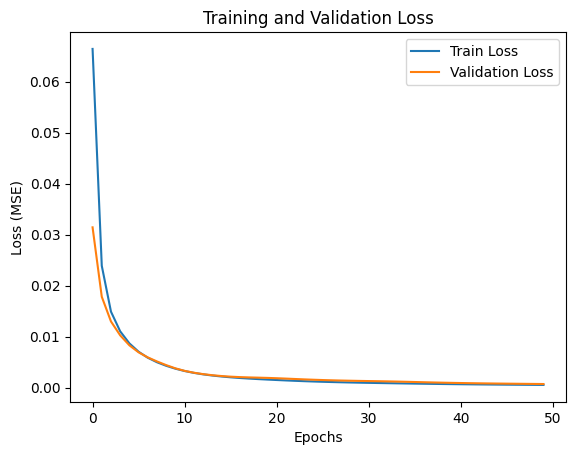

In [168]:
# Define input shape
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, num_features)


# Set random seeds
tf.random.set_seed(42)
np.random.seed(42)

# Create the model
model = create_bidirectional_lstm(input_shape=input_shape)

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # Adjust as needed
    batch_size=64,  # Adjust as needed
    verbose=1,  # 1 shows progress after each epoch
    callbacks=[early_stopping]  # Include early stopping
)

# Evaluate the model
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Loss (MSE): {val_loss}")
print(f"Validation MAE: {val_mae}")

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [169]:
import numpy as np
import pandas as pd

# Predict returns for the validation set
y_pred = model.predict(X_val).flatten()  # Predicted returns (flattened to 1D)
y_true = y_val  # True returns from validation set

# Initialize variables
position = 0  # Current position: 1 = in the market, 0 = out of the market
cumulative_return = 1  # Starting with 1 (100% initial capital)
strategy_returns = []  # To store daily returns from the strategy

# Iterate over the predicted and true returns
for i in range (0,len(y_pred)):
    pred_return = y_pred[i]
    true_return = y_true[i]
    if pred_return > 0 and position == 0:
        # Buy if predicted return is positive and currently out of the market
        position = 1
    elif pred_return < 0 and position == 1:
        # Sell if predicted return is negative and currently in the market
        position = 0
    
    # Calculate daily return based on true return if in the market
    five_day_return = true_return if position == 1 else 0
    #daily_return = true_return if position == 1 else 0
    strategy_returns.append(five_day_return)

    # Update cumulative return
    cumulative_return *= (1 + five_day_return)

# Convert strategy returns to a DataFrame for analysis
'''strategy_df = pd.DataFrame({
    "True Return": y_true,
    "Predicted Return": y_pred,
    "Strategy Return": strategy_returns
})'''

# Print cumulative return
print(f"Cumulative Return: {cumulative_return - 1:.2%}")  # As a percentage

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Cumulative Return: 6.33%


In [170]:
# Calculate true cumulative return (buy-and-hold strategy)
true_cumulative_return = np.prod(cumulative_return)  # Compounded return

# Calculate strategy cumulative return
strategy_cumulative_return = np.prod(1 + np.array(strategy_returns)) - 1  # Compounded return

print(f"True Buy-and-Hold Cumulative Return: {true_cumulative_return:.2%}")
print(f"Strategy Cumulative Return: {strategy_cumulative_return:.2%}")


True Buy-and-Hold Cumulative Return: 106.33%
Strategy Cumulative Return: 6.33%


In [171]:
# Directional Accuracy
directional_accuracy = np.mean((y_pred > 0) == (y_val > 0))
print(f"Directional Accuracy: {directional_accuracy:.2%}")

print(f"Mean of Predicted Returns: {np.mean(y_pred)}")
print(f"Mean of Actual Returns: {np.mean(y_val)}")



Directional Accuracy: 50.93%
Mean of Predicted Returns: -0.0002884639543481171
Mean of Actual Returns: 0.00026095485901919473


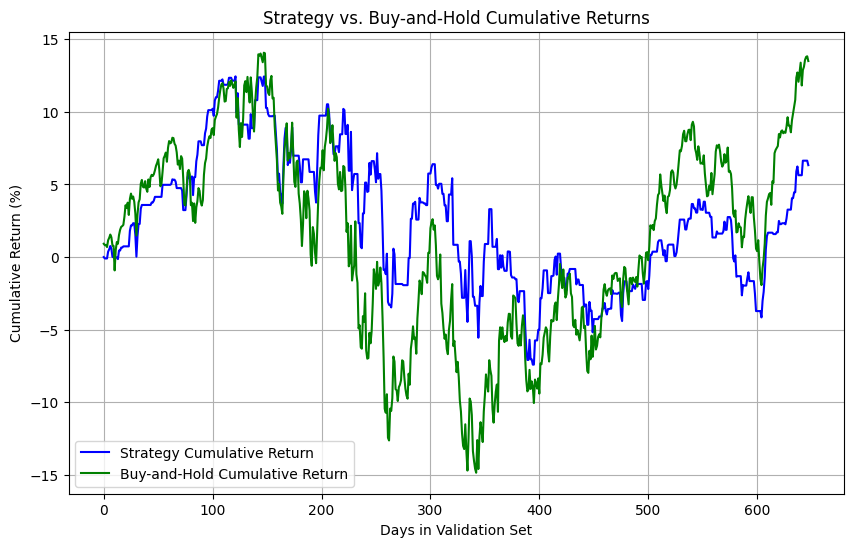

In [172]:
# Calculate cumulative returns for plotting
strategy_cumulative = (np.cumprod(1 + np.array(strategy_returns)) - 1) * 100
true_cumulative = (np.cumprod(1 + y_true) - 1) * 100

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(strategy_cumulative, label="Strategy Cumulative Return", color='blue')
plt.plot(true_cumulative, label="Buy-and-Hold Cumulative Return", color='green')
plt.xlabel("Days in Validation Set")
plt.ylabel("Cumulative Return (%)")
plt.title("Strategy vs. Buy-and-Hold Cumulative Returns")
plt.legend()
plt.grid()
plt.show()

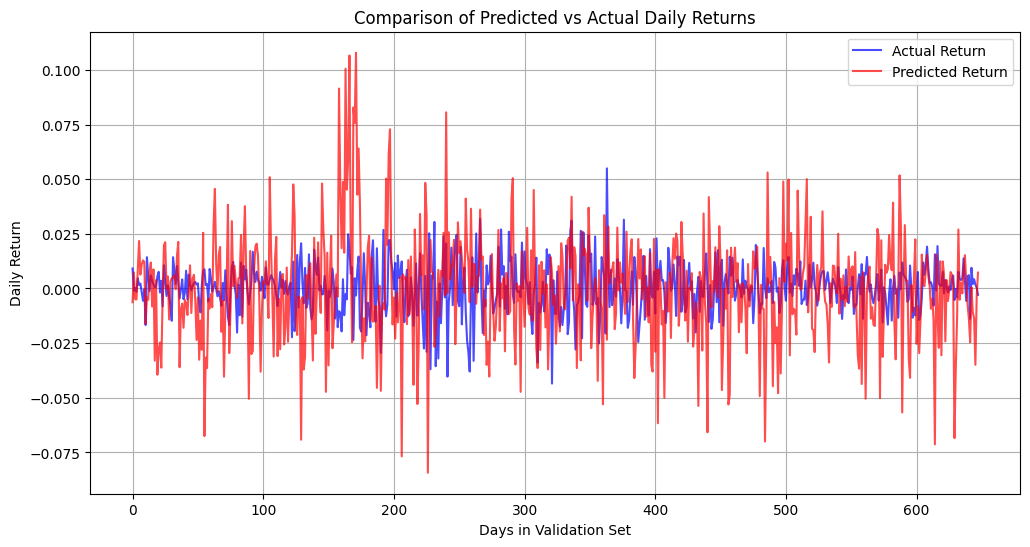

In [173]:
import matplotlib.pyplot as plt

# Plot predicted vs. actual returns
plt.figure(figsize=(12, 6))
plt.plot(y_val, label='Actual Return', color='blue', alpha=0.7)
plt.plot(y_pred, label='Predicted Return', color='red', alpha=0.7)
plt.xlabel("Days in Validation Set")
plt.ylabel("Daily Return")
plt.title("Comparison of Predicted vs Actual Daily Returns")
plt.legend()
plt.grid()
plt.show()
